In [2]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
import random
import warnings

np.random.seed(34)
warnings.filterwarnings('ignore')

In [4]:
def loadData():
    dirPath = r'C:\Users\DeLL\Documents\PFE\data\CMaps'
    trainTxtFiles = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
    testTxtFiles = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
    rulTxtFiles = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']
    trueRulTxtFile = ['x.txt']
    
    trainTestColumns = ['Unit Number', 'Time (Cycles)', 'OP1', 'OP2', 'OP3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
    
    trainDatasets = []
    testDatasets = []
    expectedRulDatasets = []
    
    for i in range(4):
        # Import Files
        tempTrain = pd.read_csv( dirPath + '\\'+ trainTxtFiles[i], sep = " ", header = None)
        tempTest = pd.read_csv( dirPath + '\\'+ testTxtFiles[i], sep = " ", header = None)
        tempRul = pd.read_csv( dirPath + '\\'+ rulTxtFiles[i], sep = " ", header = None)

        # Cleaning Files
        tempTrain.drop(inplace = True, columns = [26, 27])
        tempTest.drop(inplace = True, columns = [26, 27])
        tempRul.drop(inplace = True, columns = [1])

        # Adding Columns Names
        tempTrain.columns = tempTest.columns = trainTestColumns
        tempRul.columns = ["Expected RUL"]

        # Appending to Lists
        trainDatasets.append(tempTrain)
        testDatasets.append(tempTest)
        expectedRulDatasets.append(tempRul)
    
    return trainDatasets, testDatasets, expectedRulDatasets

In [5]:
def checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1) )
        print("\nTrain Dataset")
        display(trainDatasets[i].head())
    
        print("\nTest Dataset")
        display(testDatasets[i].head())
    
        print("\nExpected RUL")
        display(expectedRulDatasets[i].head())
        print("\n")

In [6]:
def checkForNA(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1))
        print("\nTrain Dataset")
        display(trainDatasets[i].isna().sum())
    
        print("\nTest Dataset")
        display(testDatasets[i].isna().sum())
    
        print("\nExpected RUL")
        display(expectedRulDatasets[i].isna().sum())
        print("\n")

In [7]:
def findRul(Datasets):

    rulDatasets = []
    
    for i in range(4):
        # Finding Maximum RUL
        temp = copy.deepcopy(Datasets[i].iloc[:, 0:2])
        tempRul = temp.groupby(Datasets[i].columns[0])[Datasets[i].columns[1]].max()

        # Create Max RUL Dataframe
        tempRul = pd.DataFrame(tempRul)
        tempRul.columns = ["Max"]
        tempRul = pd.merge(temp, tempRul, left_on = Datasets[i].columns[0], right_on = Datasets[i].columns[0])
        tempRul["RUL"] = tempRul["Max"] - tempRul[Datasets[i].columns[1]];
        tempRul.drop(inplace = True, columns = ["Max", Datasets[i].columns[1]])
        
        # Appending to List
        rulDatasets.append(tempRul)

    return rulDatasets

In [8]:
def checkRulBasicStructure(rulDatasets):
    print("\nRUL Datasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1) )
        print("\nExpected RUL")
        display(rulDatasets[i].head())
        print("\n")

In [9]:
def processTrainingData(dataset, rulDataset = None, window = 1, shift = 1):
    partitions = int(np.floor((len(dataset) - window) / shift)) + 1
    features = dataset.shape[1]

    processedData = np.repeat(np.nan, repeats = partitions * window * features).reshape(partitions, window, features)

    if rulDataset is None:
        for i in range(partitions):
            processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
            
        return processedData

    processedRul = np.repeat(np.nan, repeats = partitions)
    for i in range(partitions):
        processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        processedRul[i] = rulDataset[(shift * i + (window - 1))]

    return processedData, processedRul

In [10]:
def processTestingData(dataset, window, shift, testWindow = 1):
    maxPartitions = int(np.floor((len(dataset) - window) / shift)) + 1

    if maxPartitions < testWindow:
        newLen = (maxPartitions - 1) * shift + window

        processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

        return processedData, maxPartitions

    newLen = (testWindow - 1) * shift + window

    processedData = processTrainingData(dataset[-newLen:, :] , window = window, shift = shift)

    return processedData, testWindow

In [11]:
def createModel(shape, name = "Combined"):
    model = Sequential(name = name)
    model.add(LSTM(128, return_sequences = True, input_shape = (shape[1], shape[2])))
    model.add(LSTM(64 ,return_sequences = True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))

    return model

In [12]:
trainDatasets, testDatasets, expectedRulDatasets = loadData()

In [13]:
checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets)


Datasets Example

For FD001

Train Dataset


Unit Number  Time (Cycles)     OP1     OP2    OP3      S1      S2       S3  \
0            1              1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70   
1            1              2  0.0019 -0.0003  100.0  518.67  642.15  1591.82   
2            1              3 -0.0043  0.0003  100.0  518.67  642.35  1587.99   
3            1              4  0.0007  0.0000  100.0  518.67  642.35  1582.79   
4            1              5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85   

        S4     S5  ...     S12      S13      S14     S15   S16  S17   S18  \
0  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388   
1  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388   
2  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388   
3  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388   
4  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388   

     S19    S20      S21  
0  100.0  39.06  23.4190  
1  100.0  39.00  23.4236  
2  100.0  38.95  23.3442  
3  100.0  38.88  23.3739  
4  100.0  38.90  23.4044  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)     OP1     OP2    OP3      S1      S2       S3  \
0            1              1  0.0023  0.0003  100.0  518.67  643.02  1585.29   
1            1              2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45   
2            1              3  0.0003  0.0001  100.0  518.67  642.46  1586.94   
3            1              4  0.0042  0.0000  100.0  518.67  642.44  1584.12   
4            1              5  0.0014  0.0000  100.0  518.67  642.51  1587.19   

        S4     S5  ...     S12      S13      S14     S15   S16  S17   S18  \
0  1398.21  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388   
1  1395.42  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388   
2  1401.34  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388   
3  1406.42  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388   
4  1401.92  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388   

     S19    S20      S21  
0  100.0  38.86  23.3735  
1  100.0  39.02  23.3916  
2  100.0  39.08  23.4166  
3  100.0  39.00  23.3737  
4  100.0  38.99  23.4130  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0           112
1            98
2            69
3            82
4            91



For FD002

Train Dataset


Unit Number  Time (Cycles)      OP1     OP2    OP3      S1      S2  \
0            1              1  34.9983  0.8400  100.0  449.44  555.32   
1            1              2  41.9982  0.8408  100.0  445.00  549.90   
2            1              3  24.9988  0.6218   60.0  462.54  537.31   
3            1              4  42.0077  0.8416  100.0  445.00  549.51   
4            1              5  25.0005  0.6203   60.0  462.54  537.07   

        S3       S4    S5  ...     S12      S13      S14      S15   S16  S17  \
0  1358.61  1137.23  5.48  ...  183.06  2387.72  8048.56   9.3461  0.02  334   
1  1353.22  1125.78  3.91  ...  130.42  2387.66  8072.30   9.3774  0.02  330   
2  1256.76  1047.45  7.05  ...  164.22  2028.03  7864.87  10.8941  0.02  309   
3  1354.03  1126.38  3.91  ...  130.72  2387.61  8068.66   9.3528  0.02  329   
4  1257.71  1047.93  7.05  ...  164.31  2028.00  7861.23  10.8963  0.02  309   

    S18     S19    S20     S21  
0  2223  100.00  14.73  8.8071  
1  2212  100.00  10.41  6.2665  
2  1915   84.93  14.08  8.6723  
3  2212  100.00  10.59  6.4701  
4  1915   84.93  14.13  8.5286  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)      OP1     OP2    OP3      S1      S2  \
0            1              1   9.9987  0.2502  100.0  489.05  605.03   
1            1              2  20.0026  0.7000  100.0  491.19  607.82   
2            1              3  35.0045  0.8400  100.0  449.44  556.00   
3            1              4  42.0066  0.8410  100.0  445.00  550.17   
4            1              5  24.9985  0.6213   60.0  462.54  536.72   

        S3       S4     S5  ...     S12      S13      S14      S15   S16  S17  \
0  1497.17  1304.99  10.52  ...  371.69  2388.18  8114.10   8.6476  0.03  369   
1  1481.20  1246.11   9.35  ...  315.32  2388.12  8053.06   9.2405  0.02  364   
2  1359.08  1128.36   5.48  ...  183.04  2387.75  8053.04   9.3472  0.02  333   
3  1349.69  1127.89   3.91  ...  130.40  2387.72  8066.90   9.3961  0.02  332   
4  1253.18  1050.69   7.05  ...  164.56  2028.05  7865.66  10.8682  0.02  305   

    S18     S19    S20      S21  
0  2319  100.00  28.42  17.1551  
1  2324  100.00  24.29  14.8039  
2  2223  100.00  14.98   8.9125  
3  2212  100.00  10.35   6.4181  
4  1915   84.93  14.31   8.5740  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            18
1            79
2           106
3           110
4            15



For FD003

Train Dataset


Unit Number  Time (Cycles)     OP1     OP2    OP3      S1      S2       S3  \
0            1              1 -0.0005  0.0004  100.0  518.67  642.36  1583.23   
1            1              2  0.0008 -0.0003  100.0  518.67  642.50  1584.69   
2            1              3 -0.0014 -0.0002  100.0  518.67  642.18  1582.35   
3            1              4 -0.0020  0.0001  100.0  518.67  642.92  1585.61   
4            1              5  0.0016  0.0000  100.0  518.67  641.68  1588.63   

        S4     S5  ...     S12      S13      S14     S15   S16  S17   S18  \
0  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03  391  2388   
1  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03  392  2388   
2  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901  0.03  391  2388   
3  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878  0.03  392  2388   
4  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869  0.03  392  2388   

     S19    S20      S21  
0  100.0  39.11  23.3537  
1  100.0  38.99  23.4491  
2  100.0  38.85  23.3669  
3  100.0  38.96  23.2951  
4  100.0  39.14  23.4583  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)     OP1     OP2    OP3      S1      S2       S3  \
0            1              1 -0.0017 -0.0004  100.0  518.67  641.94  1581.93   
1            1              2  0.0006 -0.0002  100.0  518.67  642.02  1584.86   
2            1              3  0.0014 -0.0003  100.0  518.67  641.68  1581.78   
3            1              4  0.0027  0.0001  100.0  518.67  642.20  1584.53   
4            1              5 -0.0001  0.0001  100.0  518.67  642.46  1589.03   

        S4     S5  ...     S12      S13      S14     S15   S16  S17   S18  \
0  1396.93  14.62  ...  521.89  2387.94  8133.48  8.3760  0.03  391  2388   
1  1398.90  14.62  ...  521.85  2388.01  8137.44  8.4062  0.03  391  2388   
2  1391.92  14.62  ...  522.10  2387.94  8138.25  8.3553  0.03  391  2388   
3  1395.34  14.62  ...  522.45  2387.96  8137.07  8.3709  0.03  392  2388   
4  1395.86  14.62  ...  521.91  2387.97  8134.20  8.4146  0.03  391  2388   

     S19    S20      S21  
0  100.0  39.07  23.4468  
1  100.0  39.04  23.4807  
2  100.0  39.10  23.4244  
3  100.0  38.97  23.4782  
4  100.0  39.09  23.3950  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            44
1            51
2            27
3           120
4           101



For FD004

Train Dataset


Unit Number  Time (Cycles)      OP1     OP2    OP3      S1      S2  \
0            1              1  42.0049  0.8400  100.0  445.00  549.68   
1            1              2  20.0020  0.7002  100.0  491.19  606.07   
2            1              3  42.0038  0.8409  100.0  445.00  548.95   
3            1              4  42.0000  0.8400  100.0  445.00  548.70   
4            1              5  25.0063  0.6207   60.0  462.54  536.10   

        S3       S4    S5  ...     S12      S13      S14      S15   S16  S17  \
0  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335  0.02  330   
1  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913  0.02  361   
2  1343.12  1117.05  3.91  ...  129.62  2387.97  8066.62   9.4007  0.02  329   
3  1341.24  1118.03  3.91  ...  129.80  2388.02  8076.05   9.3369  0.02  328   
4  1255.23  1033.59  7.05  ...  164.11  2028.08  7865.80  10.8366  0.02  305   

    S18     S19    S20      S21  
0  2212  100.00  10.62   6.3670  
1  2324  100.00  24.37  14.6552  
2  2212  100.00  10.48   6.4213  
3  2212  100.00  10.54   6.4176  
4  1915   84.93  14.03   8.6754  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)      OP1     OP2    OP3      S1      S2  \
0            1              1  20.0072  0.7000  100.0  491.19  606.67   
1            1              2  24.9984  0.6200   60.0  462.54  536.22   
2            1              3  42.0000  0.8420  100.0  445.00  549.23   
3            1              4  42.0035  0.8402  100.0  445.00  549.19   
4            1              5  35.0079  0.8400  100.0  449.44  555.10   

        S3       S4    S5  ...     S12      S13      S14      S15   S16  S17  \
0  1481.04  1227.81  9.35  ...  313.03  2387.78  8048.98   9.2229  0.02  362   
1  1256.17  1031.48  7.05  ...  163.61  2028.09  7863.46  10.8632  0.02  306   
2  1340.13  1105.88  3.91  ...  129.98  2387.95  8071.13   9.3960  0.02  328   
3  1339.70  1107.26  3.91  ...  129.48  2387.90  8078.89   9.3594  0.02  328   
4  1353.04  1117.80  5.48  ...  181.82  2387.87  8057.83   9.3030  0.02  333   

    S18     S19    S20      S21  
0  2324  100.00  24.31  14.7007  
1  1915   84.93  14.36   8.5748  
2  2212  100.00  10.39   6.4365  
3  2212  100.00  10.56   6.2367  
4  2223  100.00  14.85   8.9326  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            22
1            39
2           107
3            75
4           149

In [14]:
checkForNA(trainDatasets, testDatasets, expectedRulDatasets)


Datasets Example

For FD001

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD002

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD003

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64



For FD004

Train Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Test Dataset


Unit Number      0
Time (Cycles)    0
OP1              0
OP2              0
OP3              0
S1               0
S2               0
S3               0
S4               0
S5               0
S6               0
S7               0
S8               0
S9               0
S10              0
S11              0
S12              0
S13              0
S14              0
S15              0
S16              0
S17              0
S18              0
S19              0
S20              0
S21              0
dtype: int64


Expected RUL


Expected RUL    0
dtype: int64

In [15]:
trainDatasetsCopy = copy.deepcopy(trainDatasets)
testDatasetsCopy = copy.deepcopy(testDatasets)
expectedRulDatasetsCopy = copy.deepcopy(expectedRulDatasets)

In [16]:
scaler = []

for i in range(4):
    sc = StandardScaler()
    scaler.append(sc)

In [17]:
for i in range(4):
    trainDatasetsCopy[i].iloc[:, 2:] = scaler[i].fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    testDatasetsCopy[i].iloc[:, 2: ] = scaler[i].transform(testDatasetsCopy[i].iloc[:, 2:])

In [18]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


Unit Number  Time (Cycles)       OP1       OP2  OP3   S1        S2  \
0            1              1 -0.315980 -1.372953  0.0  0.0 -1.721725   
1            1              2  0.872722 -1.031720  0.0  0.0 -1.061780   
2            1              3 -1.961874  1.015677  0.0  0.0 -0.661813   
3            1              4  0.324090 -0.008022  0.0  0.0 -0.661813   
4            1              5 -0.864611 -0.690488  0.0  0.0 -0.621816   

         S3        S4            S5  ...       S12       S13       S14  \
0 -0.134255 -0.925936 -1.776357e-15  ...  0.334262 -1.058890 -0.269071   
1  0.211528 -0.643726 -1.776357e-15  ...  1.174899 -0.363646 -0.642845   
2 -0.413166 -0.525953 -1.776357e-15  ...  1.364721 -0.919841 -0.551629   
3 -1.261314 -0.784831 -1.776357e-15  ...  1.961302 -0.224597 -0.520176   
4 -1.251528 -0.301518 -1.776357e-15  ...  1.052871 -0.780793 -0.521748   

        S15           S16       S17  S18  S19       S20       S21  
0 -0.603816 -1.387779e-17 -0.781710    0  0.0  1.348493  1.194427  
1 -0.275852 -1.387779e-17 -0.781710    0  0.0  1.016528  1.236922  
2 -0.649144 -1.387779e-17 -2.073094    0  0.0  0.739891  0.503423  
3 -1.971665 -1.387779e-17 -0.781710    0  0.0  0.352598  0.777792  
4 -0.339845 -1.387779e-17 -0.136018    0  0.0  0.463253  1.059552  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)       OP1       OP2  OP3   S1        S2  \
0            1              1  1.055599  1.015677  0.0  0.0  0.678077   
1            1              2 -1.230366 -1.031720  0.0  0.0 -1.941707   
2            1              3  0.141213  0.333211  0.0  0.0 -0.441831   
3            1              4  1.924266 -0.008022  0.0  0.0 -0.481827   
4            1              5  0.644125 -0.008022  0.0  0.0 -0.341839   

         S3        S4            S5  ...       S12       S13       S14  \
0 -0.853550 -1.191480 -1.776357e-15  ...  0.415614 -0.919841 -0.954235   
1 -0.338137 -1.501467 -1.776357e-15  ...  1.012195 -0.502695 -0.216648   
2 -0.584426 -0.843717 -1.776357e-15  ...  0.754581 -0.919841 -0.715712   
3 -1.044384 -0.279297 -1.776357e-15  ... -0.045381 -0.641744 -0.568929   
4 -0.543650 -0.779276 -1.776357e-15  ...  0.998637 -0.919841 -0.745069   

        S15           S16       S17  S18  S19       S20       S21  
0 -0.985107 -1.387779e-17 -0.781710    0  0.0  0.241943  0.774097  
1 -1.649034 -1.387779e-17 -0.136018    0  0.0  1.127183  0.941305  
2  0.052112 -1.387779e-17 -0.136018    0  0.0  1.459148  1.172256  
3 -1.345067 -1.387779e-17 -1.427402    0  0.0  1.016528  0.775945  
4 -1.041101 -1.387779e-17 -2.073094    0  0.0  0.961200  1.138999  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0           112
1            98
2            69
3            82
4            91



For FD002

Train Dataset


Unit Number  Time (Cycles)       OP1       OP2       OP3        S1  \
0            1              1  0.745895  0.864298  0.418187 -0.889378   
1            1              2  1.220553  0.866878  0.418187 -1.057627   
2            1              3  0.067836  0.160457 -2.391275 -0.392968   
3            1              4  1.221198  0.869459  0.418187 -1.057627   
4            1              5  0.067951  0.155618 -2.391275 -0.392968   

         S2        S3        S4        S5  ...       S12       S13       S14  \
0 -0.653071 -0.579176 -0.572622 -0.706177  ... -0.603008  0.415116 -0.212615   
1 -0.798422 -0.630051 -0.668741 -1.140622  ... -0.985404  0.414648  0.067215   
2 -1.136055 -1.540521 -1.326301 -0.271732  ... -0.739869 -2.393490 -2.377822   
3 -0.808881 -0.622406 -0.663705 -1.140622  ... -0.983225  0.414257  0.024309   
4 -1.142491 -1.531554 -1.322271 -0.271732  ... -0.739215 -2.393724 -2.420728   

        S15       S16       S17       S18       S19       S20       S21  
0  0.021948 -0.705933 -0.515579 -0.039954  0.418187 -0.613958 -0.619148  
1  0.063719 -0.705933 -0.659701 -0.115645  0.418187 -1.051681 -1.048190  
2  2.087798 -0.705933 -1.416342 -2.159318 -2.391275 -0.679819 -0.641912  
3  0.030890 -0.705933 -0.695731 -0.115645  0.418187 -1.033443 -1.013808  
4  2.090734 -0.705933 -1.416342 -2.159318 -2.391275 -0.674753 -0.666180  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)       OP1       OP2       OP3        S1  \
0            1              1 -0.949310 -1.038202  0.418187  0.611600   
1            1              2 -0.270953  0.412704  0.418187  0.692693   
2            1              3  0.746315  0.864298  0.418187 -0.889378   
3            1              4  1.221123  0.867523  0.418187 -1.057627   
4            1              5  0.067816  0.158844 -2.391275 -0.392968   

         S2        S3        S4        S5  ...       S12       S13       S14  \
0  0.680028  0.728668  0.835679  0.688475  ...  0.767270  0.418708  0.559923   
1  0.754849  0.577930  0.341397  0.364716  ...  0.357777  0.418240 -0.159573   
2 -0.634835 -0.574740 -0.647083 -0.706177  ... -0.603153  0.415351 -0.159808   
3 -0.791181 -0.663370 -0.651028 -1.140622  ... -0.985550  0.415116  0.003564   
4 -1.151877 -1.574312 -1.299102 -0.271732  ... -0.737399 -2.393334 -2.368510   

        S15       S16       S17       S18       S19       S20       S21  
0 -0.910220  1.416565  0.745489  0.620627  0.418187  0.773181  0.790616  
1 -0.118978 -0.705933  0.565336  0.655032  0.418187  0.354709  0.393558  
2  0.023416 -0.705933 -0.551609 -0.039954  0.418187 -0.588627 -0.601349  
3  0.088675 -0.705933 -0.587640 -0.115645  0.418187 -1.057761 -1.022589  
4  2.053234 -0.705933 -1.560464 -2.159318 -2.391275 -0.656514 -0.658513  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            18
1            79
2           106
3           110
4            15



For FD003

Train Dataset


Unit Number  Time (Cycles)       OP1       OP2  OP3   S1        S2  \
0            1              1 -0.217122  1.343135  0.0  0.0 -0.187102   
1            1              2  0.375538 -1.037519  0.0  0.0  0.080574   
2            1              3 -0.627426 -0.697425  0.0  0.0 -0.531256   
3            1              4 -0.900961  0.322855  0.0  0.0  0.883602   
4            1              5  0.740252 -0.017239  0.0  0.0 -1.487242   

         S3        S4            S5  ...       S12       S13       S14  \
0 -0.712038 -0.780848 -3.552714e-15  ... -0.227593 -0.389857  0.067687   
1 -0.497656 -0.775732 -3.552714e-15  ... -0.193802 -0.263369  0.523946   
2 -0.841254  0.116524 -3.552714e-15  ... -0.313608 -0.453101  0.361559   
3 -0.362566 -1.248464 -3.552714e-15  ... -0.172298  0.052852  0.142821   
4  0.080881 -0.697966 -3.552714e-15  ... -0.144650 -0.263369  0.217955   

        S15           S16       S17  S18  S19       S20       S21  
0  0.469741 -1.734723e-17 -0.889364    0  0.0  0.488019 -0.263512  
1  0.729201 -1.734723e-17 -0.321641    0  0.0  0.005819  0.375767  
2 -0.100409 -1.734723e-17 -0.889364    0  0.0 -0.556747 -0.175058  
3 -0.138419 -1.734723e-17 -0.321641    0  0.0 -0.114730 -0.656192  
4 -0.153292 -1.734723e-17 -0.321641    0  0.0  0.608569  0.437416  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)       OP1       OP2  OP3   S1        S2  \
0            1              1 -0.764193 -1.377612  0.0  0.0 -0.990129   
1            1              2  0.284359 -0.697425  0.0  0.0 -0.837172   
2            1              3  0.649073 -1.037519  0.0  0.0 -1.487242   
3            1              4  1.241733  0.322855  0.0  0.0 -0.493017   
4            1              5 -0.034765  0.322855  0.0  0.0  0.004095   

         S3        S4            S5  ...       S12       S13       S14  \
0 -0.902925 -0.771639 -3.552714e-15  ... -0.356616 -0.832566 -0.649725   
1 -0.472693 -0.570063 -3.552714e-15  ... -0.368904 -0.389857 -0.409780   
2 -0.924951 -1.284277 -3.552714e-15  ... -0.292104 -0.832566 -0.360700   
3 -0.521150 -0.934332 -3.552714e-15  ... -0.184586 -0.706078 -0.432199   
4  0.139616 -0.881124 -3.552714e-15  ... -0.350472 -0.642833 -0.606098   

        S15           S16       S17  S18  S19       S20       S21  
0 -0.333427 -1.734723e-17 -0.889364    0  0.0  0.327286  0.360354  
1  0.165661 -1.734723e-17 -0.889364    0  0.0  0.206736  0.587519  
2 -0.675517 -1.734723e-17 -0.889364    0  0.0  0.447836  0.210251  
3 -0.417710 -1.734723e-17 -0.321641    0  0.0 -0.074547  0.570767  
4  0.304480 -1.734723e-17 -0.889364    0  0.0  0.407652  0.013241  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            44
1            51
2            27
3           120
4           101



For FD004

Train Dataset


Unit Number  Time (Cycles)       OP1       OP2       OP3        S1  \
0            1              1  1.218156  0.864668  0.418783 -1.054690   
1            1              2 -0.270478  0.414718  0.418783  0.692508   
2            1              3  1.218082  0.867565  0.418783 -1.054690   
3            1              4  1.217824  0.864668  0.418783 -1.054690   
4            1              5  0.068094  0.158844 -2.387873 -0.391216   

         S2        S3        S4        S5  ...       S12       S13       S14  \
0 -0.796416 -0.701412 -0.745729 -1.137677  ... -0.989007  0.417814  0.081921   
1  0.713666  0.562449  0.298212  0.363906  ...  0.331131  0.415786 -0.253086   
2 -0.815965 -0.704332 -0.711202 -1.137677  ... -0.990162  0.417658 -0.013912   
3 -0.822660 -0.722040 -0.702990 -1.137677  ... -0.988862  0.418048  0.096162   
4 -1.160079 -1.532181 -1.410627 -0.270955  ... -0.741097 -2.389666 -2.358027   

        S15       S16       S17       S18       S19       S20       S21  
0  0.063831 -0.694278 -0.638665 -0.114203  0.418783 -1.030999 -1.031756  
1 -0.125677 -0.694278  0.476120  0.655708  0.418783  0.352814  0.358264  
2  0.153387 -0.694278 -0.674626 -0.114203  0.418783 -1.045089 -1.022649  
3  0.068362 -0.694278 -0.710586 -0.114203  0.418783 -1.039051 -1.023269  
4  2.066982 -0.694278 -1.537685 -2.155843 -2.387873 -0.687814 -0.644612  

[5 rows x 26 columns]


Test Dataset


Unit Number  Time (Cycles)       OP1       OP2       OP3        S1  \
0            1              1 -0.270126  0.414074  0.418783  0.692508   
1            1              2  0.067560  0.156591 -2.387873 -0.391216   
2            1              3  1.217824  0.871105  0.418783 -1.054690   
3            1              4  1.218061  0.865312  0.418783 -1.054690   
4            1              5  0.744765  0.864668  0.418783 -0.886741   

         S2        S3        S4        S5  ...       S12       S13       S14  \
0  0.729733  0.594757  0.217006  0.363906  ...  0.334308  0.416176 -0.219818   
1 -1.156865 -1.523327 -1.428310 -0.270955  ... -0.744708 -2.389588 -2.385341   
2 -0.808467 -0.732495 -0.804811 -1.137677  ... -0.987563  0.417502  0.038732   
3 -0.809538 -0.736545 -0.793246 -1.137677  ... -0.991173  0.417112  0.129313   
4 -0.651273 -0.610894 -0.704917 -0.704316  ... -0.613207  0.416878 -0.116515   

        S15       S16       S17       S18       S19       S20       S21  
0 -0.083564 -0.694278  0.512081  0.655708  0.418783  0.346775  0.365895  
1  2.102432 -0.694278 -1.501724 -2.155843 -2.387873 -0.654602 -0.661484  
2  0.147123 -0.694278 -0.710586 -0.114203  0.418783 -1.054147 -1.020100  
3  0.098347 -0.694278 -0.710586 -0.114203  0.418783 -1.037038 -1.053608  
4  0.023184 -0.694278 -0.530782 -0.038587  0.418783 -0.605288 -0.601477  

[5 rows x 26 columns]


Expected RUL


Expected RUL
0            22
1            39
2           107
3            75
4           149

In [19]:
pca = PCA(n_components = 10)

In [20]:
newColumns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']

for i in range(4):
    # Finding Principal Components
    temp1 = pca.fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    temp2 = pca.transform(testDatasetsCopy[i].iloc[:, 2:])

    # Converting to Dataframes
    temp1 = pd.DataFrame(temp1, columns = newColumns)
    temp2 = pd.DataFrame(temp2, columns = newColumns)

    # Dropping Excess Data
    trainDatasetsCopy[i].drop(inplace = True, columns = trainDatasetsCopy[i].columns[2:])
    testDatasetsCopy[i].drop(inplace = True, columns = testDatasetsCopy[i].columns[2:])

    # Merging New Data
    trainDatasetsCopy[i] = pd.merge(trainDatasetsCopy[i], temp1, left_index=True, right_index=True)
    testDatasetsCopy[i] = pd.merge(testDatasetsCopy[i], temp2, left_index=True, right_index=True)

In [21]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -2.952779 -0.432156 -1.172843  0.478171   
1            1              2 -2.363669 -0.786872 -0.132349  1.153850   
2            1              3 -2.978665 -0.552466 -0.530408 -2.124418   
3            1              4 -3.384151 -0.843788  0.255770  0.134290   
4            1              5 -2.428327 -0.363296 -1.024880 -0.306351   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.668797  0.817216  0.637089 -0.347993  0.030831  0.642404  
1 -0.702399  0.976451  0.301464 -0.021018 -0.316129  0.656538  
2  0.376082  0.572007 -1.122427 -0.461569  0.254894  0.096212  
3 -0.337991 -0.399344 -0.050440  0.127225 -0.115972 -1.127490  
4 -0.352159 -0.732400  0.355341  0.068085 -0.488117  0.225827


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -2.475403 -0.777619  1.482786  0.080010   
1            1              2 -3.566323 -0.040873 -1.520490 -0.408165   
2            1              3 -2.336877 -0.379826  0.385361 -0.196137   
3            1              4 -2.850192 -0.810491  1.328483  1.310859   
4            1              5 -3.494312 -0.752334  0.477794  0.370824   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.077868 -0.337896 -0.826615  0.921520 -0.393515 -0.616565  
1 -0.459367  0.561212  1.260243 -0.117897  0.206018 -0.495765  
2 -0.169551 -0.050891  0.401225  0.680498 -0.077260  1.011673  
3 -0.576017 -0.068813 -0.668261  0.035846  0.225531 -0.174019  
4 -0.401362  0.567157 -1.189312  0.103837 -0.134968  0.041174


Expected RUL


Expected RUL
0           112
1            98
2            69
3            82
4            91



For FD002

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -2.193283 -1.610639  0.172923 -0.044703   
1            1              2 -2.960044 -2.218475 -0.234083 -0.010842   
2            1              3 -5.997478  4.311099  0.009899  0.031464   
3            1              4 -2.973606 -2.194856 -0.229045 -0.015612   
4            1              5 -5.999720  4.313578  0.016556  0.043446   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.465595 -0.035497 -0.086489  0.084043  0.072604  0.042379  
1  0.052701 -0.219312 -0.081758 -0.029655 -0.009121  0.013221  
2 -0.084929 -0.098735 -0.011958 -0.032155  0.062204 -0.050169  
3 -0.010290 -0.219909 -0.075195 -0.073249 -0.036594  0.046409  
4 -0.089655 -0.152329 -0.033390  0.002800  0.059059 -0.055836


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1  3.771877  0.275882 -0.903953  0.178039   
1            1              2  1.582260 -0.409099  1.600337  0.018506   
2            1              3 -2.213299 -1.609845  0.160569 -0.063684   
3            1              4 -2.949430 -2.193961 -0.199757  0.015900   
4            1              5 -6.022637  4.304434 -0.026147  0.001671   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.215025 -0.208216  0.155550  0.003791  0.021832 -0.014226  
1 -0.032958 -0.128779  0.153903 -0.029624  0.000802  0.006236  
2 -0.486447  0.042858 -0.062398  0.025642  0.035400  0.027372  
3  0.046270 -0.262185 -0.089598 -0.015977  0.054234 -0.020710  
4 -0.115800 -0.088908 -0.022933 -0.045629  0.043022  0.074625


Expected RUL


Expected RUL
0            18
1            79
2           106
3           110
4            15



For FD003

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -1.366276 -0.371377  1.330873 -0.136651   
1            1              2 -0.894613 -0.158613 -0.985330  0.270185   
2            1              3 -1.056447 -0.147081 -0.534173 -0.719504   
3            1              4 -0.741439  0.062070  0.371353 -0.890957   
4            1              5 -0.616731 -1.081516 -0.025239  0.709367   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.343447 -1.057079  0.552070 -0.135855  0.366492 -0.125711  
1  0.354589 -1.238571  0.348132 -0.243628  0.350986  0.302206  
2  0.456698 -1.201660  0.217314 -0.235968  0.050396 -0.758806  
3 -0.194248 -0.855163  0.279733 -0.461902  0.992138  0.551730  
4  0.077095 -1.631234 -0.288941  0.781622 -0.543812  0.176199


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -2.162372 -1.838379 -1.264398 -0.865922   
1            1              2 -1.907783 -1.420004 -0.683069  0.234206   
2            1              3 -2.022972 -2.178672 -0.969285  0.548993   
3            1              4 -1.453940 -1.189275  0.263542  1.254994   
4            1              5 -1.818713 -1.046527  0.312300 -0.004284   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0  0.356273  0.339945 -0.107751  0.009061 -0.089757  0.007523  
1  0.205843  0.303783 -0.306239  0.262275  0.096927 -0.040463  
2  0.548613 -0.052953 -0.484171  0.117500 -0.326351 -0.049353  
3  0.115653  0.059188  0.170727  0.020299 -0.054890  0.476296  
4 -0.119008  0.455562 -0.351168  0.481077  0.875596  0.424866


Expected RUL


Expected RUL
0            44
1            51
2            27
3           120
4           101



For FD004

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1 -3.015023 -2.202168 -0.212861  0.004079   
1            1              2  1.469597 -0.389370  1.624185  0.086131   
2            1              3 -3.061170 -2.154521 -0.179298  0.045399   
3            1              4 -3.012203 -2.201073 -0.261818 -0.026984   
4            1              5 -6.066693  4.297044  0.000600  0.022087   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0  0.012118 -0.119927 -0.097312 -0.121166  0.026984 -0.033107  
1 -0.111275 -0.146623  0.112017 -0.082148  0.021783  0.039646  
2 -0.010963 -0.190349 -0.122244 -0.070166  0.062872 -0.025807  
3  0.007403 -0.139130 -0.065482 -0.108467  0.041192 -0.033449  
4 -0.126427 -0.035908 -0.036928 -0.083133 -0.010179  0.011829


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1              1  1.455502 -0.385731  1.631894  0.091886   
1            1              2 -6.090458  4.329211  0.022114  0.038731   
2            1              3 -3.098689 -2.166248 -0.201426  0.024057   
3            1              4 -3.064131 -2.212687 -0.241819 -0.011640   
4            1              5 -2.262396 -1.610898  0.134049 -0.076948   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.114074 -0.113163  0.122561 -0.087728  0.069559  0.079452  
1 -0.158762 -0.035487 -0.017696 -0.113204  0.044688  0.025707  
2 -0.043218 -0.129818 -0.099219 -0.123764  0.111120 -0.012944  
3  0.005516 -0.085170 -0.096632 -0.116447  0.077191 -0.027416  
4 -0.526831  0.050958 -0.047500 -0.015184  0.046406 -0.042639


Expected RUL


Expected RUL
0            22
1            39
2           107
3            75
4           149

In [22]:
trainRulDatasets = findRul(trainDatasets)

In [23]:
checkRulBasicStructure(trainRulDatasets)


RUL Datasets Example

For FD001

Expected RUL


Unit Number  RUL
0            1  191
1            1  190
2            1  189
3            1  188
4            1  187



For FD002

Expected RUL


Unit Number  RUL
0            1  148
1            1  147
2            1  146
3            1  145
4            1  144



For FD003

Expected RUL


Unit Number  RUL
0            1  258
1            1  257
2            1  256
3            1  255
4            1  254



For FD004

Expected RUL


Unit Number  RUL
0            1  320
1            1  319
2            1  318
3            1  317
4            1  316

In [24]:
defaultWindow = 10
defaultShift = 1
defaultTestWindow = 10

processedTrainDatasets = []
processedTestDatasets = []
processedTrainRulDatasets = []
rulDatasets = []
testWindowList = []

predictedRulDatasets = []
rmseList = []
r2_scoreList = []

In [25]:
scaler_model = []

for i in range(4):
    sc = StandardScaler()
    scaler_model.append(sc)

In [26]:
for i in range(4):
    trainDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].fit_transform(trainDatasetsCopy[i].iloc[:, 1:])
    testDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].transform(testDatasetsCopy[i].iloc[:, 1:])

In [27]:
checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)


Datasets Example

For FD001

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.565170 -0.982805 -0.298302 -1.165681  0.480055   
1            1      -1.550652 -0.786725 -0.543150 -0.131541  1.158397   
2            1      -1.536134 -0.991421 -0.381348 -0.527169 -2.132790   
3            1      -1.521616 -1.126383 -0.582438  0.254208  0.134819   
4            1      -1.507098 -0.808246 -0.250770 -1.018621 -0.307559   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.681850  1.270487  1.049912 -0.589645  0.055731  1.193393  
1 -0.716109  1.518041  0.496808 -0.035613 -0.571453  1.219650  
2  0.383423  0.889271 -1.849743 -0.782089  0.460761  0.178733  
3 -0.344588 -0.620840 -0.083125  0.215573 -0.209637 -2.094539  
4 -0.359033 -1.138626  0.585596  0.115364 -0.882349  0.419518


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.565170 -0.823915 -0.536763  1.473731  0.080326   
1            1      -1.550652 -1.187017 -0.028213 -1.511205 -0.409774   
2            1      -1.536134 -0.777808 -0.262180  0.383008 -0.196910   
3            1      -1.521616 -0.948660 -0.559454  1.320370  1.316024   
4            1      -1.507098 -1.163049 -0.519310  0.474876  0.372285   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.079388 -0.525311 -1.362249  1.561438 -0.711340 -1.145392  
1 -0.468333  0.872489  2.076861 -0.199766  0.372411 -0.920983  
2 -0.172861 -0.079118  0.661213  1.153046 -0.139660  1.879385  
3 -0.587260 -0.106980 -1.101284  0.060738  0.407683 -0.323275  
4 -0.409196  0.881732 -1.959969  0.175943 -0.243976  0.076489


Expected RUL


Expected RUL
0           112
1            98
2            69
3            82
4            91



For FD002

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.563383 -0.509058 -0.735877  0.255574 -0.142775   
1            1      -1.548928 -0.687022 -1.013588 -0.345966 -0.034627   
2            1      -1.534473 -1.392006  1.969676  0.014631  0.100492   
3            1      -1.520018 -0.690170 -1.002796 -0.338520 -0.049864   
4            1      -1.505563 -1.392526  1.970809  0.024470  0.138761   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -2.317216 -0.233910 -0.678699  1.074860  1.974567  1.268166  
1  0.262289 -1.445190 -0.641575 -0.379266 -0.248052  0.395623  
2 -0.422680 -0.650631 -0.093840 -0.411240  1.691711 -1.501274  
3 -0.051210 -1.449123 -0.590074 -0.936814 -0.995216  1.388766  
4 -0.446201 -1.003794 -0.262019  0.035813  1.606194 -1.670846


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.563383  0.875447  0.126046 -1.336009  0.568636   
1            1      -1.548928  0.367240 -0.186911  2.365239  0.059108   
2            1      -1.534473 -0.513704 -0.735514  0.237316 -0.203401   
3            1      -1.520018 -0.684558 -1.002388 -0.295234  0.050783   
4            1      -1.505563 -1.397845  1.966631 -0.038645  0.005338   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -1.070154 -1.372073  1.220632  0.048487  0.593750 -0.425693  
1 -0.164030 -0.848607  1.207713 -0.378873  0.021810  0.186605  
2 -2.420994  0.282419 -0.489652  0.327942  0.962748  0.819082  
3  0.230281 -1.727704 -0.703093 -0.204336  1.474954 -0.619746  
4 -0.576326 -0.585870 -0.179960 -0.583572  1.170050  2.233087


Expected RUL


Expected RUL
0            18
1            79
2           106
3           110
4            15



For FD003

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.396909 -0.500635 -0.170463  1.327739 -0.136614   
1            1      -1.386793 -0.327807 -0.072804 -0.983010  0.270112   
2            1      -1.376676 -0.387106 -0.067510 -0.532915 -0.719309   
3            1      -1.366559 -0.271680  0.028490  0.370479 -0.890715   
4            1      -1.356442 -0.225984 -0.496418 -0.025180  0.709175   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.357403 -1.195871  0.840232 -0.233322  0.661970 -0.251773  
1  0.368997 -1.401193  0.529845 -0.418416  0.633963  0.605255  
2  0.475255 -1.359435  0.330745 -0.405261  0.091027 -1.519729  
3 -0.202141 -0.967444  0.425744 -0.793288  1.792034  1.104998  
4  0.080227 -1.845411 -0.439758  1.342389 -0.982252  0.352889


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.396909 -0.792342 -0.843820 -1.261420 -0.865687   
1            1      -1.386793 -0.699055 -0.651785 -0.681460  0.234143   
2            1      -1.376676 -0.741263 -1.000015 -0.967002  0.548844   
3            1      -1.366559 -0.532757 -0.545879  0.262922  1.254654   
4            1      -1.356442 -0.666418 -0.480358  0.311564 -0.004283   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0  0.370749  0.384579 -0.163993  0.015562 -0.162123  0.015068  
1  0.214207  0.343668 -0.466085  0.450440  0.175074 -0.081038  
2  0.570904 -0.059906 -0.736892  0.201799 -0.589467 -0.098844  
3  0.120353  0.066959  0.259840  0.034862 -0.099143  0.953921  
4 -0.123844  0.515376 -0.534465  0.826221  1.581532  0.850917


Expected RUL


Expected RUL
0            44
1            51
2            27
3           120
4           101



For FD004

Train Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.484824 -0.699734 -1.006081 -0.308302  0.014756   
1            1      -1.473686  0.341068 -0.177887  2.352418  0.311561   
2            1      -1.462548 -0.710444 -0.984313 -0.259689  0.164221   
3            1      -1.451410 -0.699079 -1.005581 -0.379209 -0.097610   
4            1      -1.440272 -1.407973  1.963145  0.000869  0.079894   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0  0.059966 -0.871957 -0.780944 -1.434900  0.477379 -0.901227  
1 -0.550632 -1.066056  0.898959 -0.972832  0.385370  1.079227  
2 -0.054251 -1.383972 -0.981027 -0.830938  1.112284 -0.702514  
3  0.036631 -1.011574 -0.525505 -1.284515  0.728744 -0.910545  
4 -0.625610 -0.261078 -0.296357 -0.984498 -0.180074  0.321995


Test Dataset


Unit Number  Time (Cycles)      PCA1      PCA2      PCA3      PCA4  \
0            1      -1.484824  0.337797 -0.176225  2.363583  0.332377   
1            1      -1.473686 -1.413488  1.977841  0.032030  0.140103   
2            1      -1.462548 -0.719151 -0.989671 -0.291739  0.087022   
3            1      -1.451410 -0.711131 -1.010887 -0.350244 -0.042104   
4            1      -1.440272 -0.525062 -0.735954  0.194152 -0.278342   

       PCA5      PCA6      PCA7      PCA8      PCA9     PCA10  
0 -0.564480 -0.822777  0.983571 -1.038918  1.230583  2.162804  
1 -0.785613 -0.258016 -0.142016 -1.340619  0.790586  0.699797  
2 -0.213861 -0.943867 -0.796247 -1.465670  1.965847 -0.352345  
3  0.027295 -0.619249 -0.775492 -1.379017  1.365602 -0.746307  
4 -2.606959  0.370503 -0.381196 -0.179817  0.820979 -1.160701


Expected RUL


Expected RUL
0            22
1            39
2           107
3            75
4           149

In [28]:
trainDatasetsUnique = [len(x['Unit Number'].unique()) for x in trainDatasetsCopy]
testDatasetsUnique = [len(x['Unit Number'].unique()) for x in testDatasetsCopy]

In [29]:
display(trainDatasetsUnique)
display(testDatasetsUnique)

[100, 260, 100, 249]

[100, 259, 100, 248]

For FD001



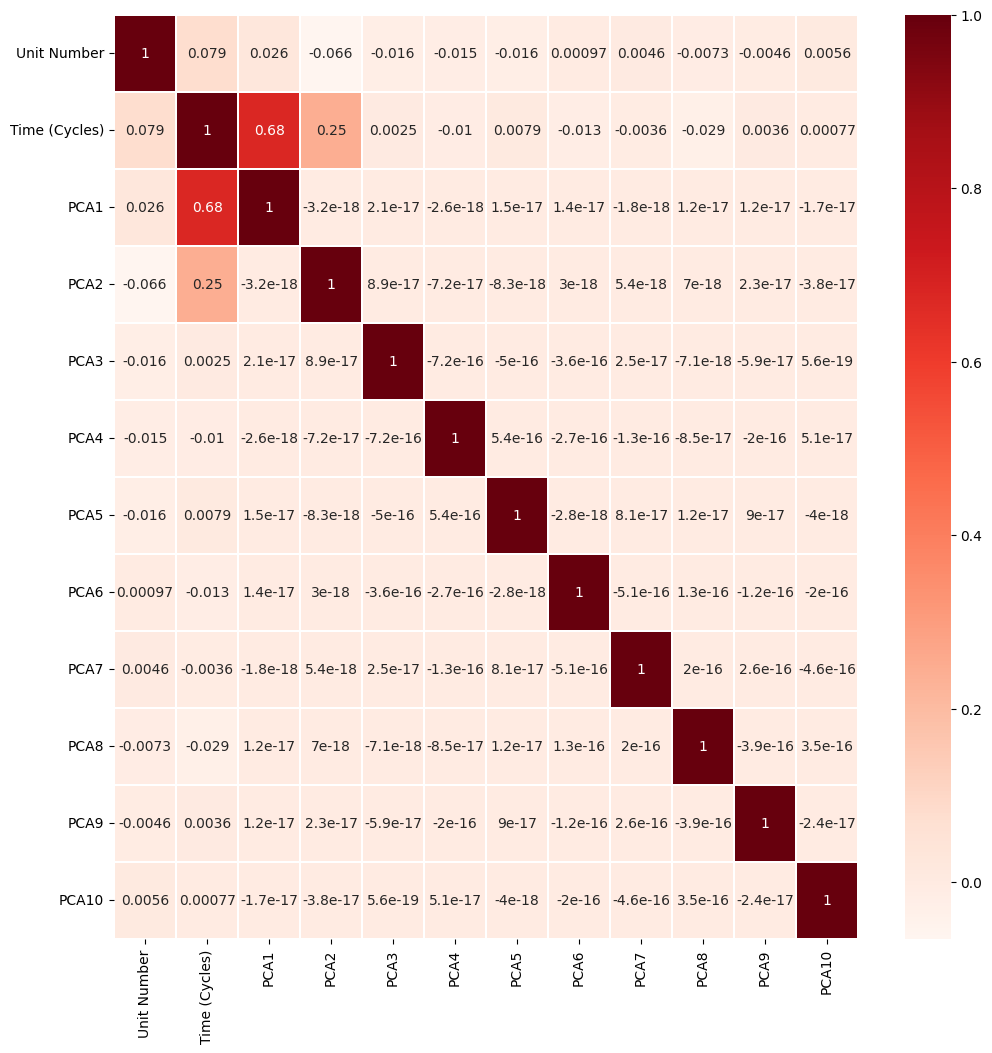



For FD002



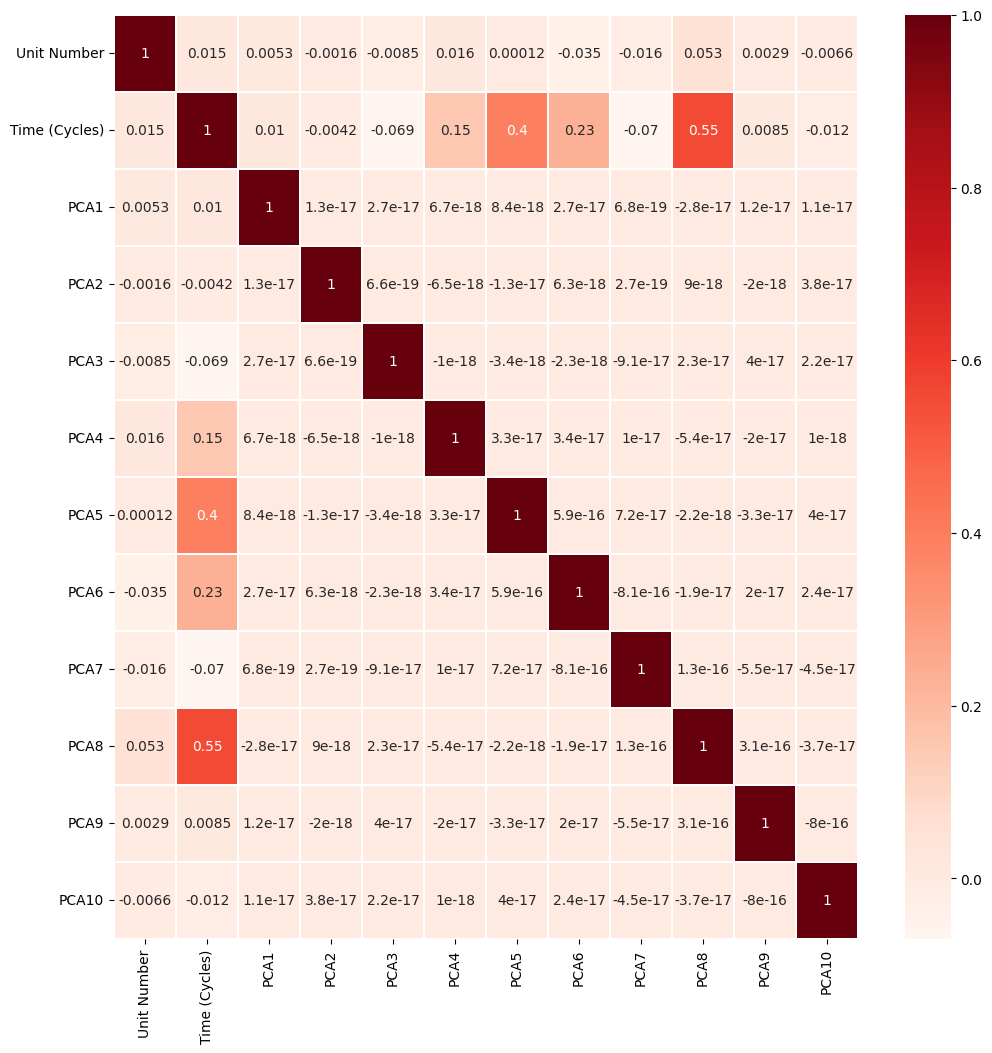



For FD003



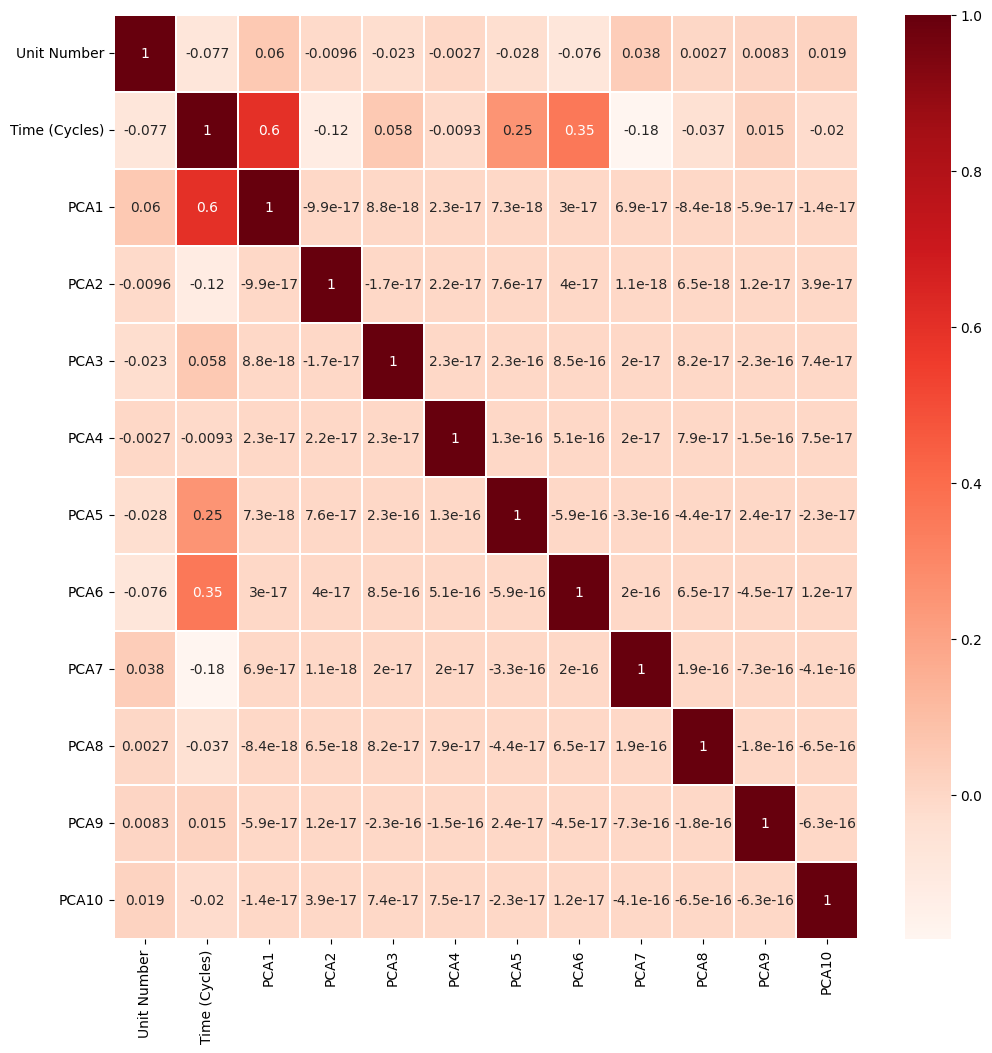



For FD004



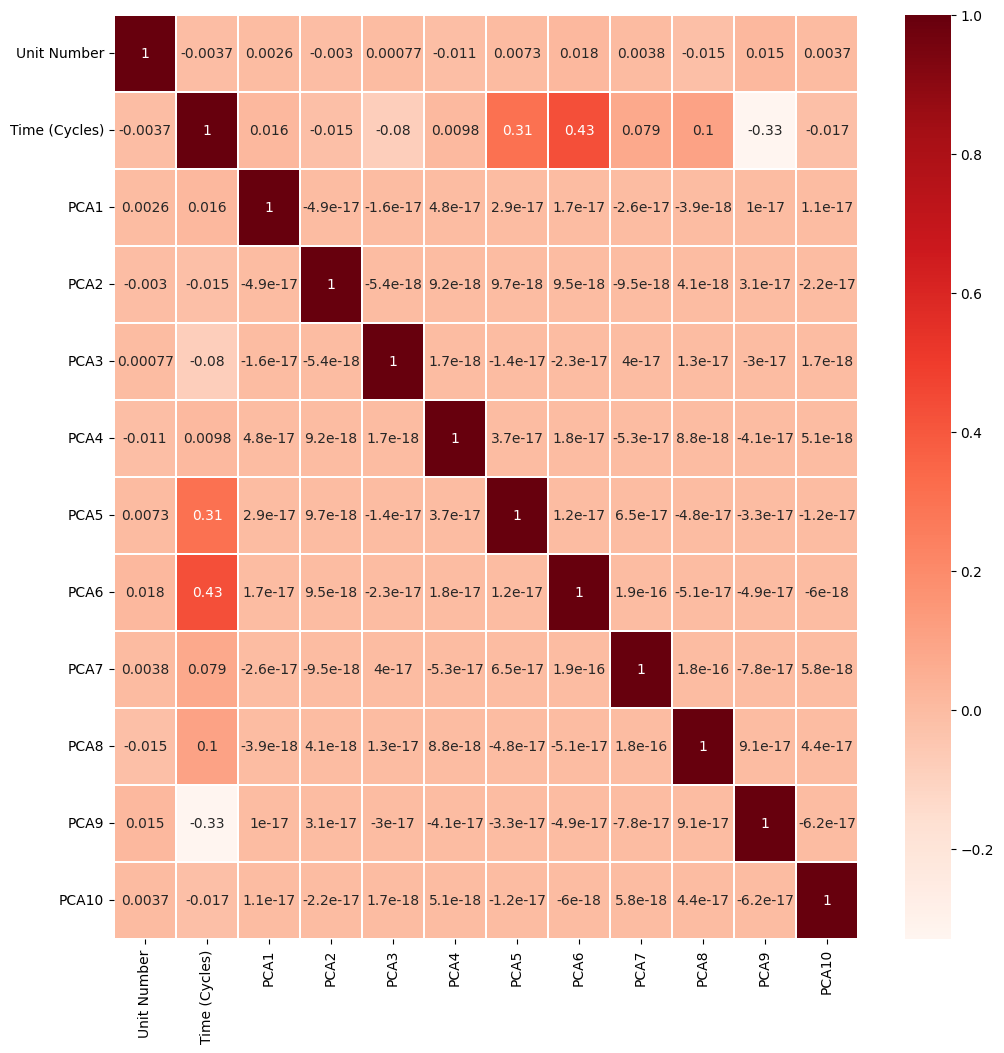

In [30]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    sns.heatmap(trainDatasetsCopy[i].corr(), annot=True, cmap="Reds", linewidths=0.2)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    plt.show()
    print("\n")

In [31]:
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, trainDatasetsUnique[i]+1):
        tempTrainDataset = trainDatasetsCopy[i][trainDatasetsCopy[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        window_size = min(len(tempTrainDataset), defaultWindow)

        tempTrainRulDataset = trainRulDatasets[i][trainRulDatasets[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window = window_size, shift = defaultShift)

        temp1.append(tempTrainDataset)
        temp2.append(tempTrainRulDataset)
        
    processedTrainDatasets.append(np.concatenate(temp1))
    processedTrainRulDatasets.append(np.concatenate(temp2))

In [32]:
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, testDatasetsUnique[i]+1):
        tempTestDataset = testDatasetsCopy[i][testDatasetsCopy[i]['Unit Number'] == j].drop(columns = ['Unit Number']).values

        window_size = min(len(tempTestDataset), defaultWindow)

        tempTestDataset, testWindow = processTestingData(tempTestDataset, window = window_size, shift = defaultShift, testWindow = defaultTestWindow)

        temp1.append(tempTestDataset)
        temp2.append(testWindow)
        
    processedTestDatasets.append(np.concatenate(temp1))
    testWindowList.append(temp2)
    rulDatasets.append(expectedRulDatasetsCopy[i]["Expected RUL"].values)

In [33]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    print("Train Dataset Shape: ", processedTrainDatasets[i].shape)
    print("Train RUL Dataset Shape: ", processedTrainRulDatasets[i].shape)
    print("Test Dataset Shape: ", processedTestDatasets[i].shape)
    print("Expected RUL Shape: ", rulDatasets[i].shape)
    print("\n")

For FD001

Train Dataset Shape:  (19731, 10, 11)
Train RUL Dataset Shape:  (19731,)
Test Dataset Shape:  (1000, 10, 11)
Expected RUL Shape:  (100,)


For FD002

Train Dataset Shape:  (51419, 10, 11)
Train RUL Dataset Shape:  (51419,)
Test Dataset Shape:  (2590, 10, 11)
Expected RUL Shape:  (259,)


For FD003

Train Dataset Shape:  (23820, 10, 11)
Train RUL Dataset Shape:  (23820,)
Test Dataset Shape:  (1000, 10, 11)
Expected RUL Shape:  (100,)


For FD004

Train Dataset Shape:  (59008, 10, 11)
Train RUL Dataset Shape:  (59008,)
Test Dataset Shape:  (2480, 10, 11)
Expected RUL Shape:  (248,)




In [34]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import warnings


In [35]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

def createCNNLSTMModel(shape, name="CNN-LSTM"):
    model = Sequential(name=name)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(shape[1], shape[2])))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model


In [37]:
#  CNN-LSTM model training
trainedModel = []
histories = []
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    name = "FD00" + str(i + 1)
    model = createCNNLSTMModel(processedTrainDatasets[i].shape, name=name)
    display(model.summary())
    history = model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs=100, validation_split=0.2, batch_size=128, verbose=1)
    print("\n")
    trainedModel.append(model)
    histories.append(history)


For FD001



Model: "FD001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,089 (863.63 KB)

 Trainable params: 220,705 (862.13 KB)

 Non-trainable params: 384 (1.50 KB)

None

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 13888.3975 - val_loss: 17118.3906
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 12390.4385 - val_loss: 16357.2266
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 11565.4277 - val_loss: 15693.2910
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 11202.8447 - val_loss: 15071.2070
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10472.7686 - val_loss: 14490.1523
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 10035.5596 - val_loss: 13936.5547
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9637.2041 - val_loss: 13428.7080
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9236.1104 - val_loss: 12907.8926
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8703.9326 - val_loss: 12427.0068
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8577.1592 - val_loss: 11968.0049
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2

Model: "FD002"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,089 (863.63 KB)

 Trainable params: 220,705 (862.13 KB)

 Non-trainable params: 384 (1.50 KB)

None

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 14209.3164 - val_loss: 12330.8535
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 12212.9717 - val_loss: 10957.1523
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 11068.0918 - val_loss: 9751.9648
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9699.3564 - val_loss: 8697.9307
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 8644.3223 - val_loss: 7766.9219
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 7890.4170 - val_loss: 6938.5229
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6943.0459 - val_loss: 6201.2856
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6174.9819 - val_loss: 5548.5801
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5637.6865 - val_loss: 4973.7266
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5027.0854 - val_loss: 4463.7002
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

Model: "FD003"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,089 (863.63 KB)

 Trainable params: 220,705 (862.13 KB)

 Non-trainable params: 384 (1.50 KB)

None

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 26524.2715 - val_loss: 26150.2617
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 24427.5566 - val_loss: 24922.1426
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 23495.1738 - val_loss: 23976.2461
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 21872.9609 - val_loss: 23088.8750
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 21452.4629 - val_loss: 22248.7988
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 20597.2598 - val_loss: 21447.5664
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 19964.8574 - val_loss: 20681.8379
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 19173.6426 - val_loss: 19951.5234
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 18717.6035 - val_loss: 19247.0605
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 17795.9805 - val_loss: 18574.0801
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━━

Model: "FD004"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,089 (863.63 KB)

 Trainable params: 220,705 (862.13 KB)

 Non-trainable params: 384 (1.50 KB)

None

Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 23224.8730 - val_loss: 18692.4570
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 20144.5898 - val_loss: 16774.5469
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 18425.8496 - val_loss: 15068.9521
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 16763.5586 - val_loss: 13551.4414
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 15037.0654 - val_loss: 12190.4287
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 13660.3652 - val_loss: 10973.9727
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 12326.6621 - val_loss: 9883.0596
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 11164.4453 - val_loss: 8905.4434
Epoch 9/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 10193.0488 - val_loss: 8031.1030
Epoch 10/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 9429.3594 - val_loss: 7250.4062
Epoch 11/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6

In [38]:
# Predict RUL with the CNN-LSTM model
predictedRulDatasets = []
for i in range(4):
    predictedRul = trainedModel[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul = np.split(predictedRul, np.cumsum(testWindowList[i])[:-1])
    predictedRul = [np.average(ruls, weights=np.repeat(1 / testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList[i])]

    predictedRulDatasets.append(predictedRul)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [39]:
# Calculate RMSE and R2 score
rmseList = []
r2_scoreList = []
for i in range(4):
    rmse = np.sqrt(mse(rulDatasets[i], predictedRulDatasets[i]))
    print("For FD00" + str(i + 1))
    print("Root Mean Square Error:", rmse)
    print("\n")
    rmseList.append(rmse)

for i in range(4):
    r2_sc = r2_score(rulDatasets[i], predictedRulDatasets[i])
    print("For FD00" + str(i + 1))
    print("R2 Score:", r2_sc)
    print("\n")
    r2_scoreList.append(r2_sc)


For FD001
Root Mean Square Error: 27.23074377158614


For FD002
Root Mean Square Error: 32.474507979475206


For FD003
Root Mean Square Error: 33.6557078244943


For FD004
Root Mean Square Error: 40.4477776610732


For FD001
R2 Score: 0.5706025478972022


For FD002
R2 Score: 0.6353610653607643


For FD003
R2 Score: 0.3389891132155374


For FD004
R2 Score: 0.4496775803949128




For FD001



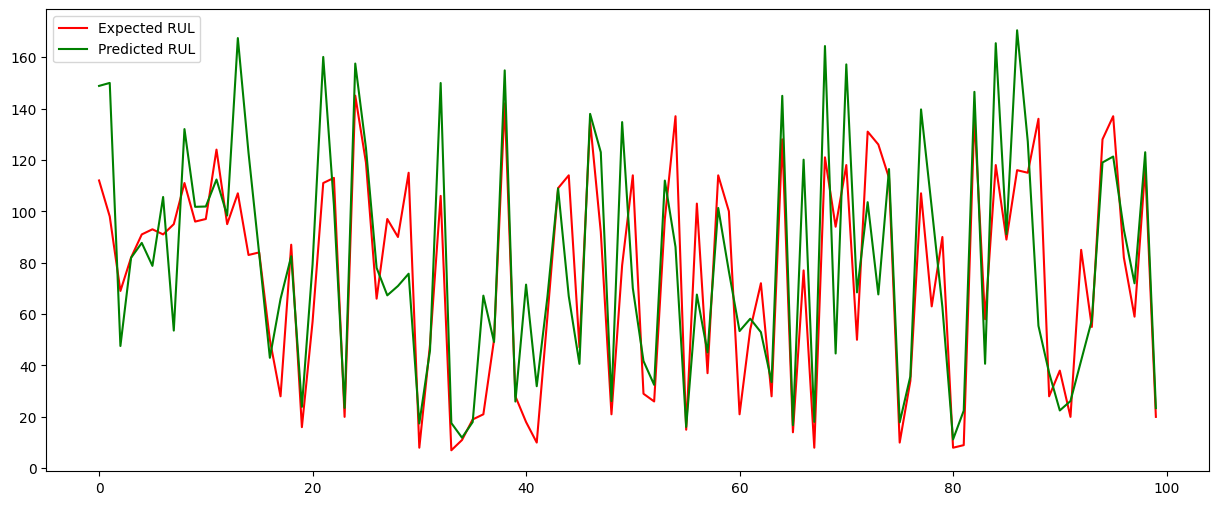



For FD002



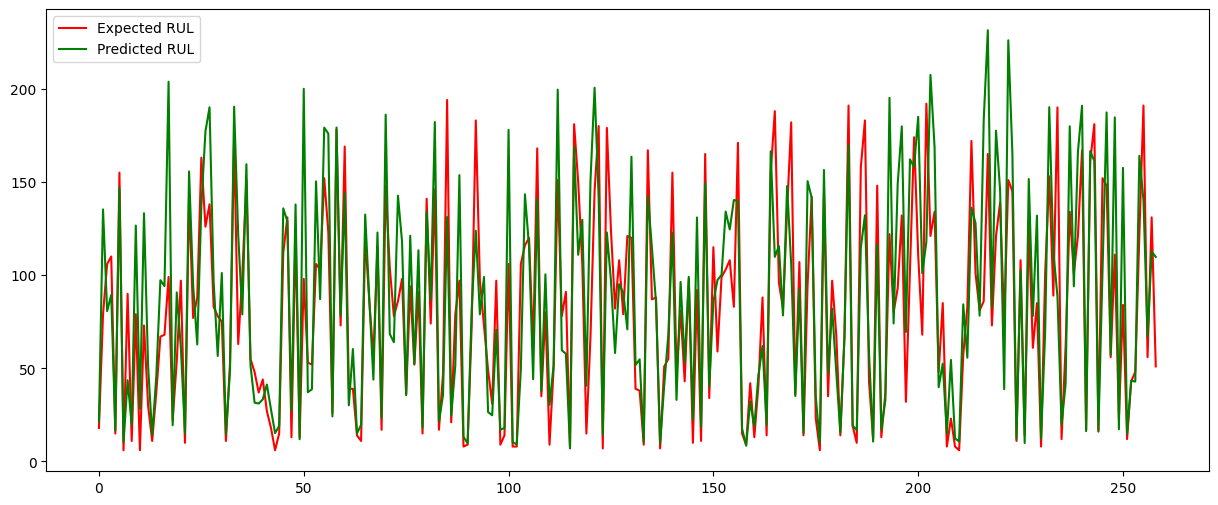



For FD003



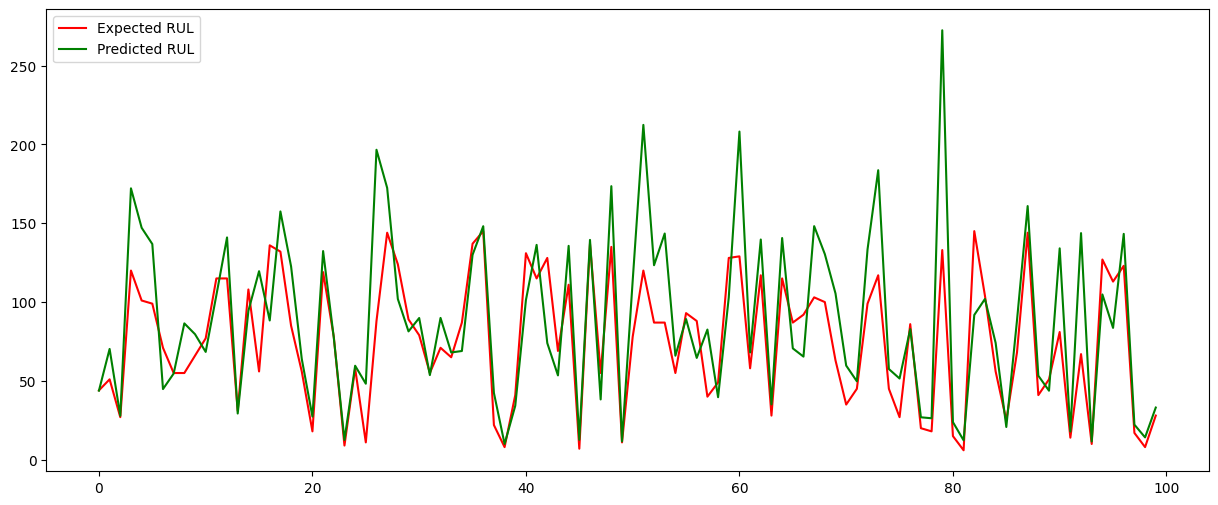



For FD004



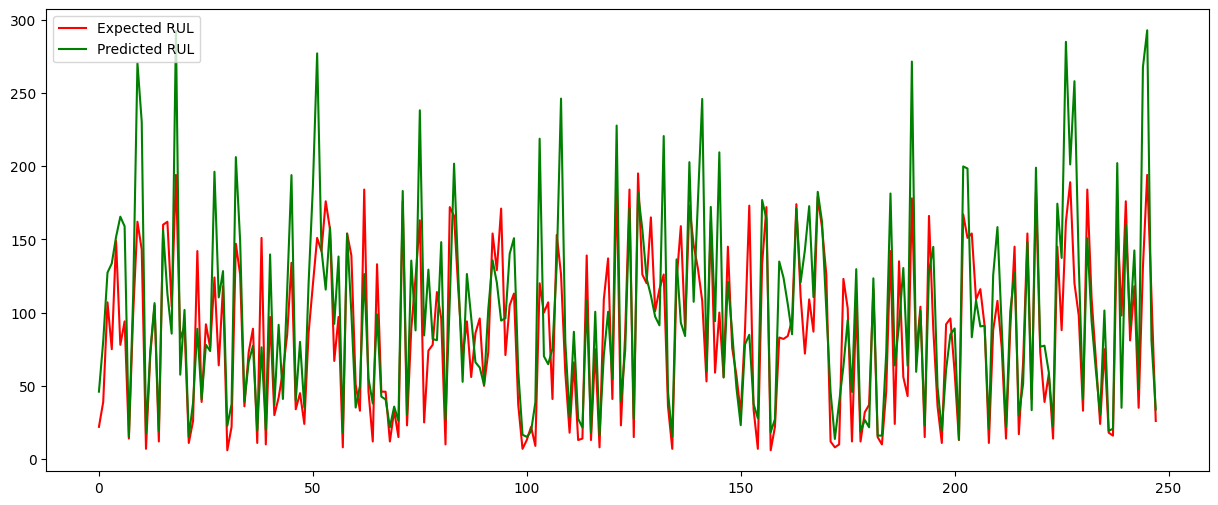



For FD001



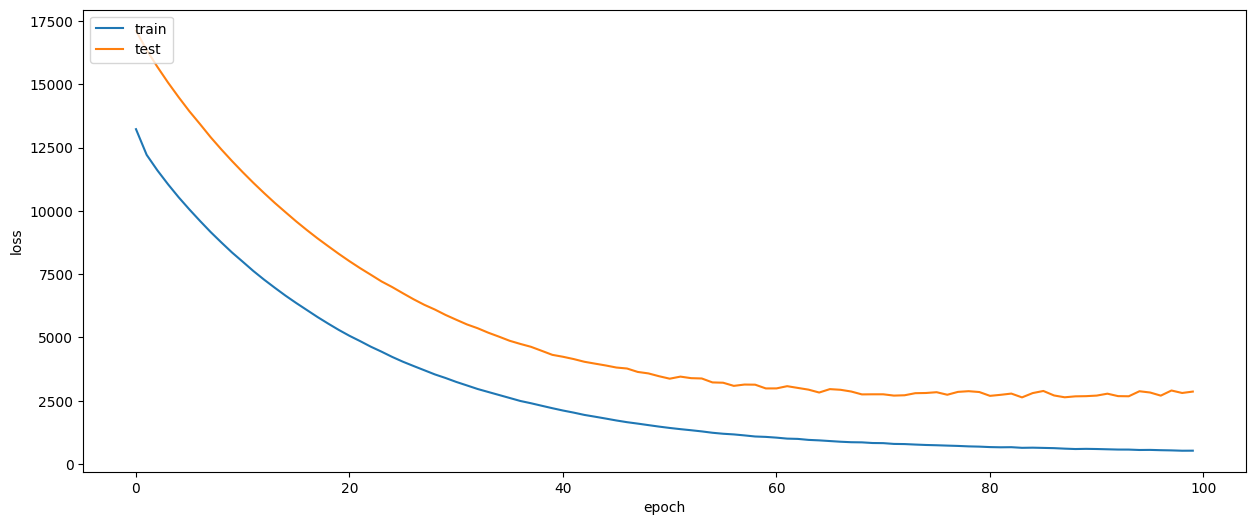



For FD002



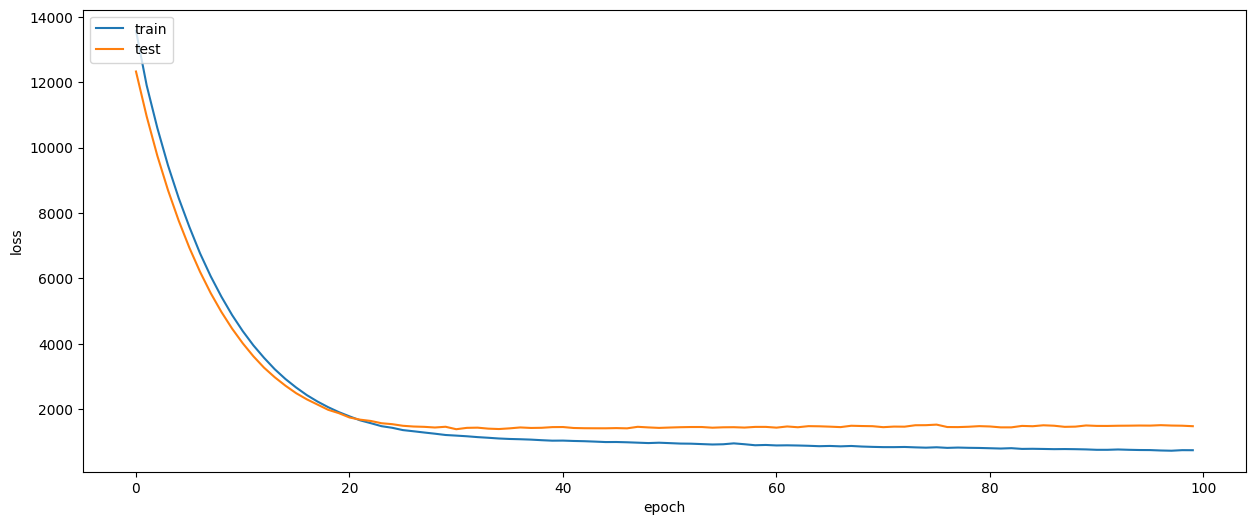



For FD003



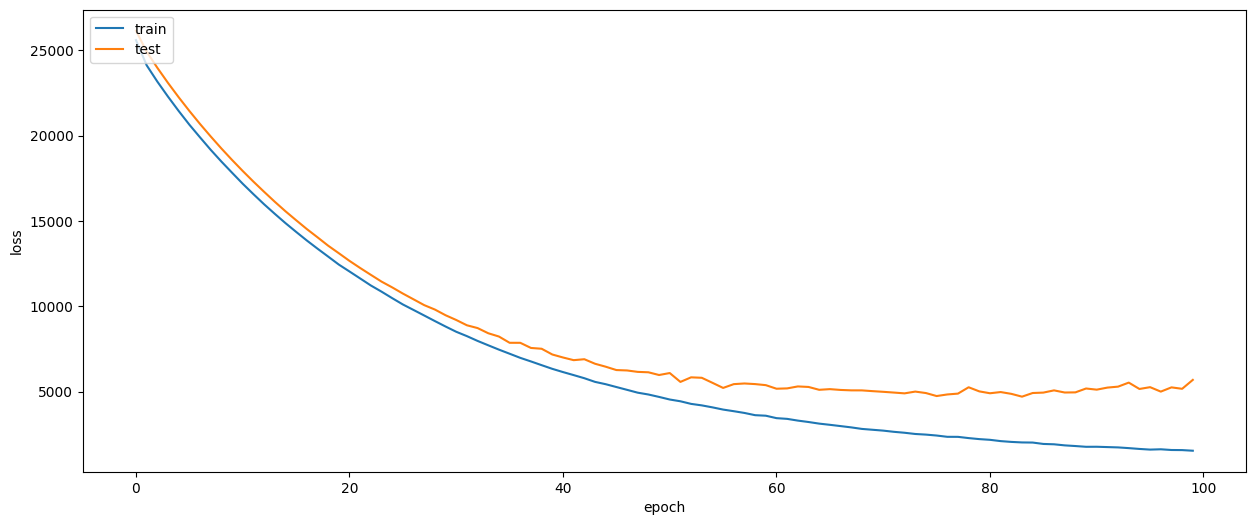



For FD004



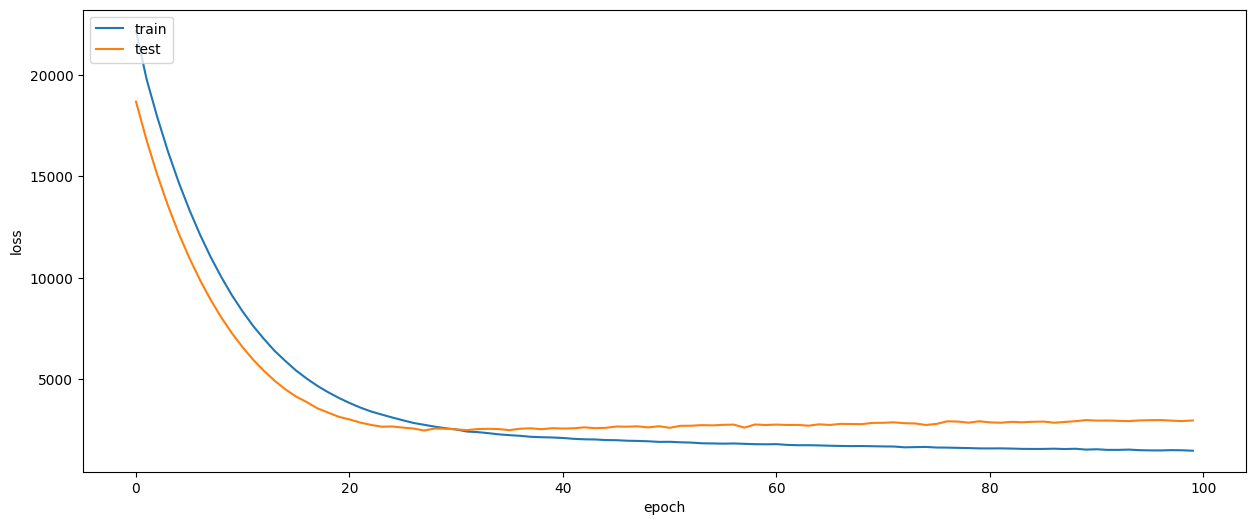

In [40]:
# Plot the results
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(predictedRulDatasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

# Plot the training loss
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print("\n")


For FD001



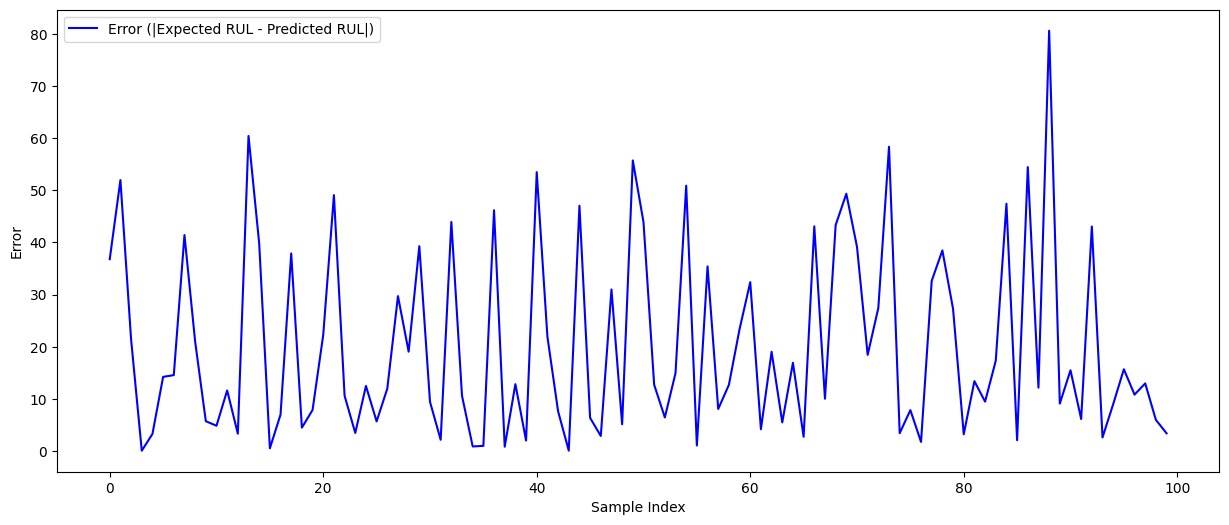



For FD002



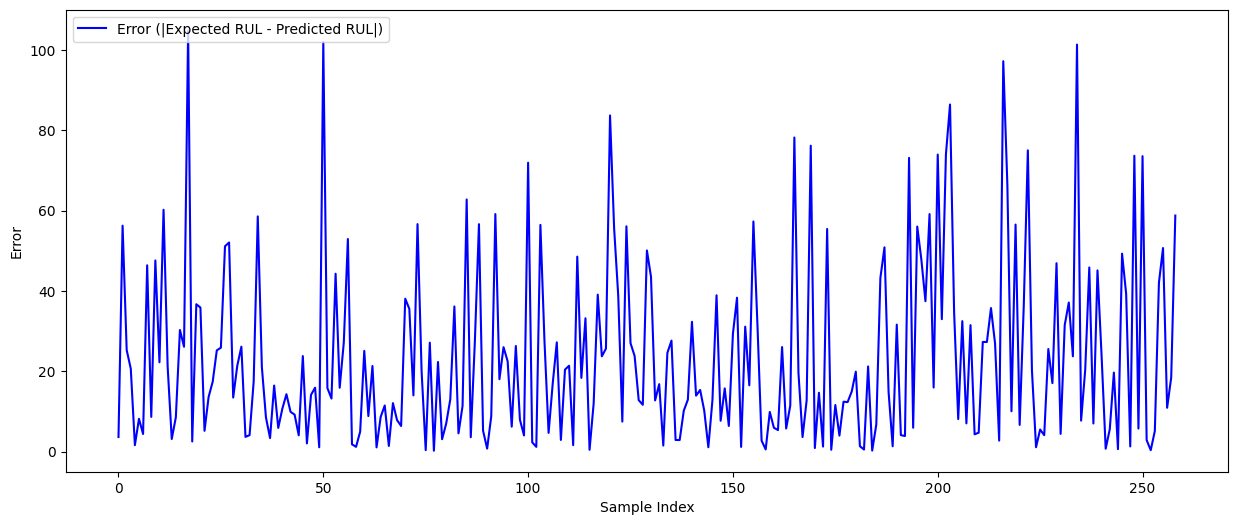



For FD003



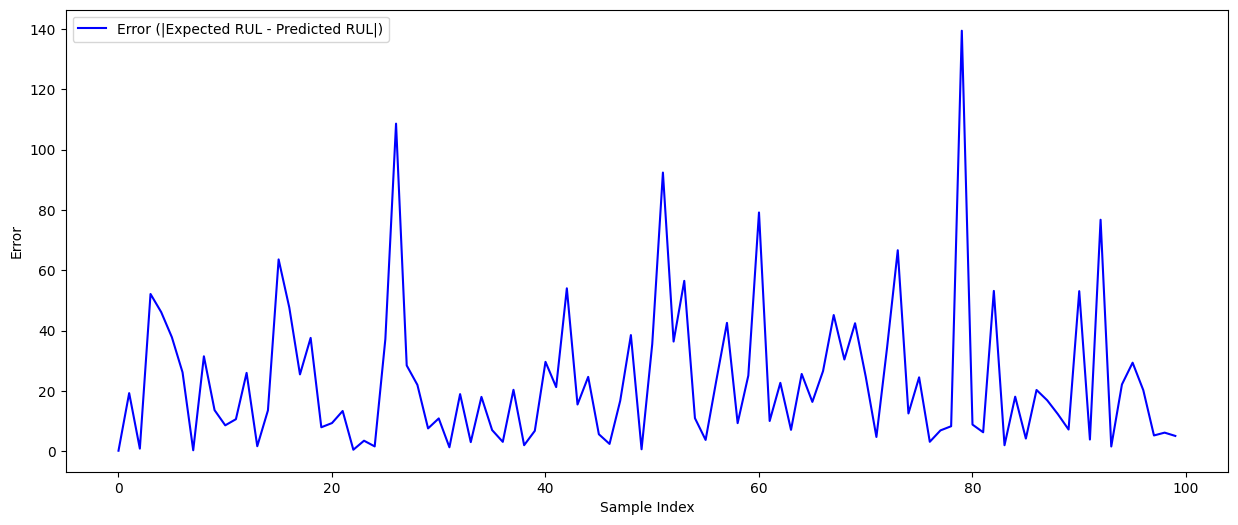



For FD004



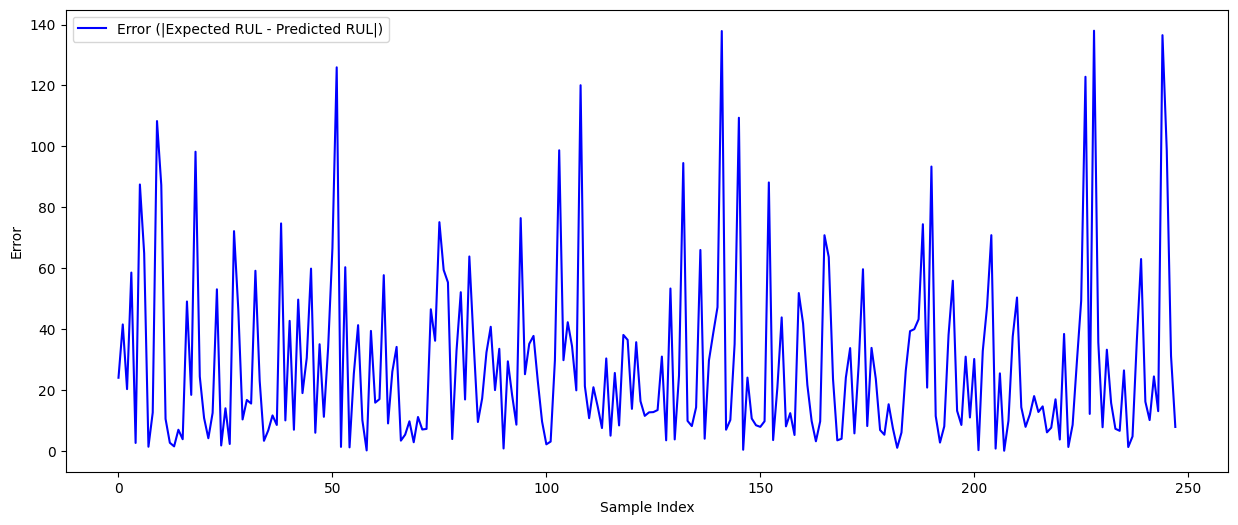

In [41]:
# Plot the error (module of evolution of the difference between predicted and expected RUL)
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    error = np.abs(np.array(rulDatasets[i]) - np.array(predictedRulDatasets[i]))
    plt.figure(figsize=(15, 6))
    plt.plot(error, label="Error (|Expected RUL - Predicted RUL|)", color="Blue")
    plt.ylabel('Error')
    plt.xlabel('Sample Index')
    plt.legend(loc='upper left')
    plt.show()
    print("\n")


In [42]:
# Add the necessary imports for Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
# After defining the createModel function, add a new function for Gradient Boosting model creation
def createGBModel():
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=34)
    return gb_model

In [44]:
#  GB models
gb_models = []
for i in range(4):
    print("For FD00" + str(i+1) + " Gradient Boosting Model\n")
    gb_model = createGBModel()
    # Flatten the training data for Gradient Boosting
    X_train = processedTrainDatasets[i].reshape(processedTrainDatasets[i].shape[0], -1)
    gb_model.fit(X_train, processedTrainRulDatasets[i])
    gb_models.append(gb_model)

For FD001 Gradient Boosting Model

For FD002 Gradient Boosting Model

For FD003 Gradient Boosting Model

For FD004 Gradient Boosting Model



In [45]:
#  predicting RUL using the trained GB models
gb_predictedRulDatasets = []
for i in range(4):
    X_test = processedTestDatasets[i].reshape(processedTestDatasets[i].shape[0], -1)
    gb_predictedRul = gb_models[i].predict(X_test)
    gb_predictedRul = np.split(gb_predictedRul, np.cumsum(testWindowList[i])[:-1])
    gb_predictedRul = [np.average(ruls, weights=np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(gb_predictedRul, testWindowList[i])]
    gb_predictedRulDatasets.append(gb_predictedRul)

In [46]:
# Add this part where you are calculating RMSE and R2 score for GB models
gb_rmseList = []
gb_r2_scoreList = []
for i in range(4):
    gb_rmse = np.sqrt(mse(rulDatasets[i], gb_predictedRulDatasets[i]))
    print("For FD00" + str(i+1) + " Gradient Boosting Model")
    print("Root Mean Square Error:", gb_rmse)
    print("\n")
    gb_rmseList.append(gb_rmse)

    gb_r2_sc = r2_score(rulDatasets[i], gb_predictedRulDatasets[i])
    print("For FD00" + str(i+1) + " Gradient Boosting Model")
    print("R2 Score:", gb_r2_sc)
    print("\n")
    gb_r2_scoreList.append(gb_r2_sc)

For FD001 Gradient Boosting Model
Root Mean Square Error: 28.180225705633074


For FD001 Gradient Boosting Model
R2 Score: 0.5401360236925687


For FD002 Gradient Boosting Model
Root Mean Square Error: 29.808658017412473


For FD002 Gradient Boosting Model
R2 Score: 0.692770631267371


For FD003 Gradient Boosting Model
Root Mean Square Error: 40.99767066419414


For FD003 Gradient Boosting Model
R2 Score: 0.01913436393134249


For FD004 Gradient Boosting Model
Root Mean Square Error: 41.08515774004304


For FD004 Gradient Boosting Model
R2 Score: 0.43219685542480635




For FD001 Gradient Boosting Model



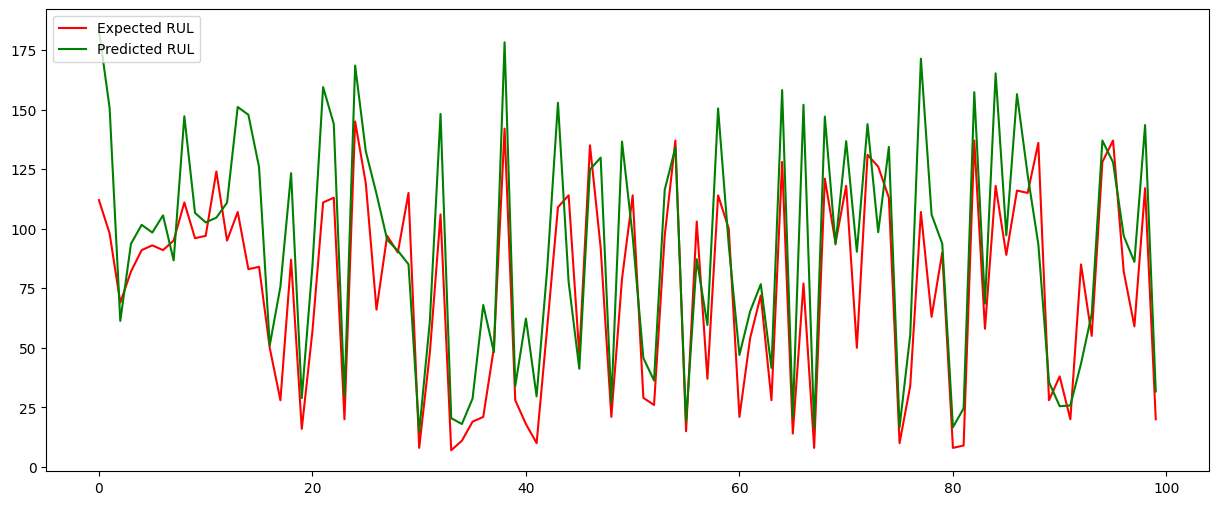



For FD002 Gradient Boosting Model



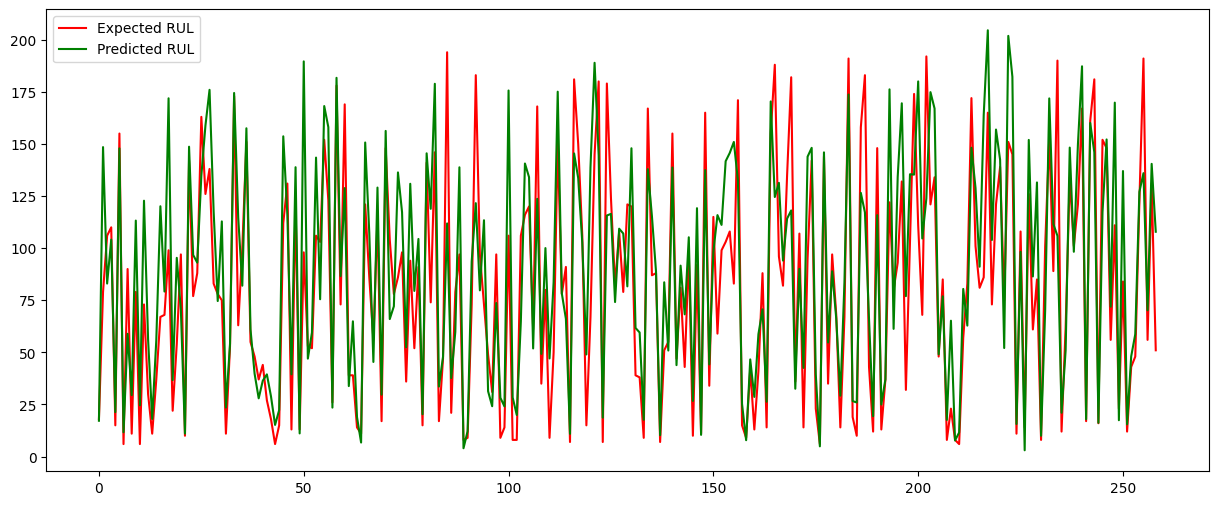



For FD003 Gradient Boosting Model



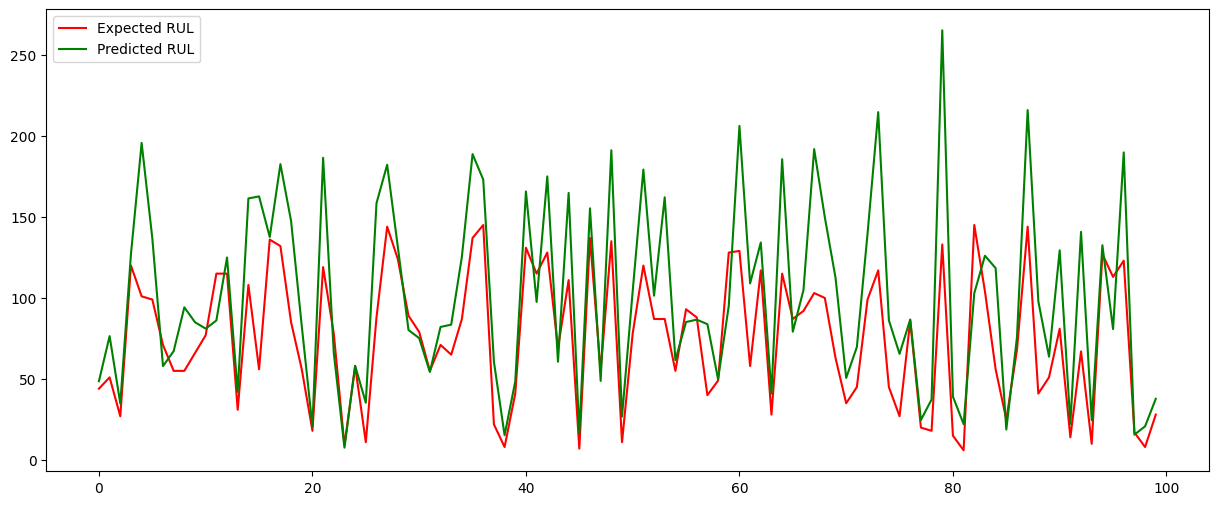



For FD004 Gradient Boosting Model



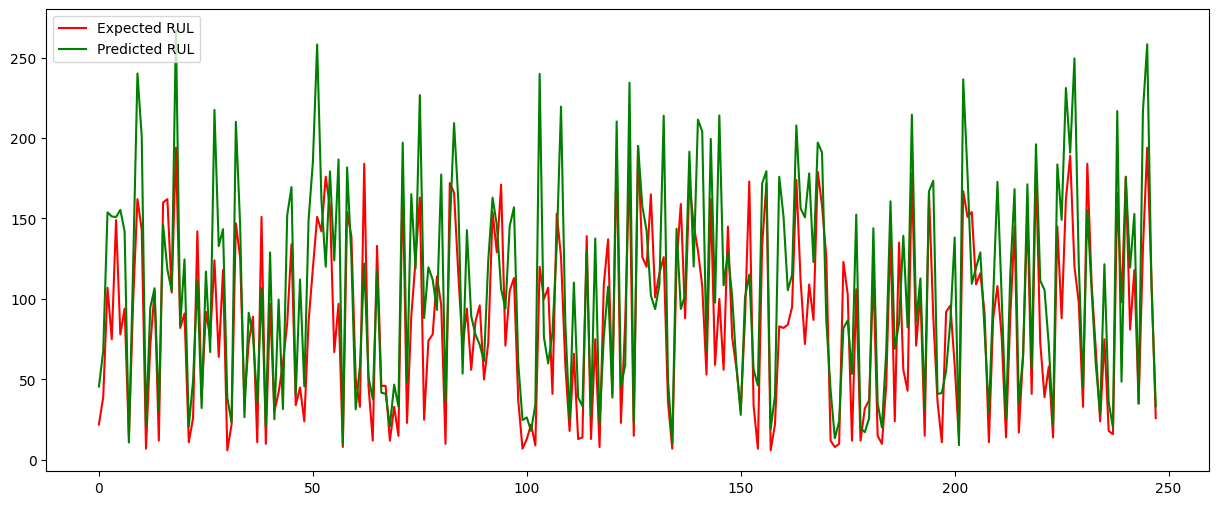

In [47]:
# Add this part where you are plotting results for GB models
for i in range(4):
    print("For FD00" + str(i+1) + " Gradient Boosting Model\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(gb_predictedRulDatasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

For FD001 Gradient Boosting Model Absolute Error



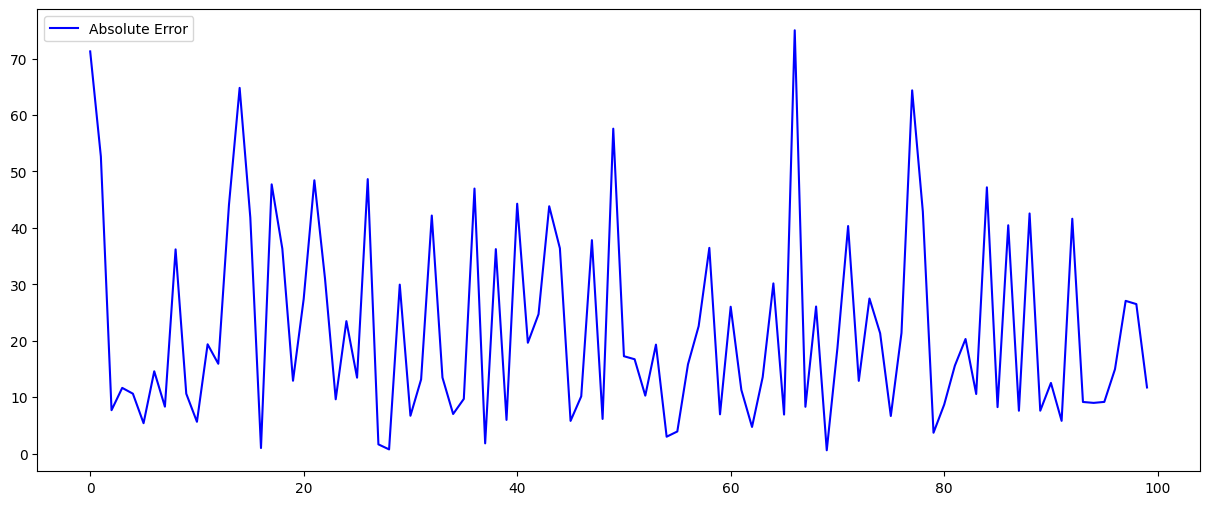



For FD002 Gradient Boosting Model Absolute Error



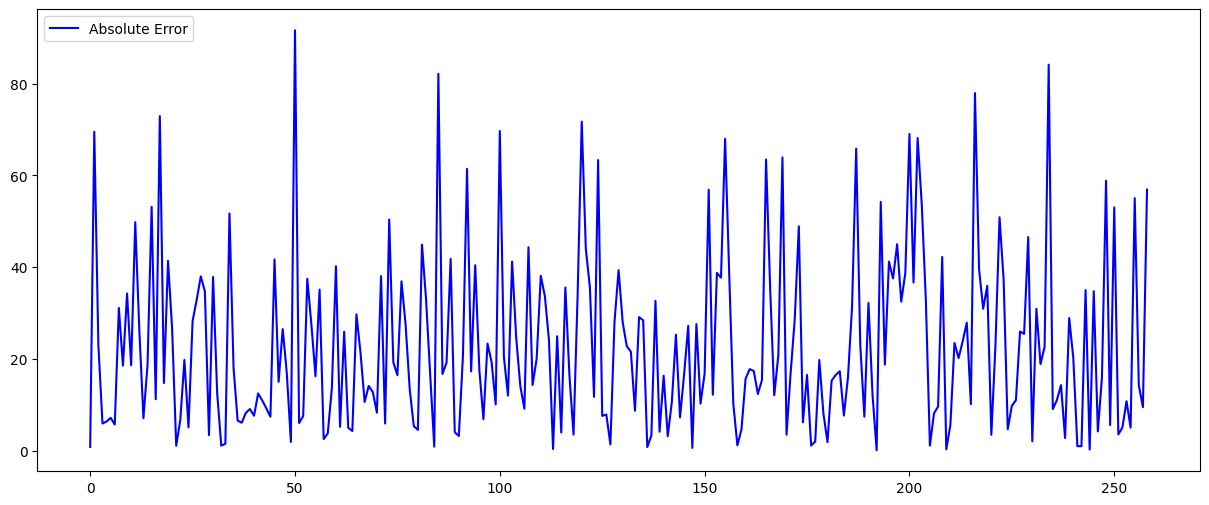



For FD003 Gradient Boosting Model Absolute Error



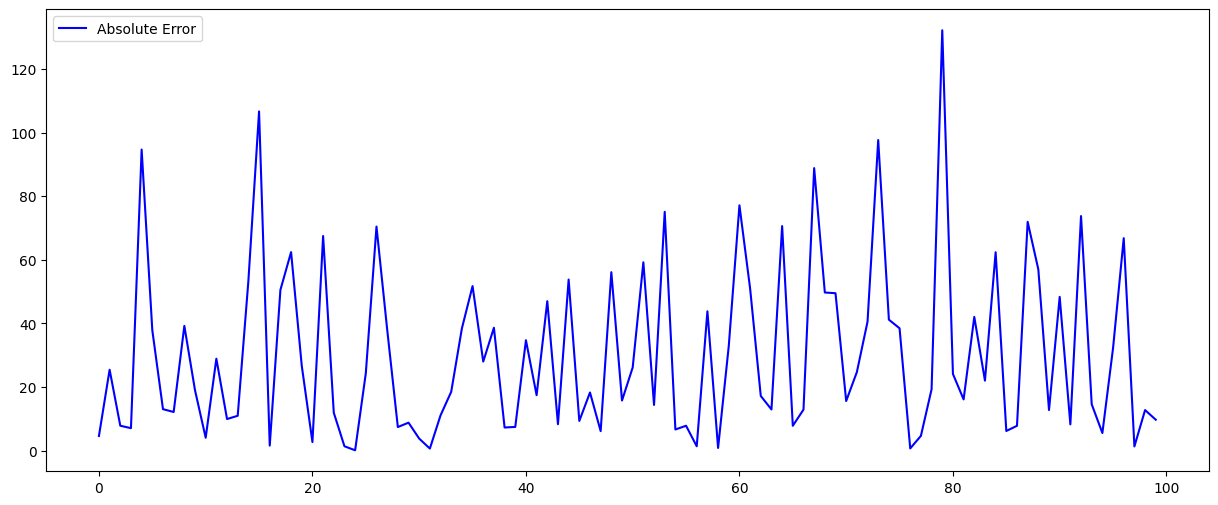



For FD004 Gradient Boosting Model Absolute Error



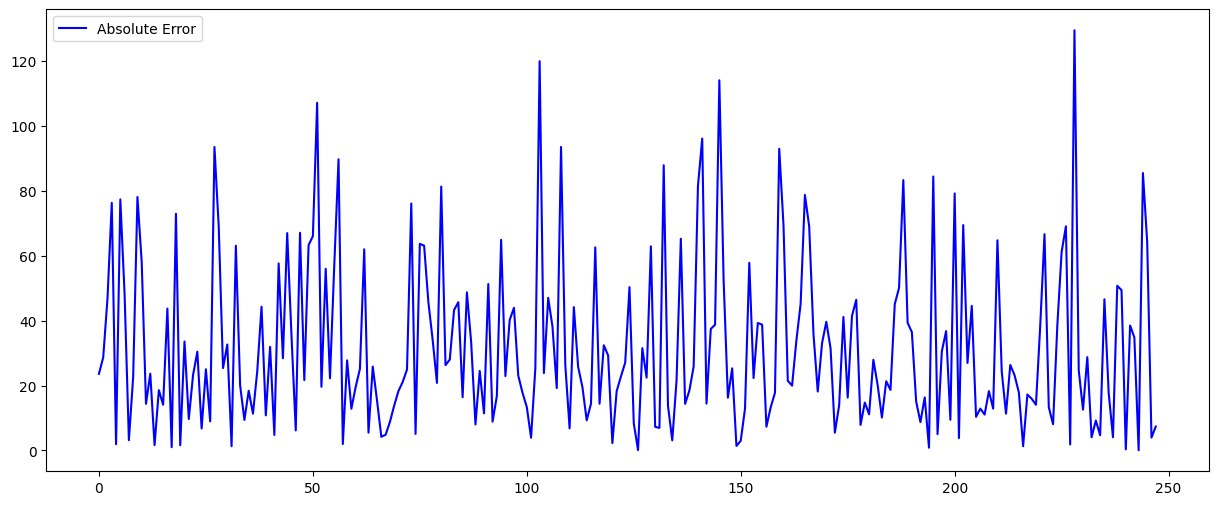

In [48]:

# Plotting absolute error between predicted and expected RUL
for i in range(4):
    print("For FD00" + str(i+1) + " Gradient Boosting Model Absolute Error\n")
    plt.figure(figsize=(15, 6))
    absolute_error = np.abs(np.array(rulDatasets[i]) - np.array(gb_predictedRulDatasets[i]))
    plt.plot(absolute_error, label="Absolute Error", color="Blue")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

In [49]:
# Add the necessary imports for SVM
from sklearn.svm import SVR

In [50]:
# After defining the createModel function, add a new function for SVM model creation
def createSVMModel():
    svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    return svm_model

In [51]:
# Add this part where you have defined and trained SVM models
svm_models = []
for i in range(4):
    print("For FD00" + str(i+1) + " SVM Model\n")
    svm_model = createSVMModel()
    # Flatten the training data for SVM
    X_train = processedTrainDatasets[i].reshape(processedTrainDatasets[i].shape[0], -1)
    svm_model.fit(X_train, processedTrainRulDatasets[i])
    svm_models.append(svm_model)

For FD001 SVM Model

For FD002 SVM Model

For FD003 SVM Model

For FD004 SVM Model



In [52]:
# Add this part where you are predicting RUL using the trained SVM models
svm_predictedRulDatasets = []
for i in range(4):
    X_test = processedTestDatasets[i].reshape(processedTestDatasets[i].shape[0], -1)
    svm_predictedRul = svm_models[i].predict(X_test)
    svm_predictedRul = np.split(svm_predictedRul, np.cumsum(testWindowList[i])[:-1])
    svm_predictedRul = [np.average(ruls, weights=np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(svm_predictedRul, testWindowList[i])]
    svm_predictedRulDatasets.append(svm_predictedRul)

In [53]:
# Add this part where you are calculating RMSE and R2 score for SVM models
svm_rmseList = []
svm_r2_scoreList = []
for i in range(4):
    svm_rmse = np.sqrt(mse(rulDatasets[i], svm_predictedRulDatasets[i]))
    print("For FD00" + str(i+1) + " SVM Model")
    print("Root Mean Square Error:", svm_rmse)
    print("\n")
    svm_rmseList.append(svm_rmse)

    svm_r2_sc = r2_score(rulDatasets[i], svm_predictedRulDatasets[i])
    print("For FD00" + str(i+1) + " SVM Model")
    print("R2 Score:", svm_r2_sc)
    print("\n")
    svm_r2_scoreList.append(svm_r2_sc)

For FD001 SVM Model
Root Mean Square Error: 48.18296730336807


For FD001 SVM Model
R2 Score: -0.34439701651904553


For FD002 SVM Model
Root Mean Square Error: 56.547186095168186


For FD002 SVM Model
R2 Score: -0.10560469978311926


For FD003 SVM Model
Root Mean Square Error: 57.79465181396753


For FD003 SVM Model
R2 Score: -0.9492451310026


For FD004 SVM Model
Root Mean Square Error: 62.183368387793905


For FD004 SVM Model
R2 Score: -0.30069767189514196




For FD001 SVM Model



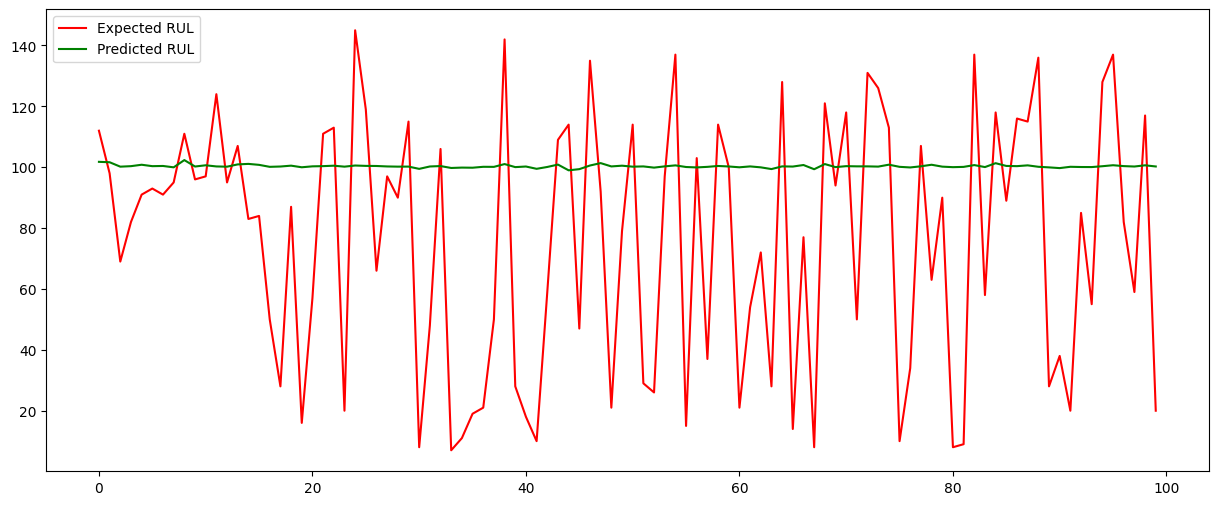



For FD002 SVM Model



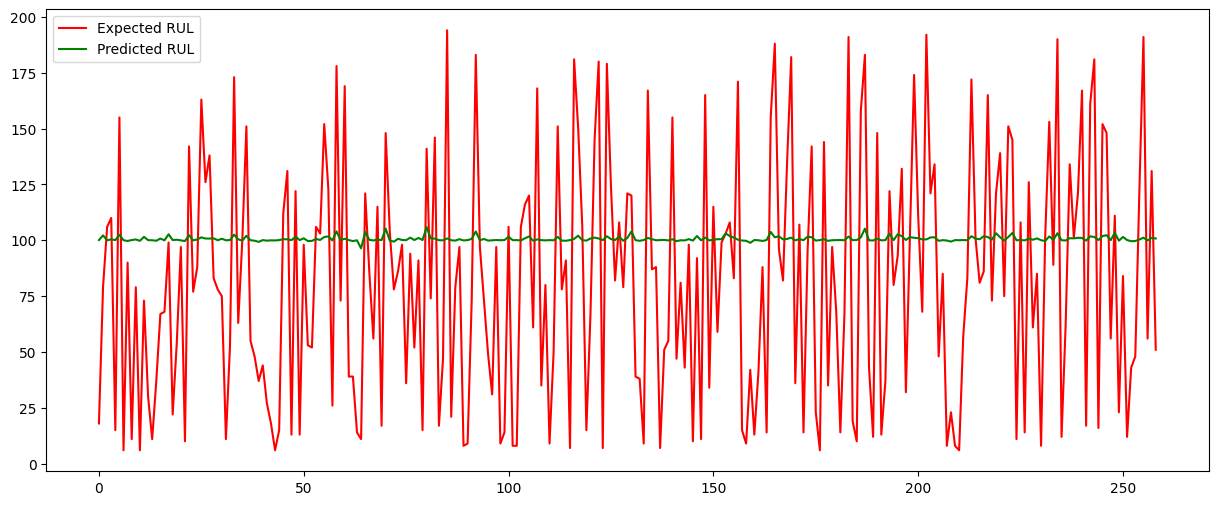



For FD003 SVM Model



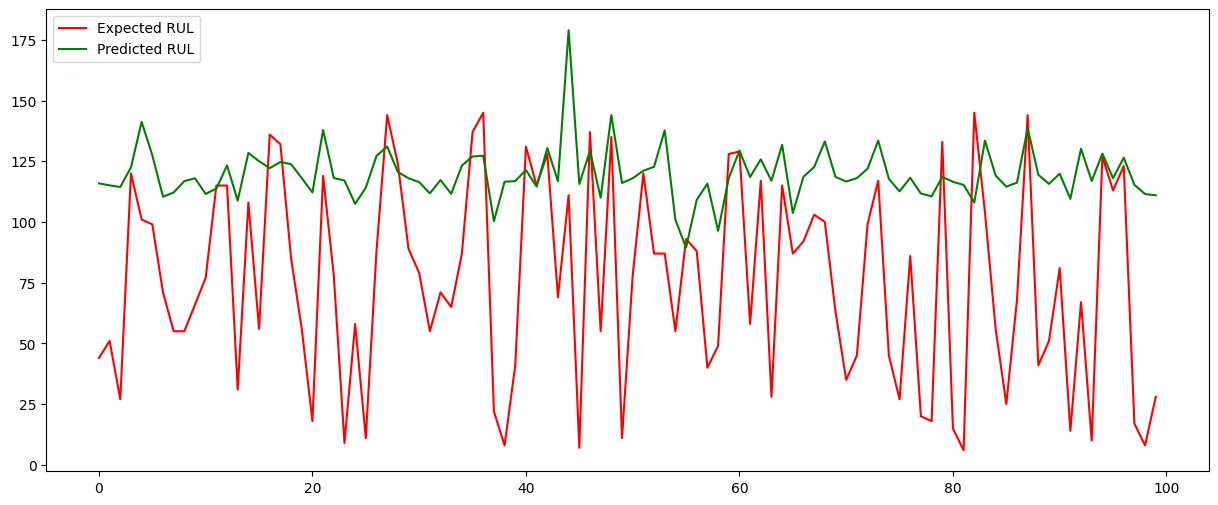



For FD004 SVM Model



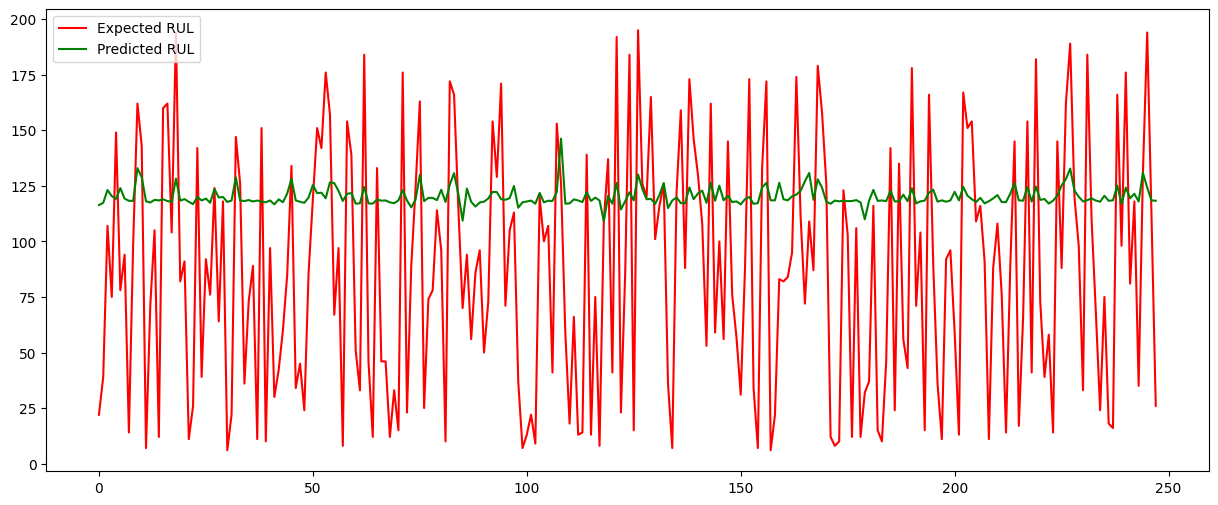

In [54]:
for i in range(4):
    print("For FD00" + str(i+1) + " SVM Model\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(svm_predictedRulDatasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

For FD001 SVM Model Absolute Error



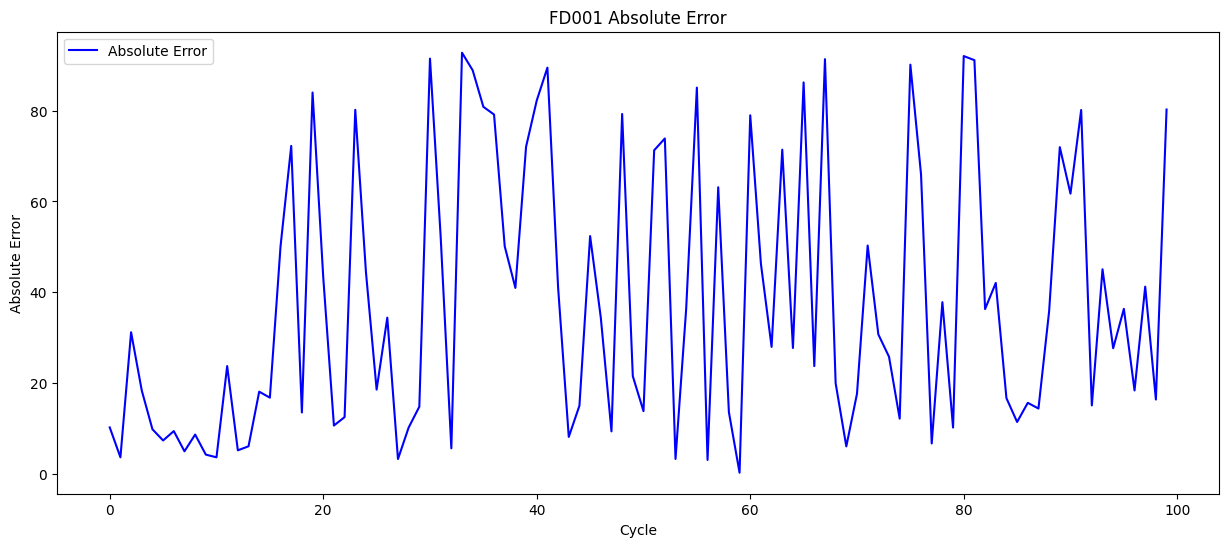



For FD002 SVM Model Absolute Error



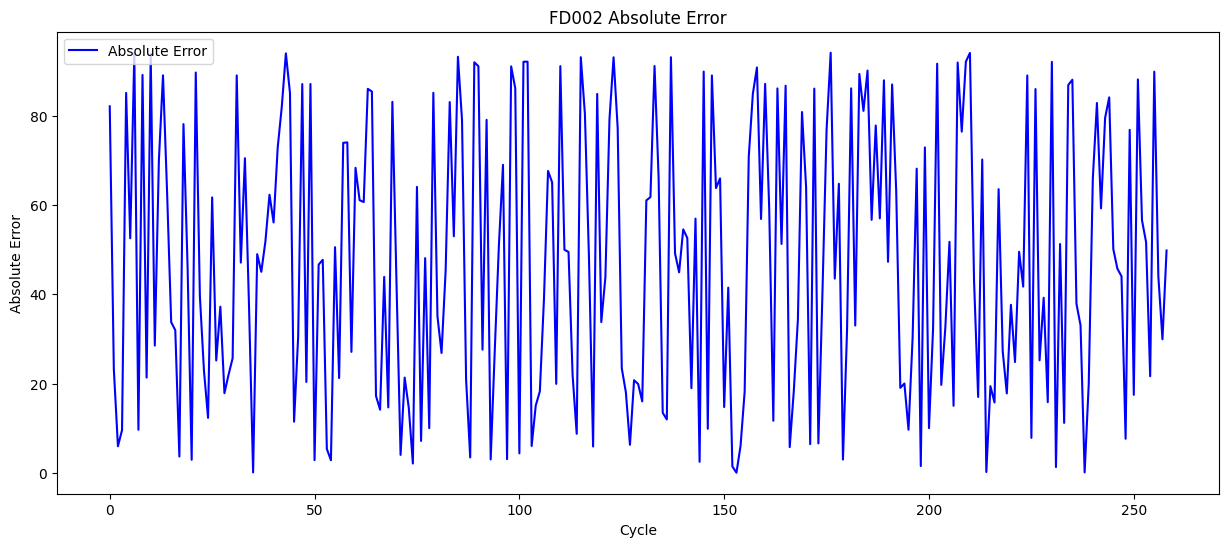



For FD003 SVM Model Absolute Error



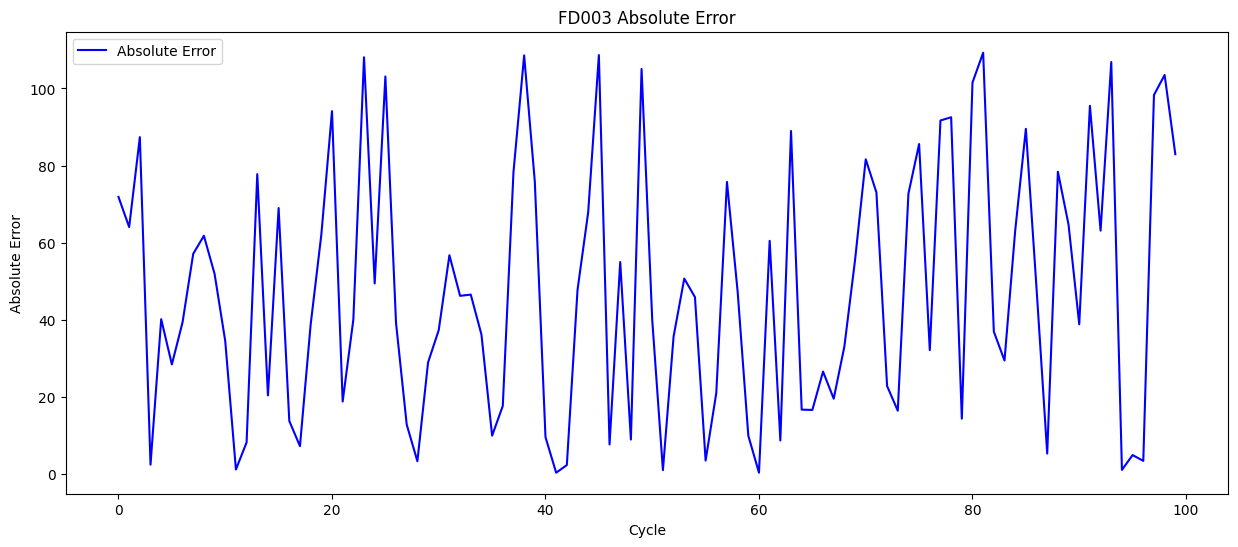



For FD004 SVM Model Absolute Error



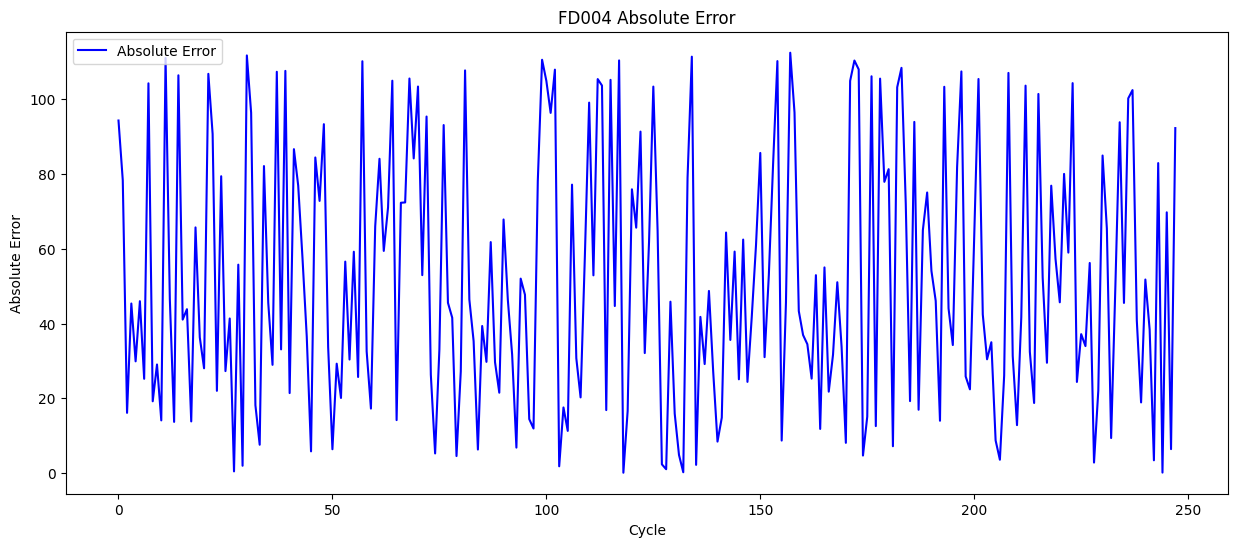

In [55]:
# Plotting absolute error between predicted and expected RUL
for i in range(4):
    print("For FD00" + str(i+1) + " SVM Model Absolute Error\n")
    plt.figure(figsize=(15, 6))
    absolute_error = np.abs(np.array(rulDatasets[i]) - np.array(svm_predictedRulDatasets[i]))
    plt.plot(absolute_error, label="Absolute Error", color="Blue")
    plt.legend(loc='upper left')
    plt.title(f"FD00{i+1} Absolute Error")
    plt.xlabel("Cycle")
    plt.ylabel("Absolute Error")
    plt.show()
    print("\n")

In [56]:
#CNN model

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [57]:
def createCNNModel(shape, name="CNN_Model"):
    model = Sequential(name=name)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(shape[1], shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [58]:
# Train the CNN model for each dataset
cnn_trained_models = []
cnn_histories = []

for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    name = "CNN_FD00" + str(i + 1)
    cnn_model = createCNNModel(processedTrainDatasets[i].shape, name=name)
    display(cnn_model.summary())
    cnn_history = cnn_model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs=100, validation_split=0.2, batch_size=128, verbose=1)
    print("\n")
    cnn_trained_models.append(cnn_model)
    cnn_histories.append(cnn_history)

For FD001



Model: "CNN_FD001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,201 (137.50 KB)

 Trainable params: 35,201 (137.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7791.6230 - val_loss: 2734.5037
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1199.5979 - val_loss: 2643.1221
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1164.8105 - val_loss: 2496.8257
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1038.6613 - val_loss: 2681.9971
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 982.5406 - val_loss: 2350.9836
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 909.7455 - val_loss: 2499.6597
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 937.9375 - val_loss: 2330.0784
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 919.9389 - val_loss: 2286.9617
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 898.3479 - val_loss: 2354.4561
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 877.0262 - val_loss: 2255.8643
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 799.7839 - va

Model: "CNN_FD002"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,201 (137.50 KB)

 Trainable params: 35,201 (137.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5005.0425 - val_loss: 1455.7375
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1374.4572 - val_loss: 1333.0508
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1283.0728 - val_loss: 1351.2629
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1271.7480 - val_loss: 1321.2606
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1213.6982 - val_loss: 1305.0697
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1182.0559 - val_loss: 1298.0280
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1160.2015 - val_loss: 1305.4386
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1133.1494 - val_loss: 1346.8840
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1086.8253 - val_loss: 1335.0999
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1067.6343 - val_loss: 1398.5452
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1058.30

Model: "CNN_FD003"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,201 (137.50 KB)

 Trainable params: 35,201 (137.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 15276.7568 - val_loss: 4579.3726
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2887.8052 - val_loss: 4664.9595
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2736.2769 - val_loss: 4489.7520
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2648.9014 - val_loss: 4444.0312
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2488.6072 - val_loss: 4473.7520
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2336.3555 - val_loss: 4267.6509
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2313.8259 - val_loss: 4299.6880
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2137.8828 - val_loss: 4520.2407
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2091.9072 - val_loss: 4796.1597
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2079.6868 - val_loss: 4494.7500
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1983.4

Model: "CNN_FD004"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,201 (137.50 KB)

 Trainable params: 35,201 (137.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8696.4883 - val_loss: 2551.8367
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2705.2791 - val_loss: 2316.0281
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2590.3357 - val_loss: 2363.9749
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2521.1062 - val_loss: 2277.3228
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2452.0811 - val_loss: 2356.5420
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2468.8848 - val_loss: 2355.4177
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2406.7021 - val_loss: 2355.0012
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2385.9150 - val_loss: 2310.4993
Epoch 9/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2345.0356 - val_loss: 2292.6770
Epoch 10/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2311.5957 - val_loss: 2305.1265
Epoch 11/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2257.36

In [59]:
# Evaluate the CNN model
cnn_predicted_rul_datasets = []

for i in range(4):
    cnn_predicted_rul = cnn_trained_models[i].predict(processedTestDatasets[i]).reshape(-1)
    cnn_predicted_rul = np.split(cnn_predicted_rul, np.cumsum(testWindowList[i])[:-1])
    cnn_predicted_rul = [np.average(ruls, weights=np.repeat(1 / testWindow, testWindow)) for ruls, testWindow in zip(cnn_predicted_rul, testWindowList[i])]

    cnn_predicted_rul_datasets.append(cnn_predicted_rul)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [60]:
# Calculate RMSE and R2 Score for CNN
cnn_rmse_list = []
cnn_r2_score_list = []

for i in range(4):
    cnn_rmse = np.sqrt(mse(rulDatasets[i], cnn_predicted_rul_datasets[i]))
    print("For FD00" + str(i + 1))
    print("CNN Root Mean Square Error:", cnn_rmse)
    print("\n")
    cnn_rmse_list.append(cnn_rmse)

    cnn_r2_sc = r2_score(rulDatasets[i], cnn_predicted_rul_datasets[i])
    print("For FD00" + str(i + 1))
    print("CNN R2 Score:", cnn_r2_sc)
    print("\n")
    cnn_r2_score_list.append(cnn_r2_sc)

For FD001
CNN Root Mean Square Error: 29.372198522862146


For FD001
CNN R2 Score: 0.5004104270140458


For FD002
CNN Root Mean Square Error: 32.869478913804


For FD002
CNN R2 Score: 0.6264372896622263


For FD003
CNN Root Mean Square Error: 37.75098313076304


For FD003
CNN R2 Score: 0.16833641262151888


For FD004
CNN Root Mean Square Error: 47.151849428663354


For FD004
CNN R2 Score: 0.25213133121145015




For FD001



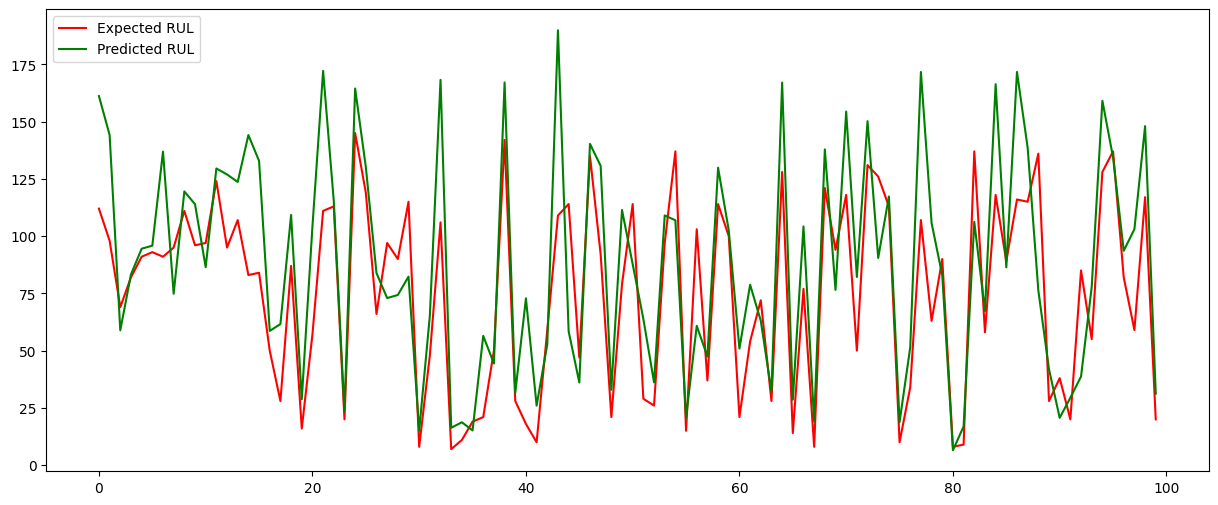



For FD002



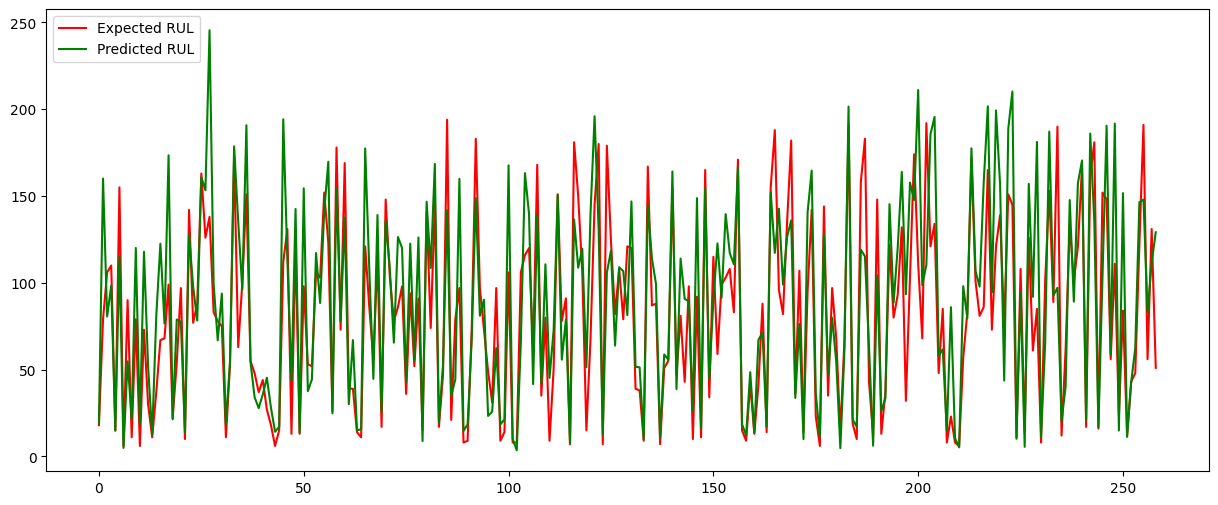



For FD003



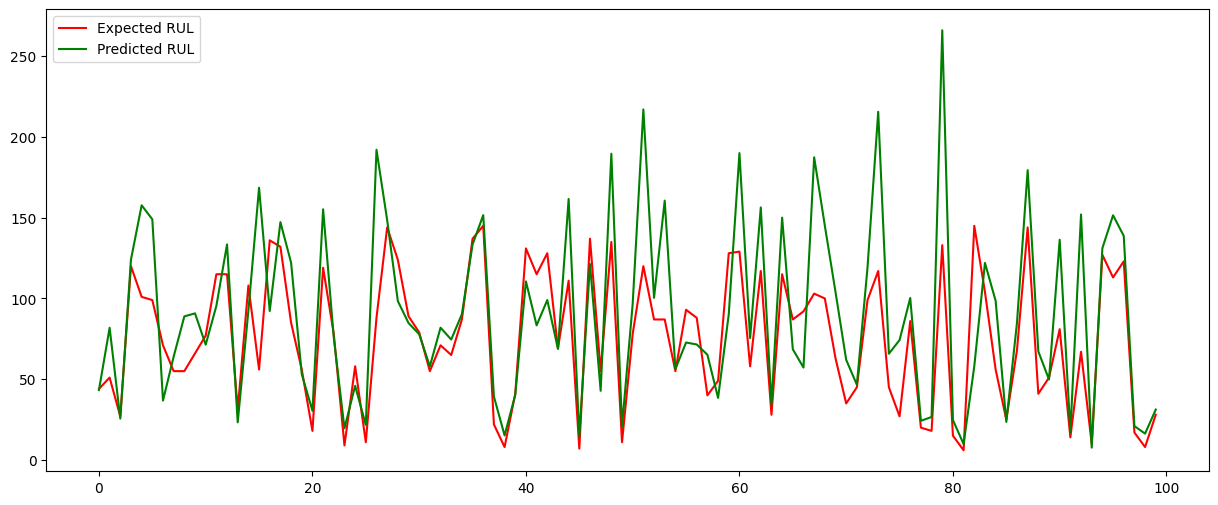



For FD004



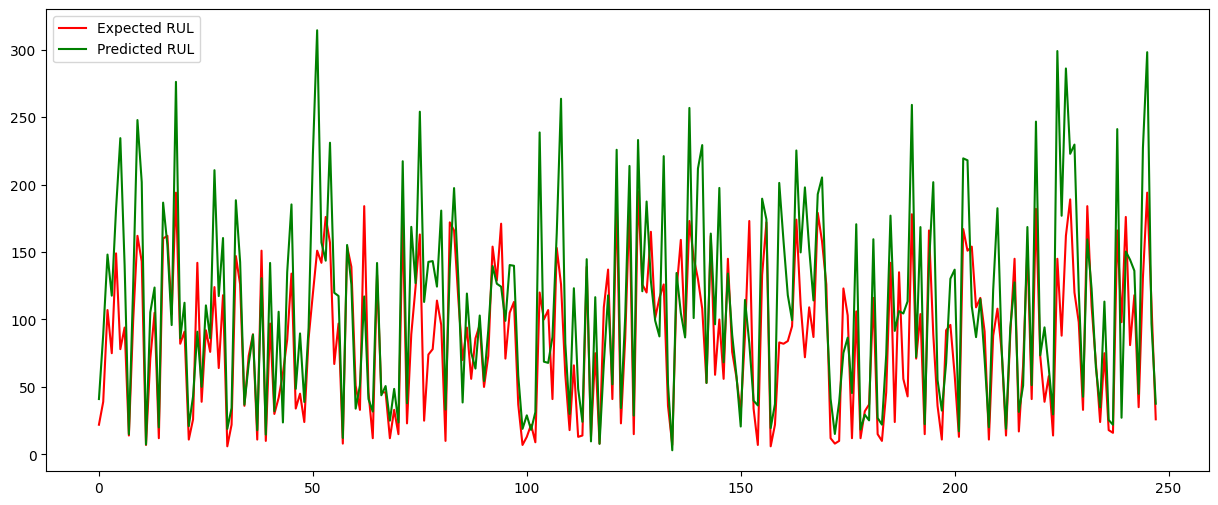



For FD001



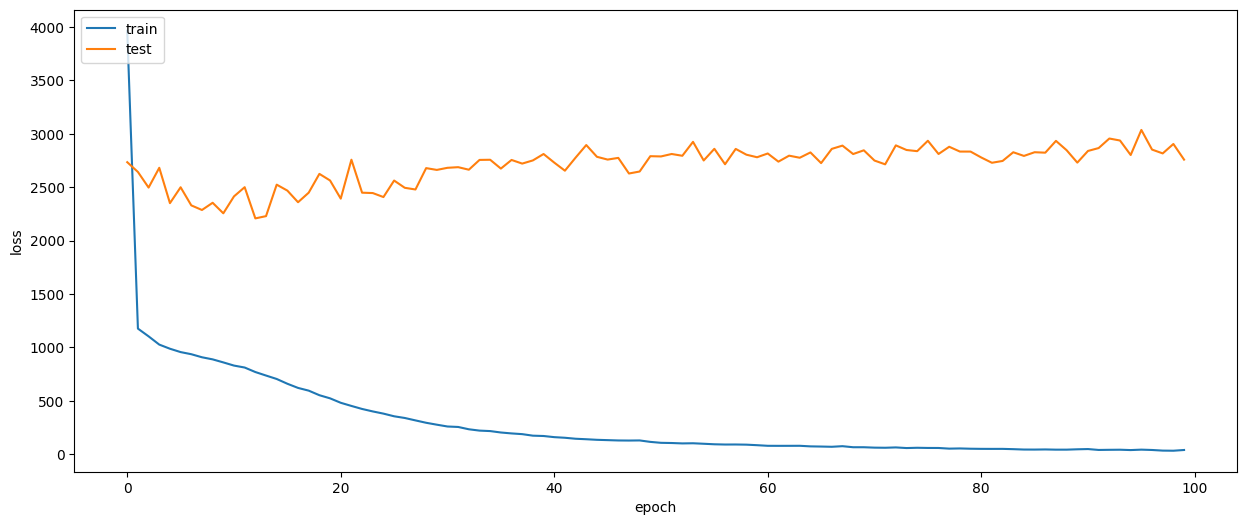



For FD002



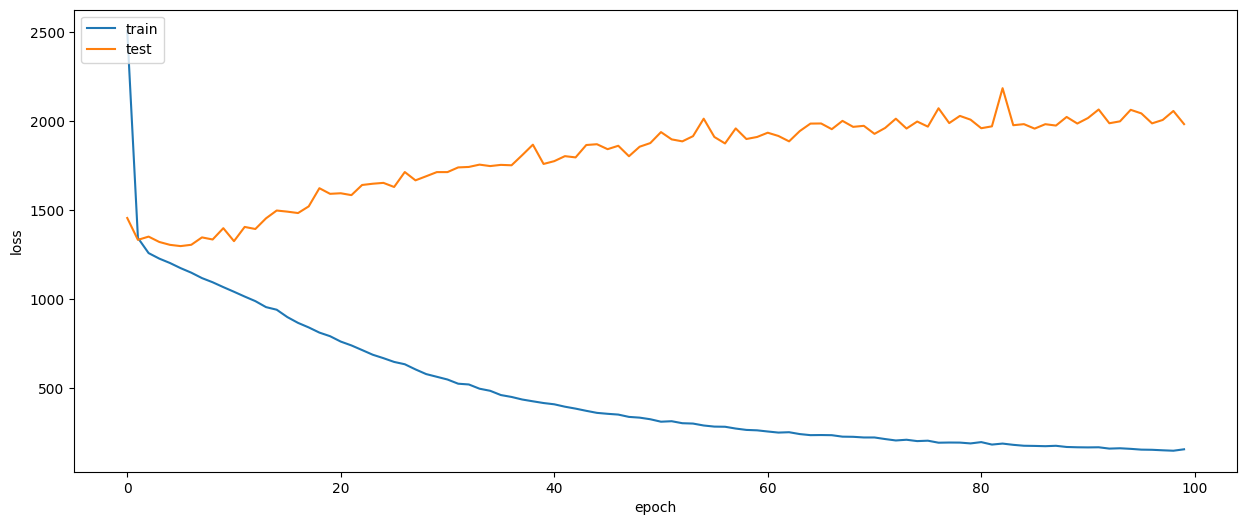



For FD003



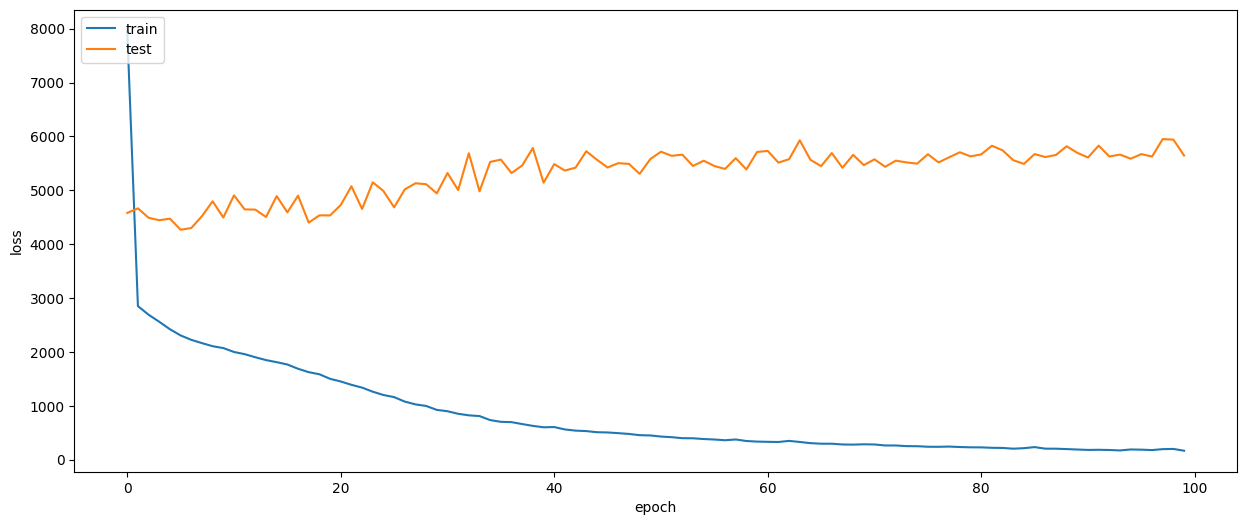



For FD004



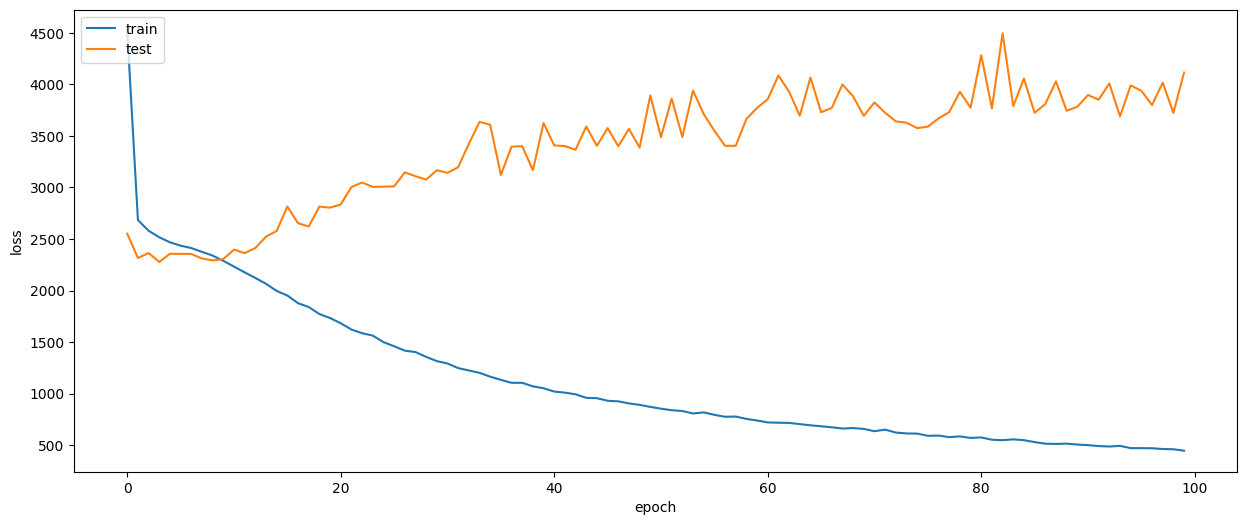

In [61]:
# Plotting CNN results
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(cnn_predicted_rul_datasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(cnn_histories[i].history['loss'])
    plt.plot(cnn_histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print("\n")

For FD001 CNN Model Absolute Error



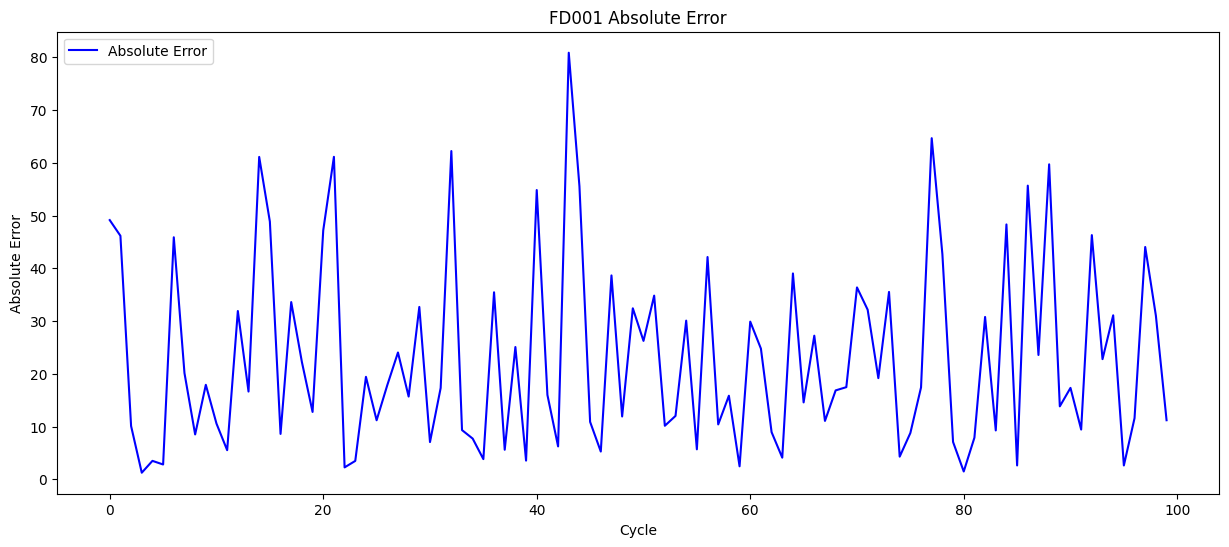



For FD002 CNN Model Absolute Error



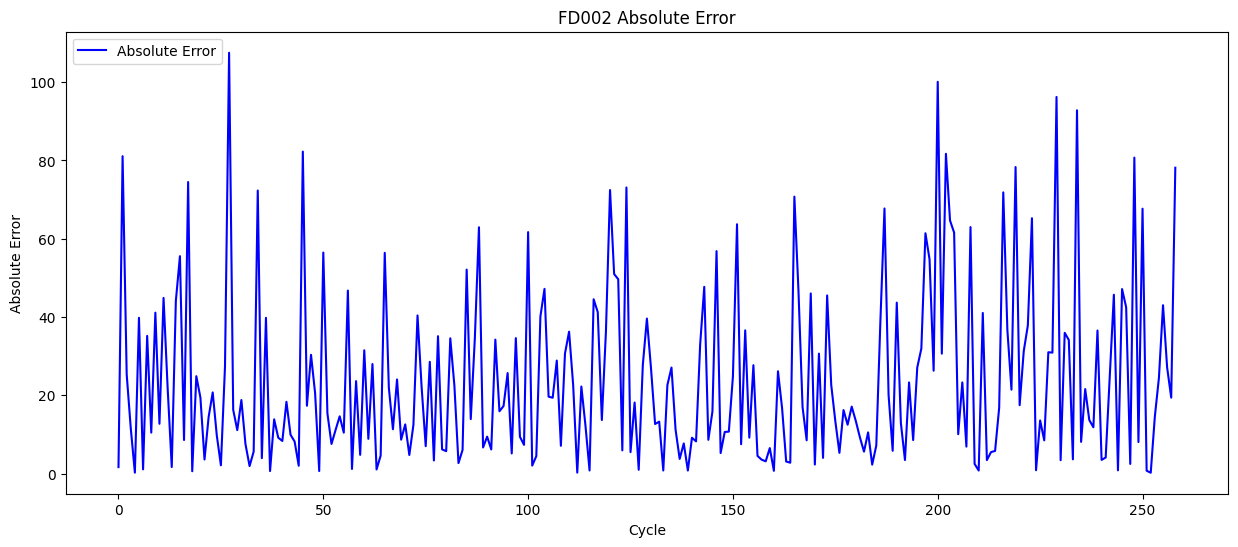



For FD003 CNN Model Absolute Error



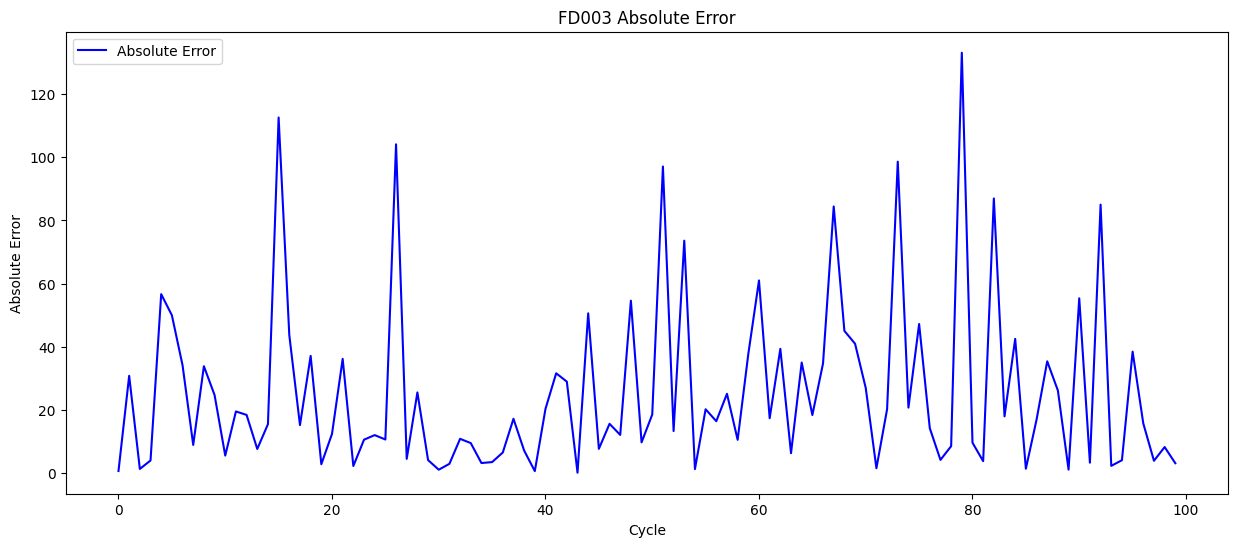



For FD004 CNN Model Absolute Error



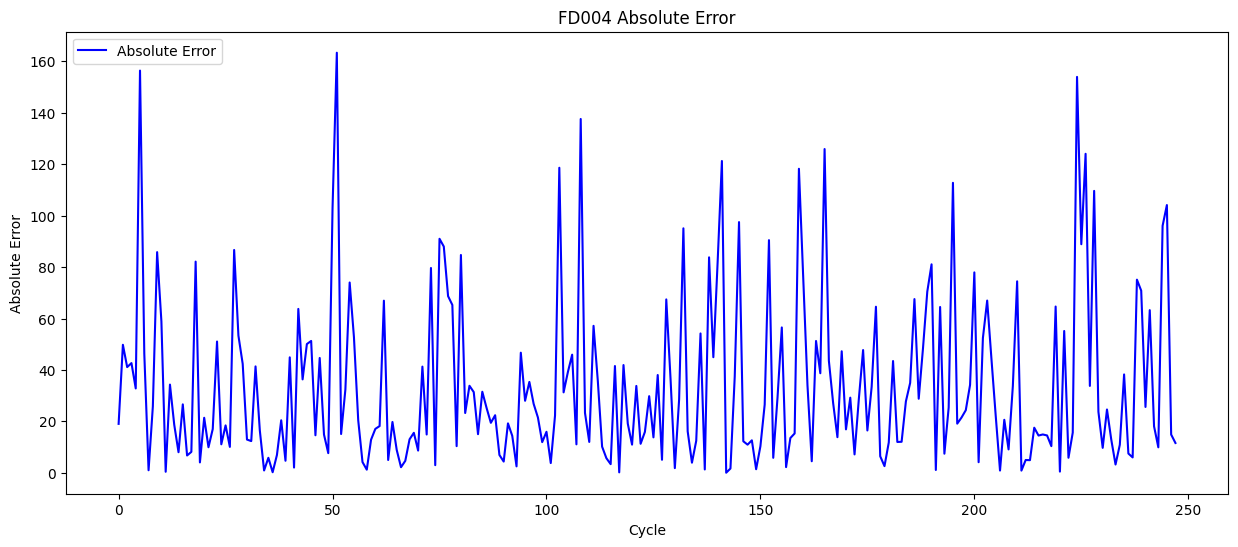

In [62]:
# Plotting absolute error between predicted and expected RUL
for i in range(4):
    print("For FD00" + str(i + 1) + " CNN Model Absolute Error\n")
    plt.figure(figsize=(15, 6))
    absolute_error = np.abs(np.array(rulDatasets[i]) - np.array(cnn_predicted_rul_datasets[i]))
    plt.plot(absolute_error, label="Absolute Error", color="Blue")
    plt.legend(loc='upper left')
    plt.title(f"FD00{i+1} Absolute Error")
    plt.xlabel("Cycle")
    plt.ylabel("Absolute Error")
    plt.show()
    print("\n")

In [46]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [47]:
def createCNNLSTMModel(shape, name="CNN-LSTM"):
    model = Sequential(name=name)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(shape[1], shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    return model

In [54]:
#  CNN-LSTM model training
trainedModel = []
histories = []
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    name = "FD00" + str(i + 1)
    model = createCNNLSTMModel(processedTrainDatasets[i].shape, name=name)
    display(model.summary())
    history = model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs=100, validation_split=0.2, batch_size=128, verbose=1)
    print("\n")
    trainedModel.append(model)
    histories.append(history)

For FD001



Model: "FD001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 4, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_49 (LSTM)                       │ (None, 4, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_50 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,849 (636.13 KB)

 Trainable params: 162,849 (636.13 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 13144.9092 - val_loss: 16488.0781
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 11814.9766 - val_loss: 15628.1904
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 11017.1289 - val_loss: 14846.8975
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 10399.7246 - val_loss: 14125.7471
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9839.4688 - val_loss: 13454.7881
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9409.9111 - val_loss: 12804.1777
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8733.6426 - val_loss: 12167.2959
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8205.4111 - val_loss: 11584.1709
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7642.9976 - val_loss: 11034.6924
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7088.0205 - val_loss: 10517.1904
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 

Model: "FD002"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_51 (LSTM)                       │ (None, 4, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ (None, 4, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_53 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,849 (636.13 KB)

 Trainable params: 162,849 (636.13 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 13674.9629 - val_loss: 11503.2256
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 11481.4346 - val_loss: 9920.0088
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 9771.6689 - val_loss: 8537.4590
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 8464.3809 - val_loss: 7348.8062
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 7205.9448 - val_loss: 6344.2979
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 6322.8003 - val_loss: 5497.5317
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 5446.2539 - val_loss: 4775.7778
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4721.9907 - val_loss: 4168.8525
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4038.1843 - val_loss: 3665.8943
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 3598.1006 - val_loss: 3219.2322
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step 

Model: "FD003"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_54 (LSTM)                       │ (None, 4, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 4, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_56 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,849 (636.13 KB)

 Trainable params: 162,849 (636.13 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 25986.2383 - val_loss: 25513.4297
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 23520.3047 - val_loss: 24265.1484
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 22746.8125 - val_loss: 23124.5645
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 21739.3320 - val_loss: 22064.6016
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 20959.9375 - val_loss: 21072.5000
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 19724.6582 - val_loss: 20143.1582
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 18815.2129 - val_loss: 19270.9219
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 17877.7734 - val_loss: 18359.3809
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 17044.6895 - val_loss: 17506.3906
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 16262.0518 - val_loss: 16719.7656
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━━

Model: "FD004"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)                   │ (None, 8, 64)               │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_57 (LSTM)                       │ (None, 4, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_58 (LSTM)                       │ (None, 4, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_59 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,849 (636.13 KB)

 Trainable params: 162,849 (636.13 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 23077.4258 - val_loss: 18067.4863
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 19423.0234 - val_loss: 15756.0430
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 17209.7051 - val_loss: 13825.4834
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 15040.1211 - val_loss: 12015.1367
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 13461.0879 - val_loss: 10490.7002
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 11864.0469 - val_loss: 9166.5957
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 10490.3301 - val_loss: 8044.2056
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 9348.9102 - val_loss: 7050.4146
Epoch 9/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 8190.8882 - val_loss: 6230.3574
Epoch 10/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 7344.2642 - val_loss: 5535.7856
Epoch 11/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 8s 2

In [55]:
# Predict RUL with the CNN-LSTM model
predictedRulDatasets = []
for i in range(4):
    predictedRul = trainedModel[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul = np.split(predictedRul, np.cumsum(testWindowList[i])[:-1])
    predictedRul = [np.average(ruls, weights=np.repeat(1 / testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList[i])]

    predictedRulDatasets.append(predictedRul)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [56]:
# Calculate RMSE and R2 score
rmseList = []
r2_scoreList = []
for i in range(4):
    rmse = np.sqrt(mse(rulDatasets[i], predictedRulDatasets[i]))
    print("For FD00" + str(i + 1))
    print("Root Mean Square Error:", rmse)
    print("\n")
    rmseList.append(rmse)

for i in range(4):
    r2_sc = r2_score(rulDatasets[i], predictedRulDatasets[i])
    print("For FD00" + str(i + 1))
    print("R2 Score:", r2_sc)
    print("\n")
    r2_scoreList.append(r2_sc)

For FD001
Root Mean Square Error: 28.24577796842792


For FD002
Root Mean Square Error: 31.67794119539112


For FD003
Root Mean Square Error: 40.119872540537365


For FD004
Root Mean Square Error: 41.95763732152936


For FD001
R2 Score: 0.5379940830264611


For FD002
R2 Score: 0.6530301199896578


For FD003
R2 Score: 0.060687192448819816


For FD004
R2 Score: 0.4078251956817296




For FD001



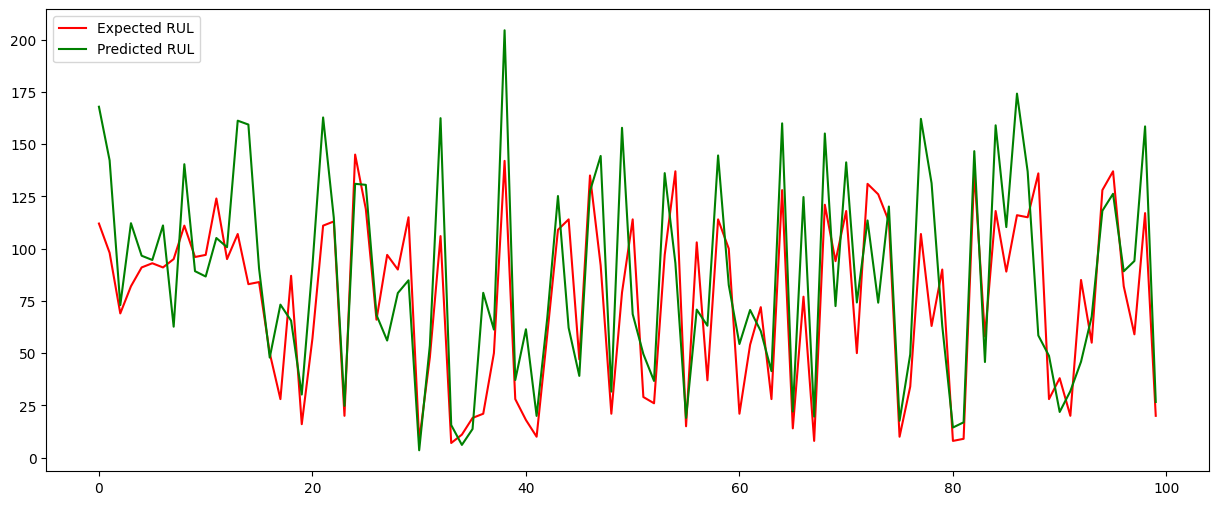



For FD002



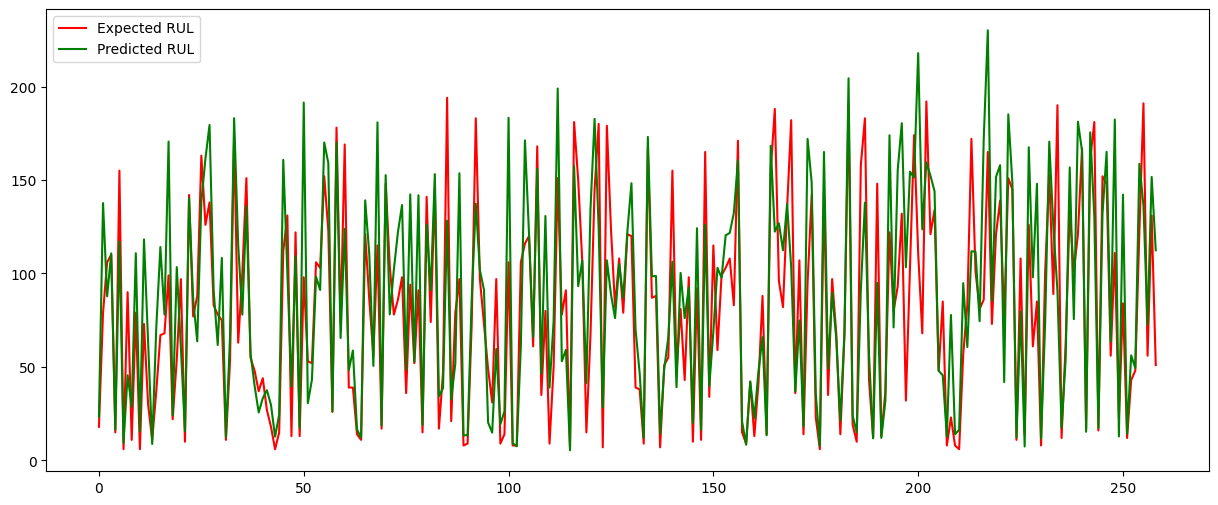



For FD003



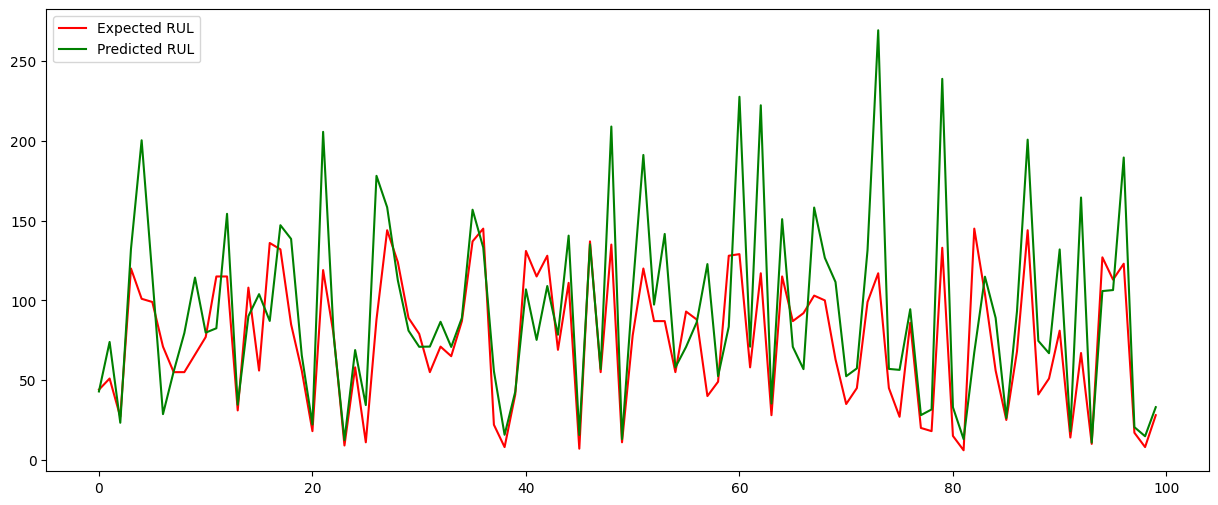



For FD004



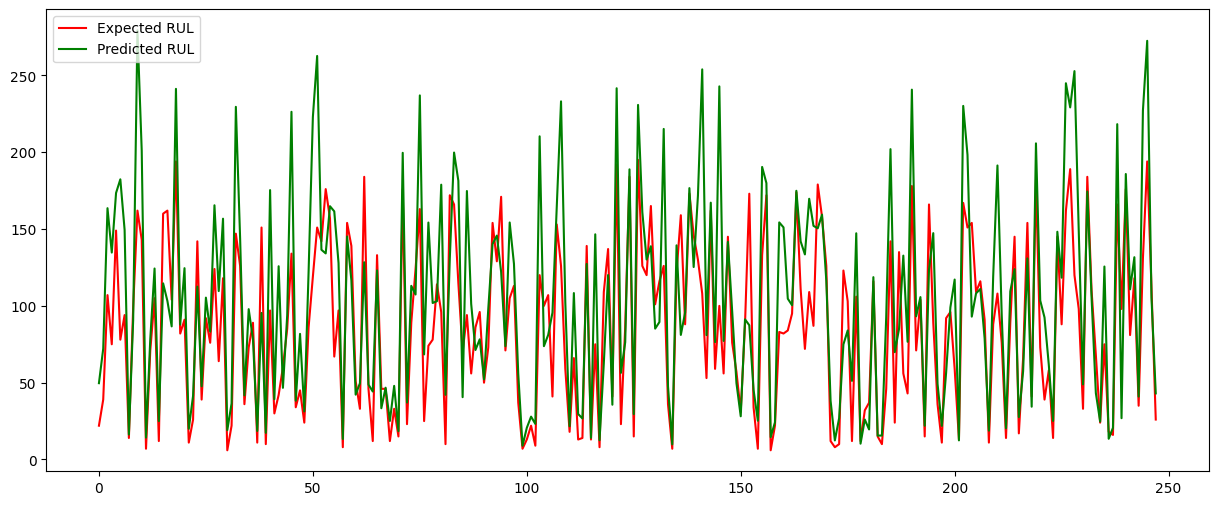



For FD001



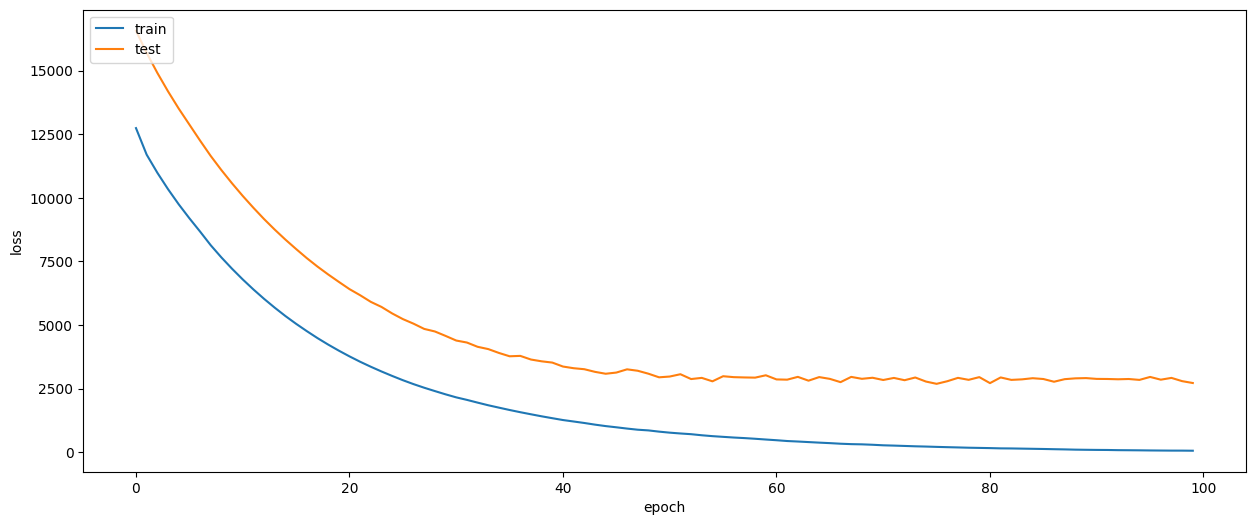



For FD002



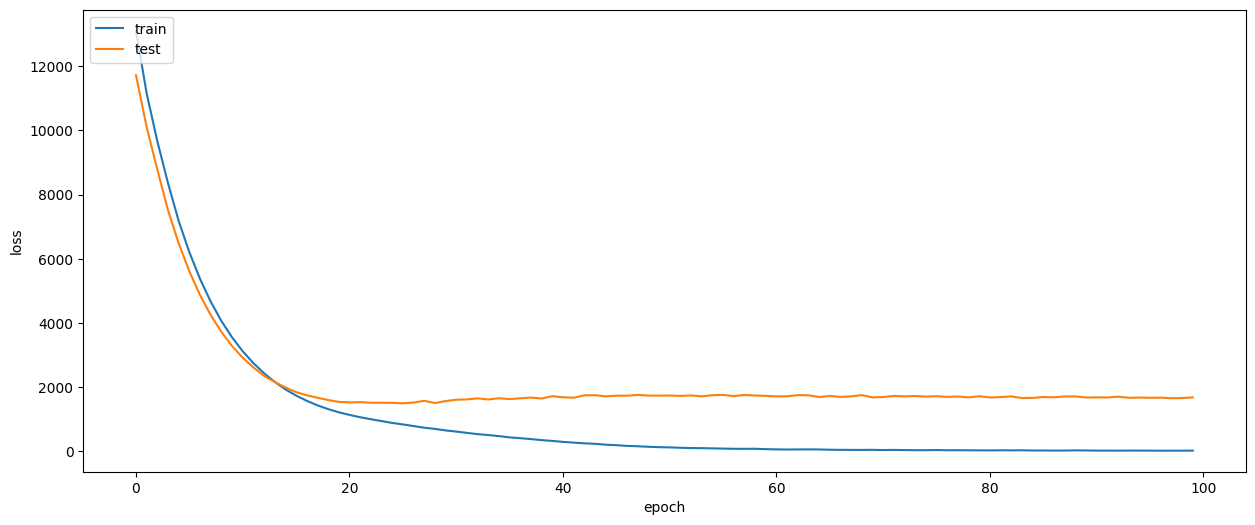



For FD003



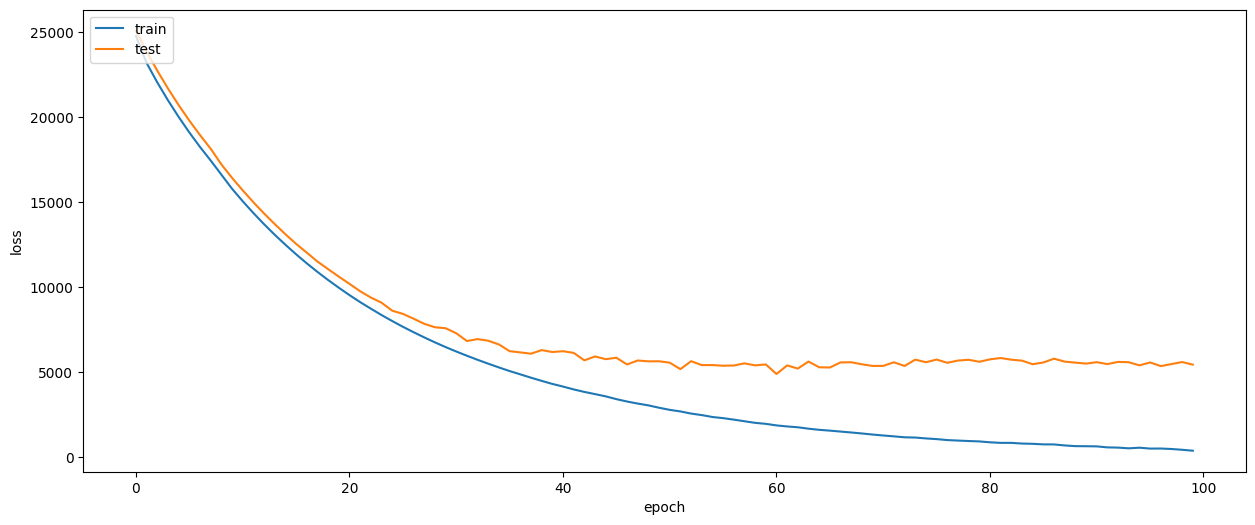



For FD004



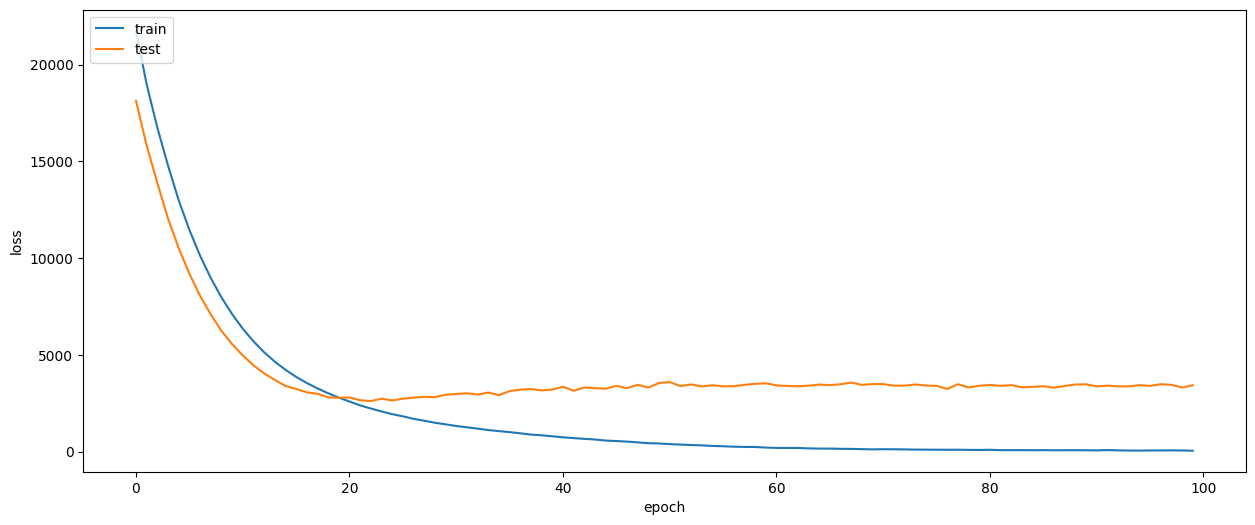

In [51]:
# Plot the results
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(predictedRulDatasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

# Plot the training loss
for i in range(4):
    print("For FD00" + str(i + 1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print("\n")

In [63]:
#LSTM
trainedModel = []
histories = []

In [64]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    name = "FD00" + str(i+1)
    model = createModel(processedTrainDatasets[i].shape, name = name)
    display(model.summary())
    history = model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs = 100, validation_split = 0.2, batch_size = 128, verbose = 1)
    print("\n")
    trainedModel.append(model)
    histories.append(history)

For FD001



Model: "FD001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 10, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 13425.0771 - val_loss: 16482.9453
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 11774.7832 - val_loss: 15614.5117
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 10936.9521 - val_loss: 14831.6699
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 10321.0801 - val_loss: 14108.2109
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9824.0820 - val_loss: 13437.1699
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9449.0156 - val_loss: 12811.0576
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8845.0176 - val_loss: 12228.0391
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8309.6855 - val_loss: 11683.6738
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7815.2446 - val_loss: 11178.1465
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7543.4570 - val_loss: 10707.4639
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 

Model: "FD002"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 10, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 13654.2354 - val_loss: 11632.9590
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 11623.9570 - val_loss: 10022.2949
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 9901.7588 - val_loss: 8708.1826
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 8612.2871 - val_loss: 7518.1851
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7339.6597 - val_loss: 6445.3931
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 6463.9268 - val_loss: 5564.0352
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 5552.4307 - val_loss: 4824.1641
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 4757.5386 - val_loss: 4198.5630
Epoch 9/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 4226.9160 - val_loss: 3669.6990
Epoch 10/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 3652.1099 - val_loss: 3239.7104
Epoch 11/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step

Model: "FD003"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 10, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 25745.4961 - val_loss: 25551.1523
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 23698.1445 - val_loss: 24293.7012
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 22711.7168 - val_loss: 23151.0664
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 21178.7109 - val_loss: 22086.7656
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 20677.6289 - val_loss: 21092.6035
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 19596.2402 - val_loss: 20159.9062
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 19097.0664 - val_loss: 19285.4941
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 17518.9043 - val_loss: 18470.3301
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 17400.8730 - val_loss: 17704.3379
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 16482.8066 - val_loss: 16987.7109
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━

Model: "FD004"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 10, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 22579.6406 - val_loss: 18096.7969
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 19655.4395 - val_loss: 15782.6240
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 17128.0996 - val_loss: 13846.3174
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 15285.5234 - val_loss: 12231.9814
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 13476.0039 - val_loss: 10899.0830
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 12351.1348 - val_loss: 9813.0205
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 11346.2256 - val_loss: 8947.4814
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 10000.0059 - val_loss: 7272.7891
Epoch 9/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 8371.0996 - val_loss: 6346.4668
Epoch 10/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 7527.7666 - val_loss: 5603.5913
Epoch 11/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 1

In [65]:
for i in range(4):
    predictedRul = trainedModel[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul = np.split(predictedRul, np.cumsum(testWindowList[i])[:-1])
    predictedRul = [np.average(ruls, weights = np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList[i])]

    predictedRulDatasets.append(predictedRul)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [66]:
for i in range(4):
    rmse = np.sqrt(mse(rulDatasets[i], predictedRulDatasets[i]))
    print("For FD00" + str(i+1))
    print("Root Mean Square Error:", rmse)
    print("\n")
    rmseList.append(rmse)

For FD001
Root Mean Square Error: 27.23074377158614


For FD002
Root Mean Square Error: 32.474507979475206


For FD003
Root Mean Square Error: 33.6557078244943


For FD004
Root Mean Square Error: 40.4477776610732




In [67]:
for i in range(4):
    r2_sc = r2_score(rulDatasets[i], predictedRulDatasets[i])
    print("For FD00" + str(i+1))
    print("R2 Score:", r2_sc)
    print("\n")
    r2_scoreList.append(r2_sc)

For FD001
R2 Score: 0.5706025478972022


For FD002
R2 Score: 0.6353610653607643


For FD003
R2 Score: 0.3389891132155374


For FD004
R2 Score: 0.4496775803949128




For FD001



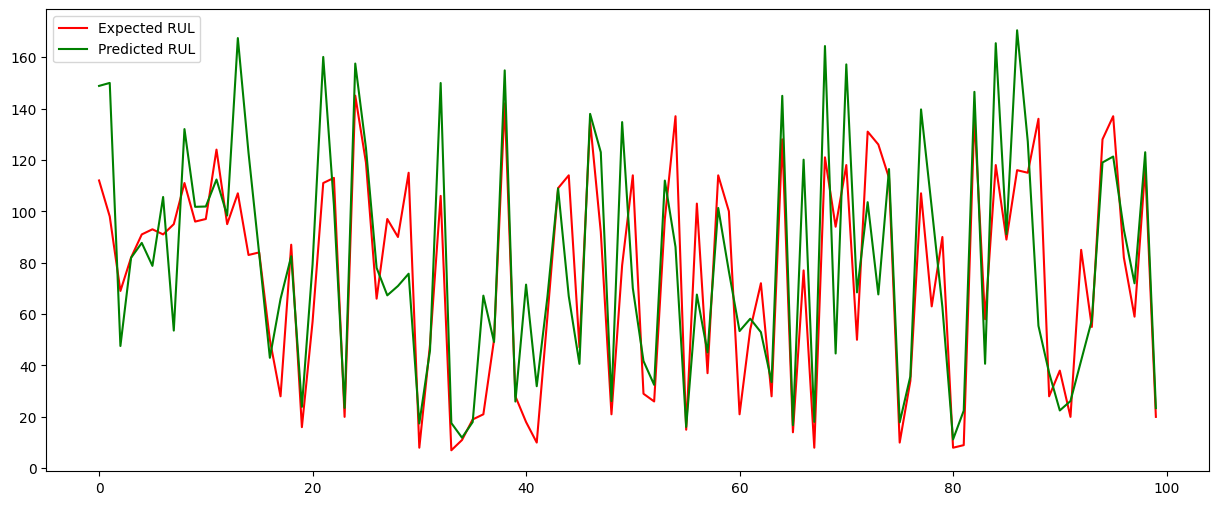



For FD002



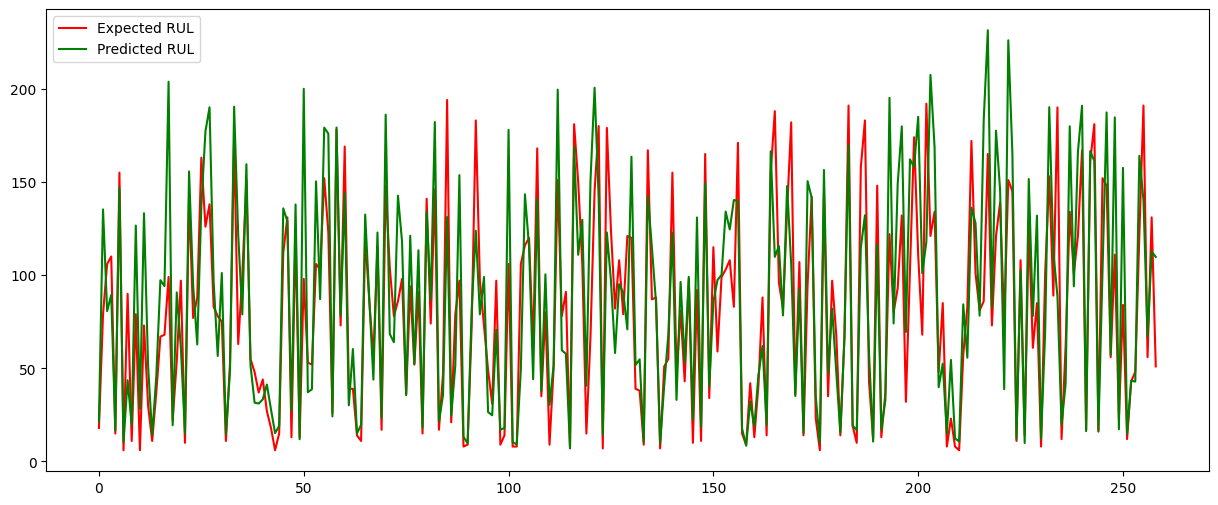



For FD003



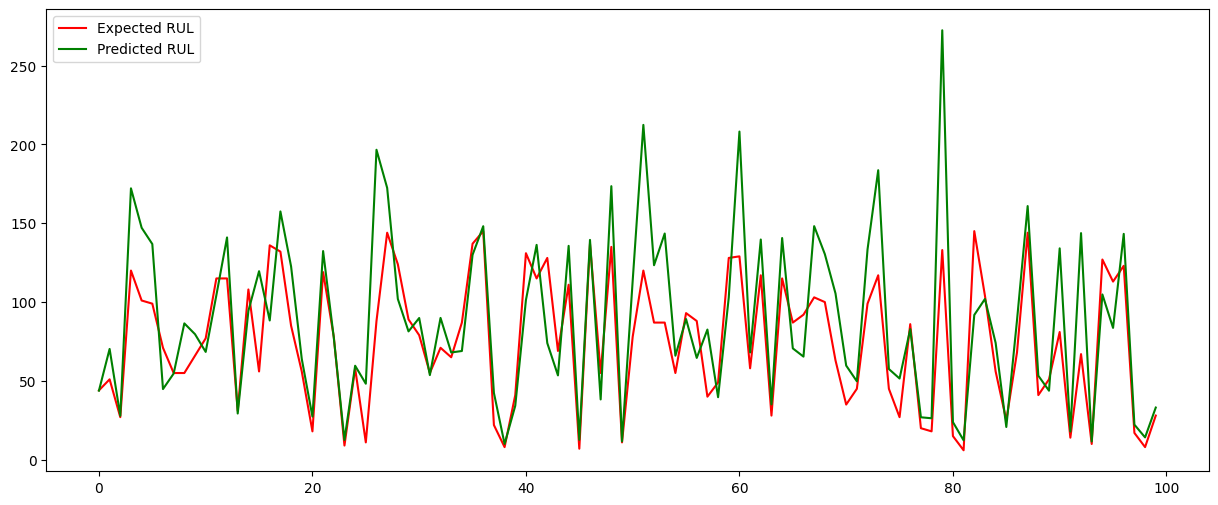



For FD004



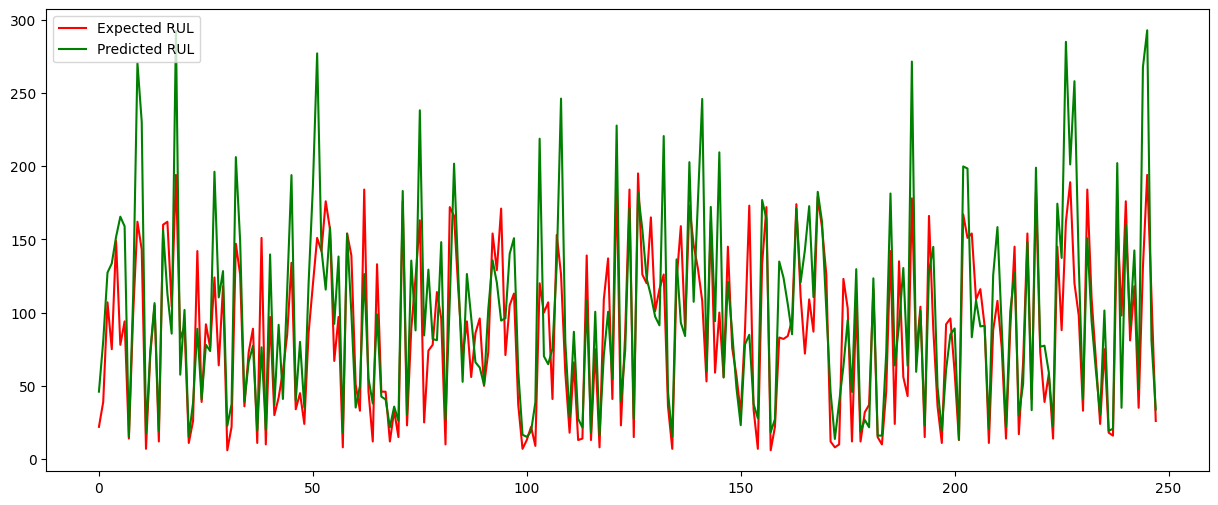

In [68]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    plt.figure(figsize = (15, 6))
    plt.plot(rulDatasets[i], label = "Expected RUL", color = "Red")
    plt.plot(predictedRulDatasets[i], label = "Predicted RUL", color = "Green")
    plt.legend(loc = 'upper left')
    plt.show()
    print("\n")

For FD001



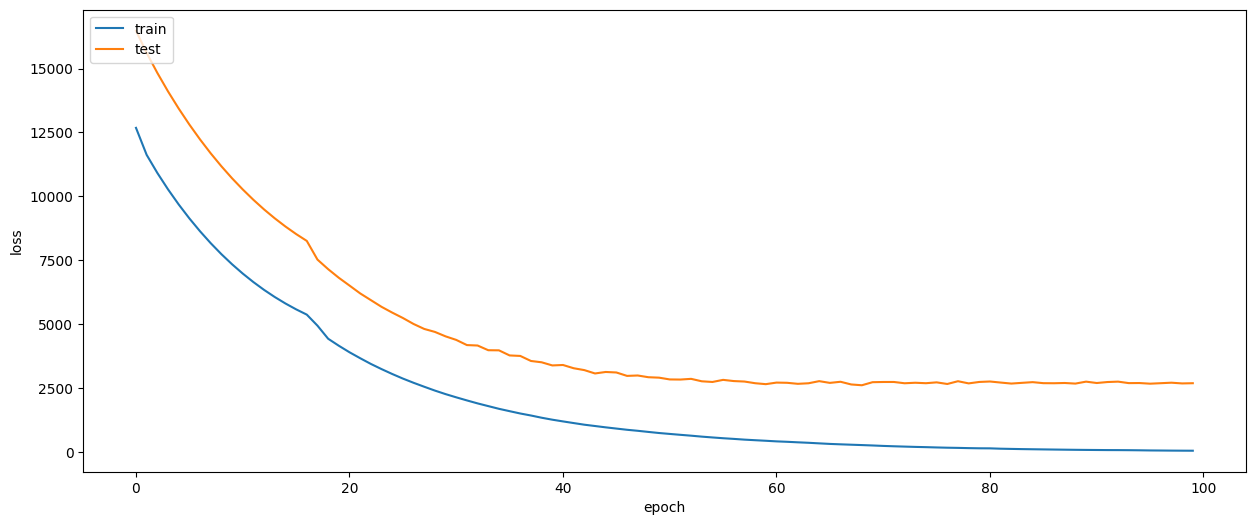



For FD002



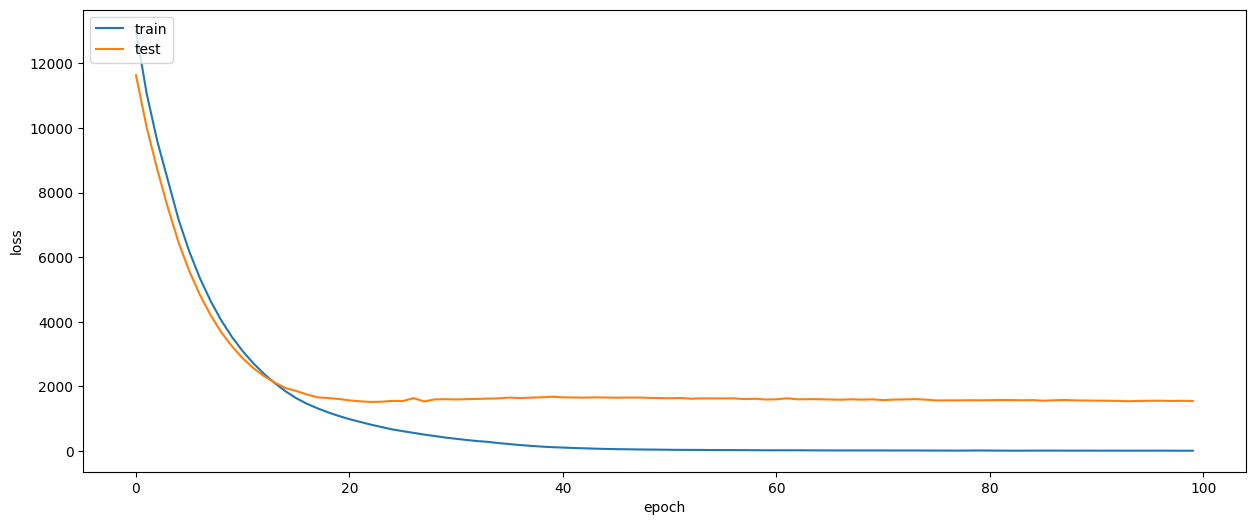



For FD003



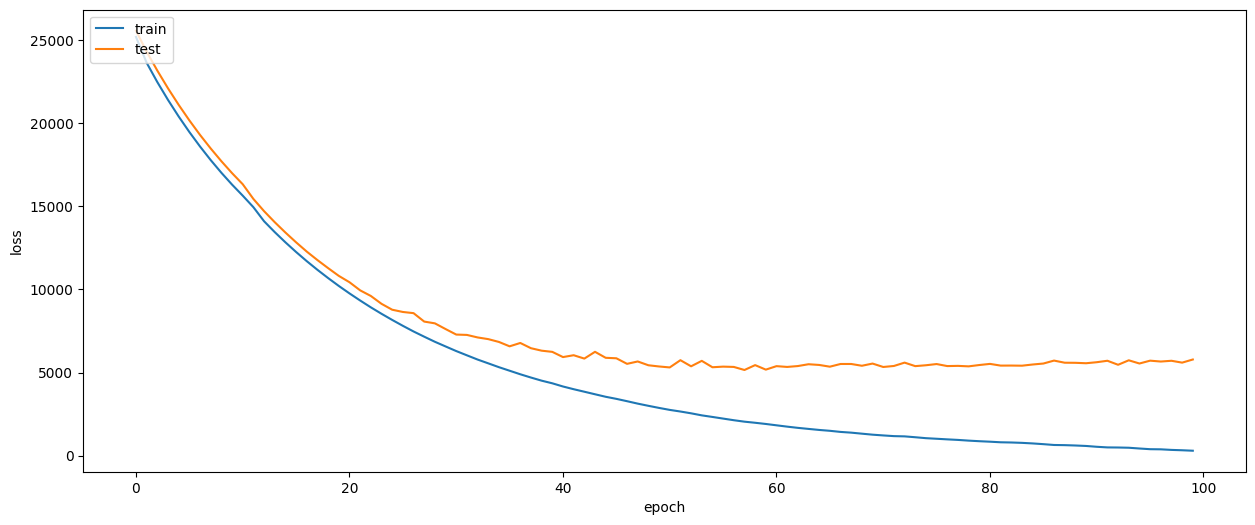



For FD004



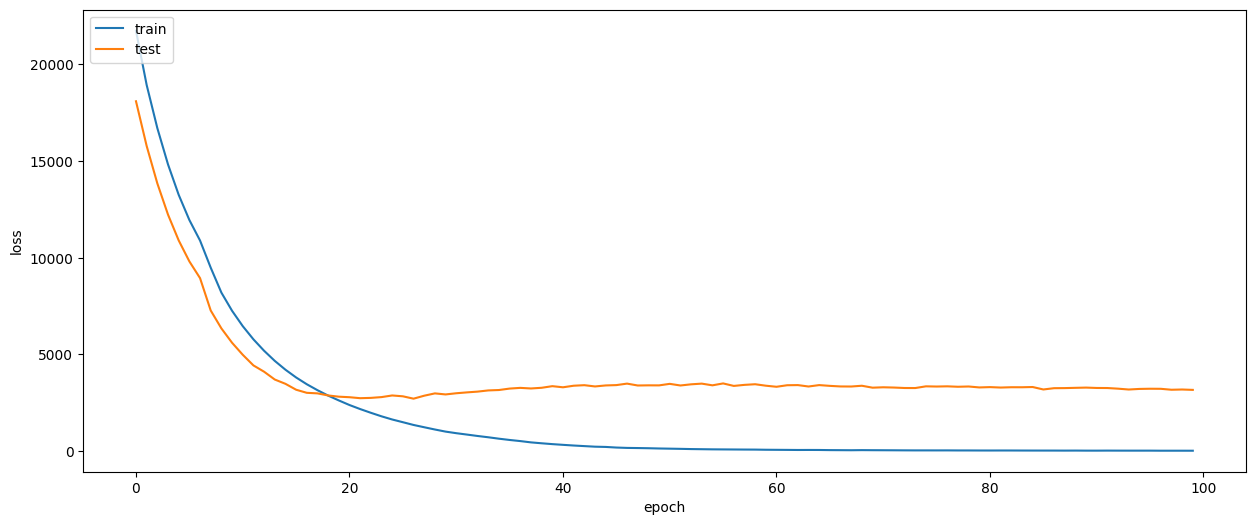

In [69]:
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    plt.figure(figsize = (15, 6))
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    print("\n")

For FD001 CNN Model Absolute Error



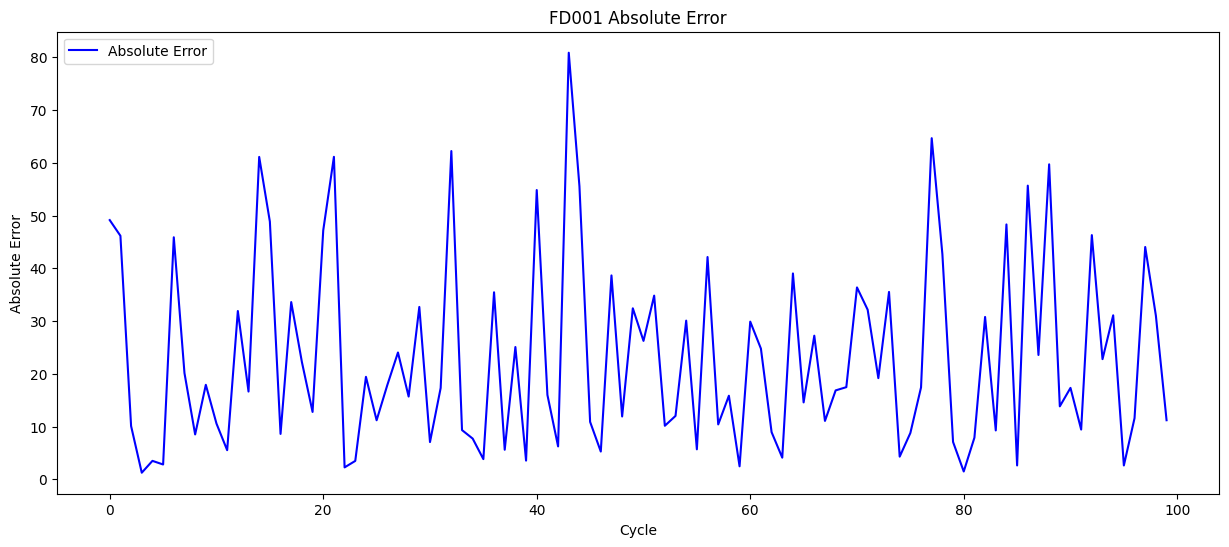



For FD002 CNN Model Absolute Error



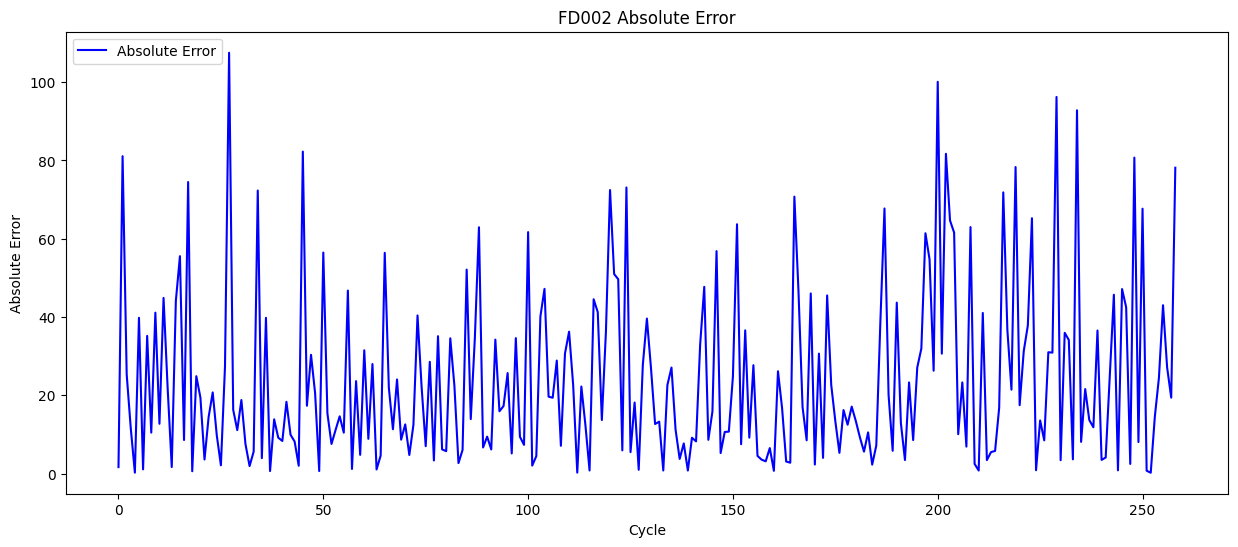



For FD003 CNN Model Absolute Error



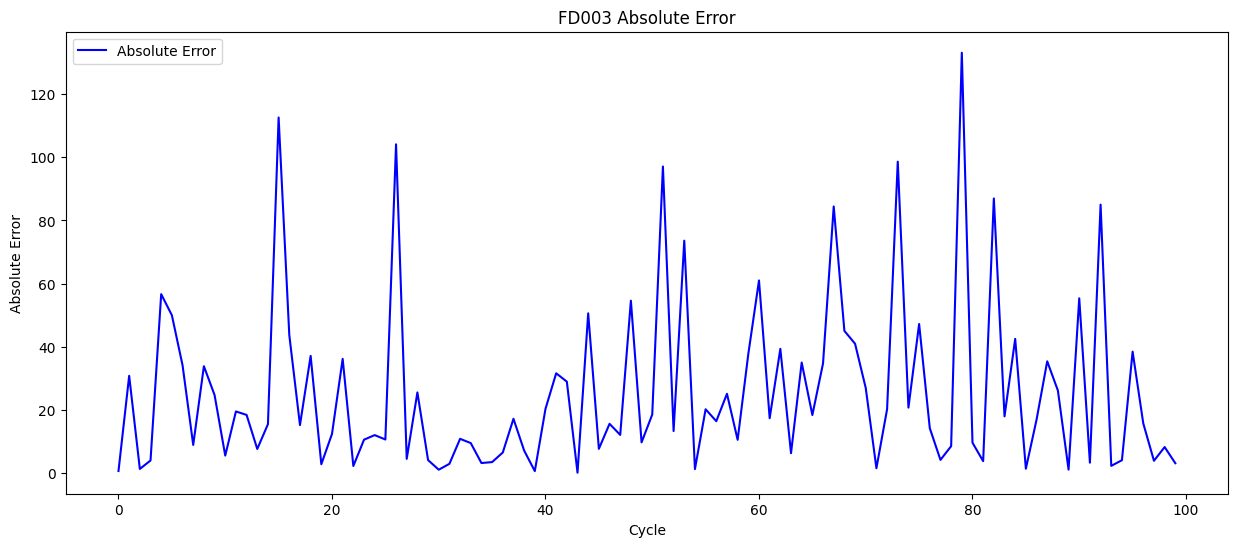



For FD004 CNN Model Absolute Error



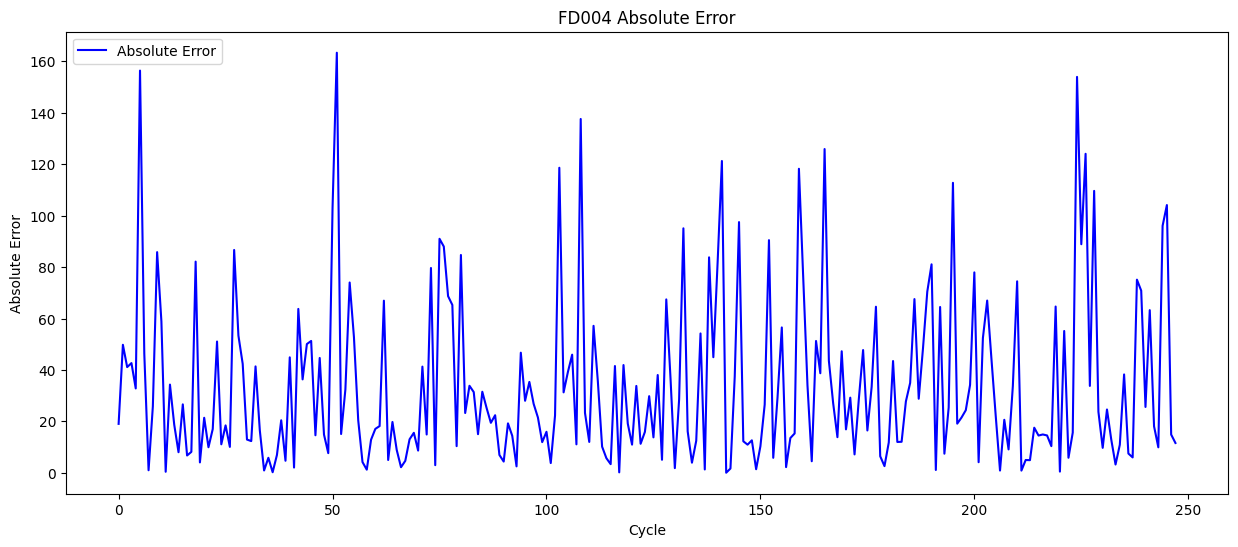

In [70]:
# Plotting the absolute error between predicted and expected RUL
for i in range(4):
    print("For FD00" + str(i + 1) + " CNN Model Absolute Error\n")
    plt.figure(figsize=(15, 6))
    absolute_error = np.abs(np.array(rulDatasets[i]) - np.array(cnn_predicted_rul_datasets[i]))
    plt.plot(absolute_error, label="Absolute Error", color="Blue")
    plt.legend(loc='upper left')
    plt.title(f"FD00{i+1} Absolute Error")
    plt.xlabel("Cycle")
    plt.ylabel("Absolute Error")
    plt.show()
    print("\n")

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import tensorflow as tf

In [72]:
# Function to create the GRU model
def createGRUModel(input_shape, name="GRU_Model"):
    model = Sequential(name=name)
    model.add(GRU(128, return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [73]:
# List to store GRU models for each dataset
gru_models = []

In [74]:
# Training the GRU model for each dataset
for i in range(4):
    print("Training GRU model for FD00" + str(i+1) + "\n")
    name = "FD00" + str(i+1) + "_GRU"
    model_gru = createGRUModel(processedTrainDatasets[i].shape, name=name)
    history_gru = model_gru.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], 
                                epochs=100, validation_split=0.2, batch_size=128, verbose=1)
    gru_models.append(model_gru)

Training GRU model for FD001

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 12981.7061 - val_loss: 16465.1191
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 11876.9033 - val_loss: 15618.0742
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 11238.0654 - val_loss: 14845.7803
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 10494.9834 - val_loss: 14128.5068
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9690.7783 - val_loss: 13459.4395
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9302.0596 - val_loss: 12834.9658
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8624.7637 - val_loss: 12253.0898
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8306.2656 - val_loss: 11709.1738
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7960.2852 - val_loss: 11201.6816
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7546.6411 - val_loss: 10732.2461
Epoch 11/100
12

In [75]:
# Predicting RUL for test datasets using the trained GRU models
predictedRulDatasetsGRU = []

In [76]:
for i in range(4):
    predictedRul_gru = gru_models[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul_gru = np.split(predictedRul_gru, np.cumsum(testWindowList[i])[:-1])
    predictedRul_gru = [np.average(ruls, weights=np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul_gru, testWindowList[i])]
    predictedRulDatasetsGRU.append(predictedRul_gru)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [77]:
# Evaluate the performance metrics for the GRU model
rmse_gru_list = []
r2_score_gru_list = []

In [78]:
for i in range(4):
    rmse_gru = np.sqrt(mse(rulDatasets[i], predictedRulDatasetsGRU[i]))
    print("For FD00" + str(i+1))
    print("Root Mean Square Error (GRU):", rmse_gru)
    rmse_gru_list.append(rmse_gru)

    r2_sc_gru = r2_score(rulDatasets[i], predictedRulDatasetsGRU[i])
    print("R2 Score (GRU):", r2_sc_gru)
    r2_score_gru_list.append(r2_sc_gru)

For FD001
Root Mean Square Error (GRU): 28.15202068883769
R2 Score (GRU): 0.5410561000872645
For FD002
Root Mean Square Error (GRU): 31.166616817740028
R2 Score (GRU): 0.6641408361734524
For FD003
Root Mean Square Error (GRU): 38.35705051888133
R2 Score (GRU): 0.14141842605987875
For FD004
Root Mean Square Error (GRU): 41.99899148692802
R2 Score (GRU): 0.40665730517579635


For FD001



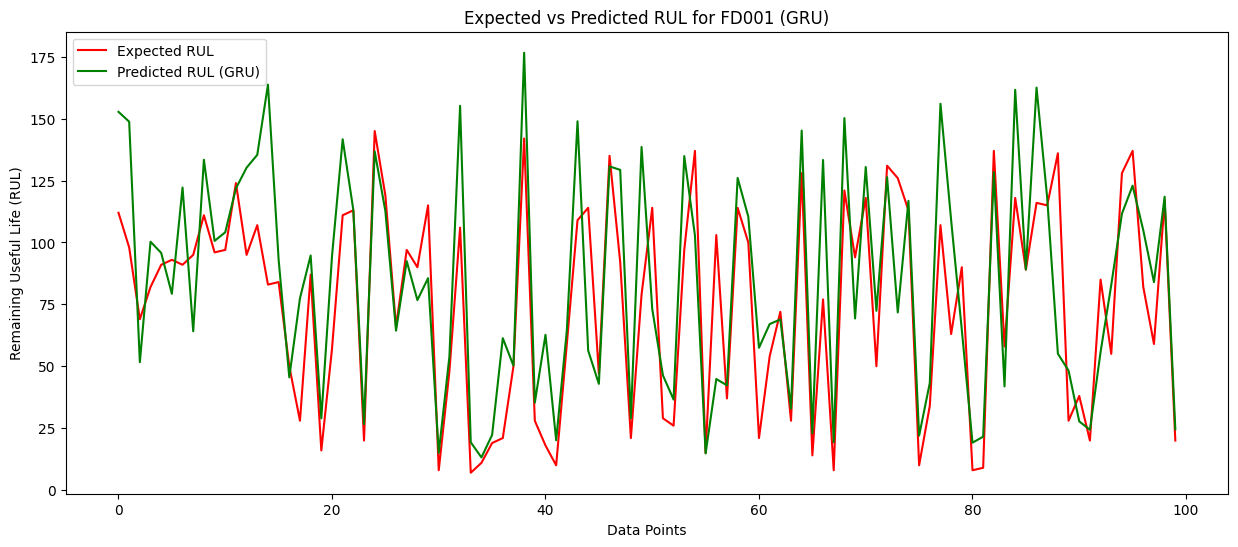



For FD002



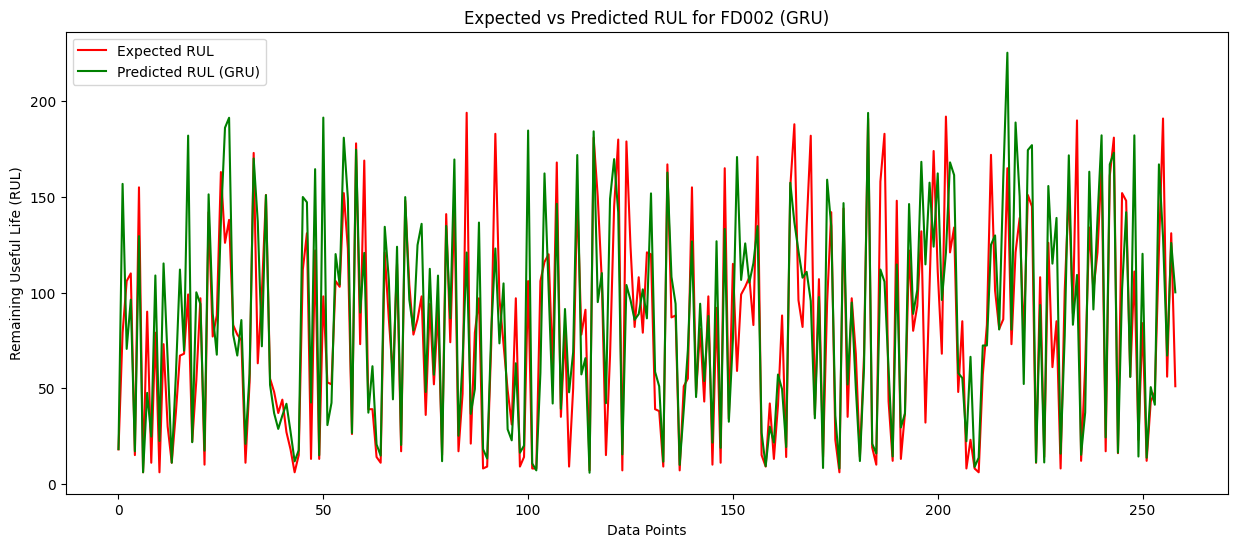



For FD003



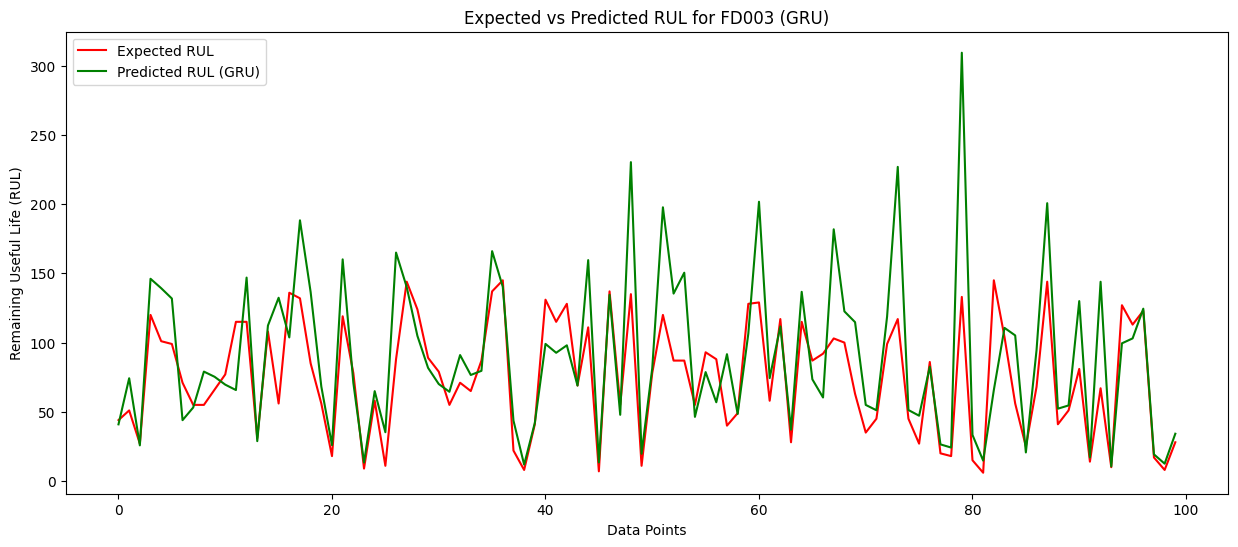



For FD004



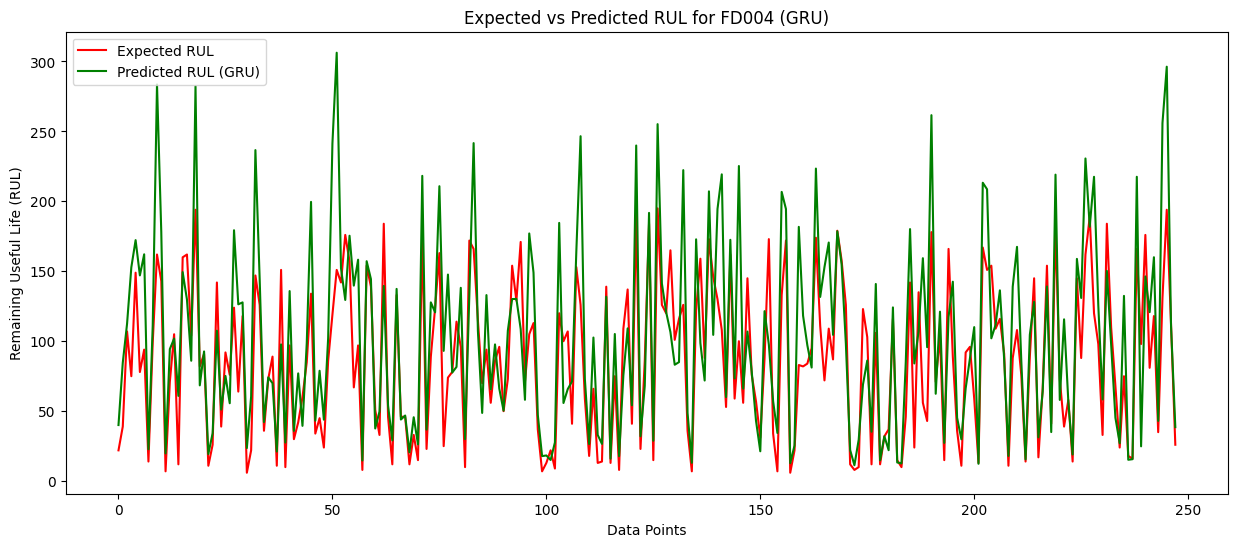

In [79]:
# Plot the predicted RUL and compare with the expected RUL
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(predictedRulDatasetsGRU[i], label="Predicted RUL (GRU)", color="Green")
    plt.xlabel("Data Points")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.title(f"Expected vs Predicted RUL for FD00{i+1} (GRU)")
    plt.legend(loc='upper left')
    plt.show()
    print("\n")

For FD001 GRU Model Absolute Error



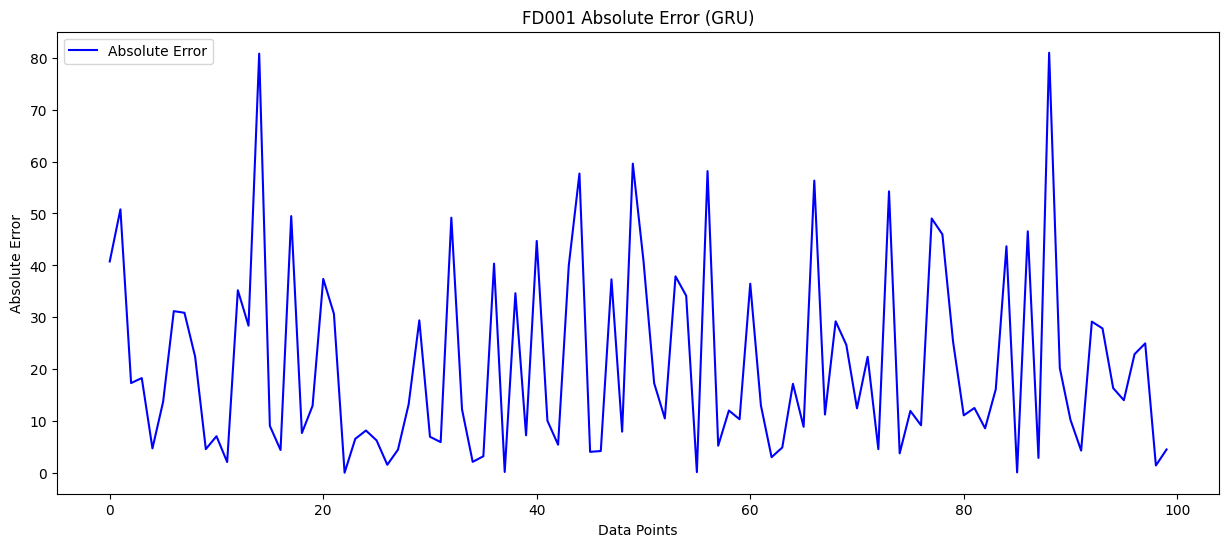



For FD002 GRU Model Absolute Error



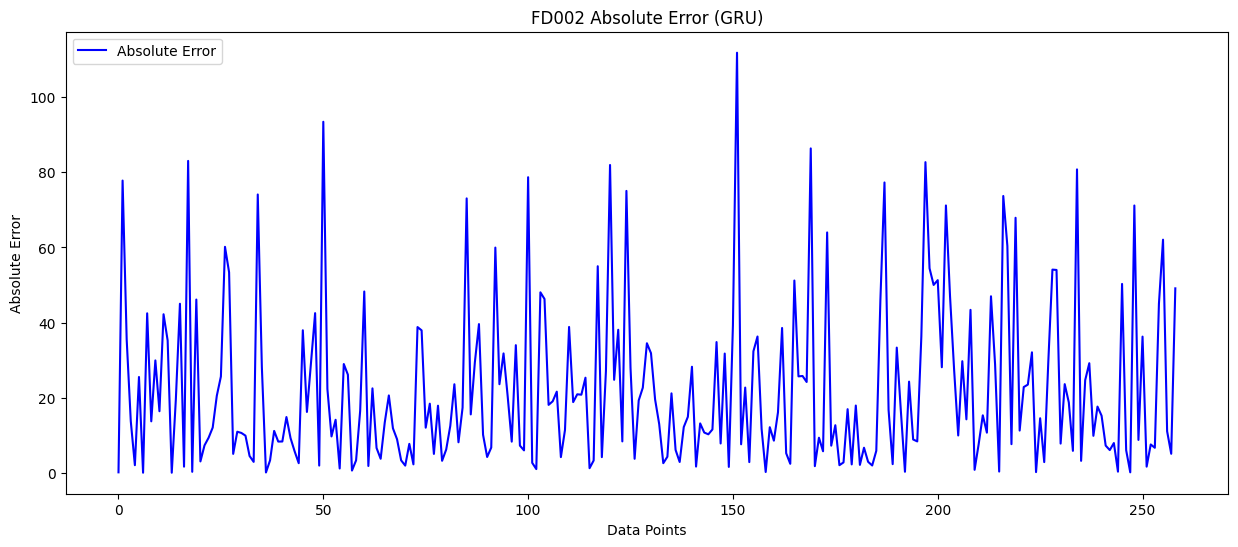



For FD003 GRU Model Absolute Error



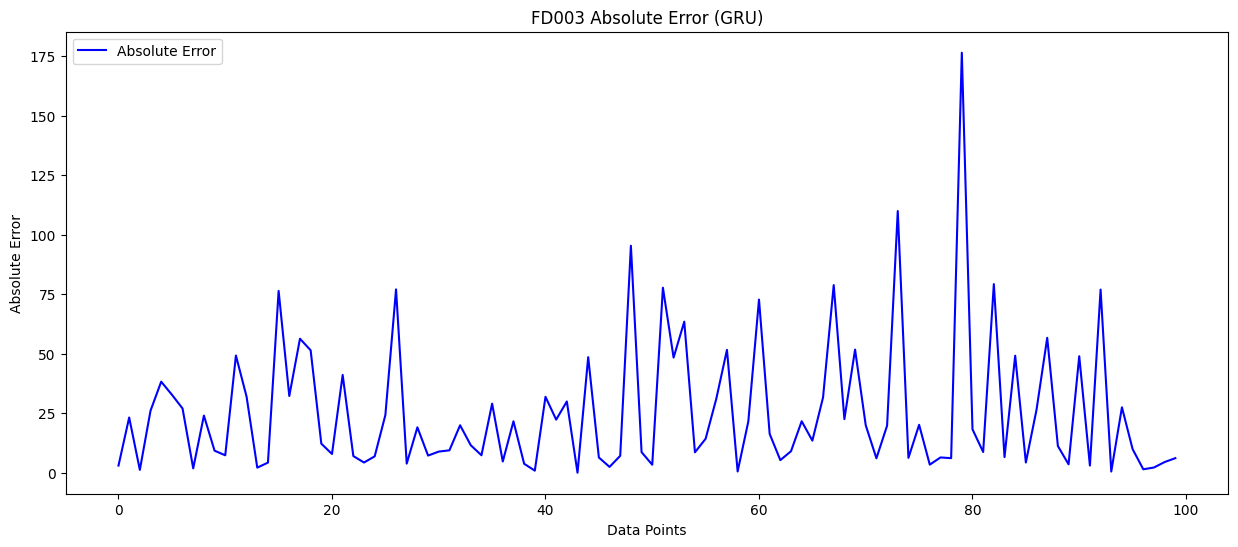



For FD004 GRU Model Absolute Error



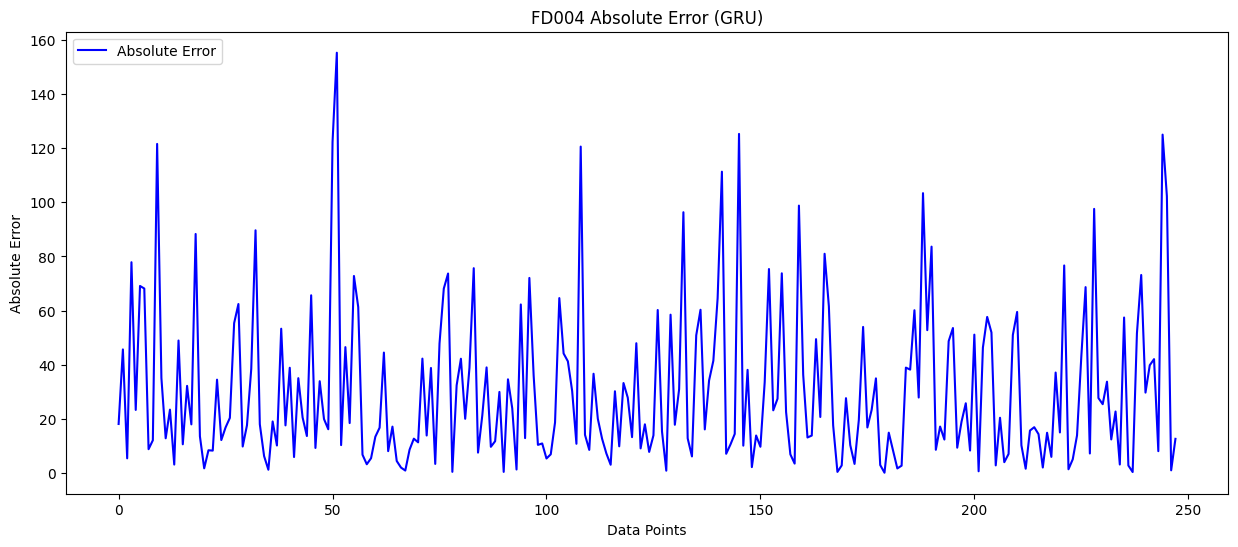

In [80]:
# Plot the absolute error between predicted and expected RUL
for i in range(4):
    print("For FD00" + str(i+1) + " GRU Model Absolute Error\n")
    plt.figure(figsize=(15, 6))
    absolute_error = np.abs(np.array(rulDatasets[i]) - np.array(predictedRulDatasetsGRU[i]))
    plt.plot(absolute_error, label="Absolute Error", color="Blue")
    plt.legend(loc='upper left')
    plt.title(f"FD00{i+1} Absolute Error (GRU)")
    plt.xlabel("Data Points")
    plt.ylabel("Absolute Error")
    plt.show()
    print("\n")

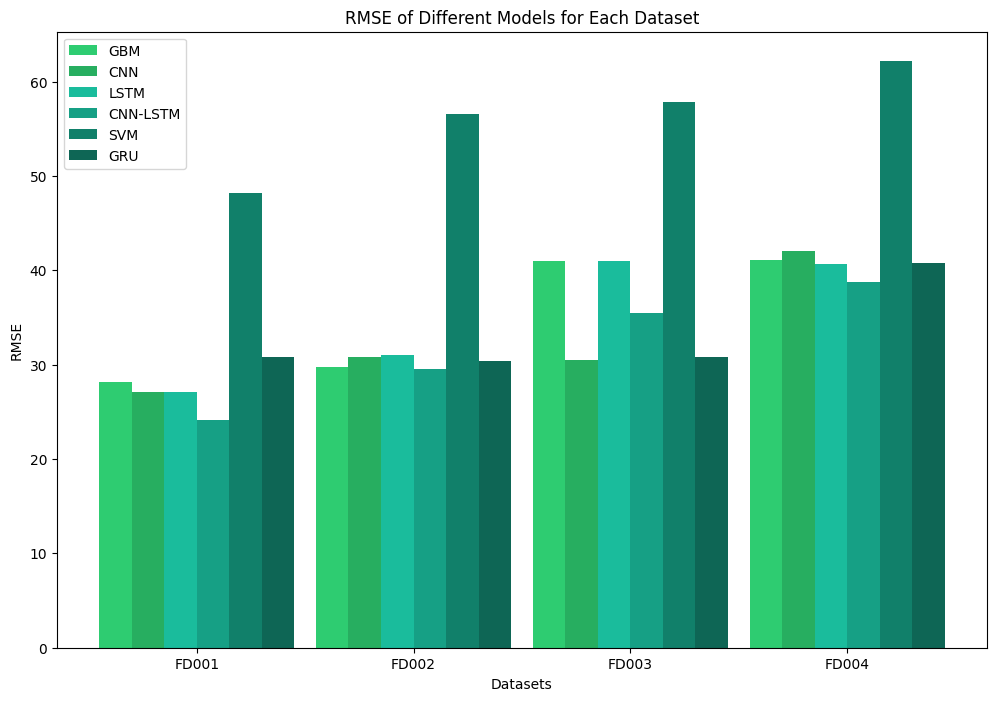

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Example RMSE values for each model (replace these with your actual values)
rmse_gbm = [28.18, 29.80, 40.99, 41.08]
rmse_cnn = [27.15, 30.80, 30.53, 42.00]
rmse_lstm = [27.14, 31.04, 40.98, 40.64]
rmse_cnn_lstm = [24.14, 29.50, 35.52, 38.74]
rmse_svm = [48.18, 56.54, 57.79, 62.18]
rmse_gru = [30.8, 30.37, 30.83, 40.79]

# Combine all RMSE values into a list
models = ['FD001', 'FD002', 'FD003', 'FD004']
rmse_values = [rmse_gbm, rmse_cnn, rmse_lstm, rmse_cnn_lstm, rmse_svm, rmse_gru]
model_names = ['GBM', 'CNN', 'LSTM', 'CNN-LSTM', 'SVM', 'GRU']

# Colors for each model (shades of green)
colors = ['#2ecc71', '#27ae60', '#1abc9c', '#16a085', '#11806a', '#0e6655']

# Plot the RMSE values
plt.figure(figsize=(12, 8))
x = np.arange(len(models))  # the label locations

width = 0.15  # the width of the bars
for i, (rmse, model_name, color) in enumerate(zip(rmse_values, model_names, colors)):
    plt.bar(x + i*width, rmse, width, label=model_name, color=color)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Datasets')
plt.ylabel('RMSE')
plt.title('RMSE of Different Models for Each Dataset')
plt.xticks(x + width*2.5, models)
plt.legend(loc='best')

# Show the plot
plt.show()
